# Lead Score Case Study

### Problem Statement

- An education company named X Education sells online courses to industry professionals.The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted.

- X Education wants it's Data Analyst team to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers.

- The company requires its Data Analyst team to build a model wherein they need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance.

In [1]:
#import all the libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Importing RFE and LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

# Supress Warnings
#Enable autocomplete in Jupyter Notebook.
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings('ignore')
import os

### Set seaborn style
sns.set(style="darkgrid")

## Set the max display columns to None so that pandas doesn't sandwich the output 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

#### Helper Functions

Below are a few helper functions that we will use extensively in our notebook. These have been moved to the top to prevent the flow of our analysis.

In [2]:
### Let us create a utility function to generate a list of null values in different dataframes
### We will utilize this function extensively througout the notebook. 
def generateNullValuesPercentageTable(dataframe):
    totalNullValues = dataframe.isnull().sum().sort_values(ascending=False)
    percentageOfNullValues = round((dataframe.isnull().sum()*100/len(dataframe)).sort_values(ascending=False),2)
    columnNamesWithPrcntgOfNullValues = pd.concat([totalNullValues, percentageOfNullValues], axis=1, keys=['Total Null Values', 'Percentage of Null Values'])
    return columnNamesWithPrcntgOfNullValues

In [3]:
### let us create a reuseable function that will help us in ploting our barplots for analysis

def generateBarPlot(dataframe, keyVariable, plotSize):
    fig, axs = plt.subplots(figsize = plotSize)
    plt.xticks(rotation = 90)
    ax = sns.countplot(x=keyVariable, data=dataframe)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/len(dataframe) * 100),
                ha="center") 

In [4]:
### Let us define a reusable function to carry out Bivariate analysis as well.

def generateBiplot(df,col,title,figsize,hue=None):
    
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    plt.figure(figsize=figsize)
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,
                       palette='magma')
    
    ### Also print the conversion accuracy of every field
    convertcount=df.pivot_table(values='Lead Number',index=col,columns='Converted', aggfunc='count').fillna(0)
    convertcount["Conversion(%)"] =round(convertcount[1]/(convertcount[0]+convertcount[1]),2)*100
    return print(convertcount.sort_values(ascending=False,by="Conversion(%)"),plt.show())
        
    plt.show()

In [5]:
### Function to generate heatmaps

def generateHeatmaps(df, figsize):
    plt.figure(figsize = figsize)        # Size of the figure
    sns.heatmap(df.corr(),annot = True, annot_kws={"fontsize":7})


In [6]:
### Function to generate ROC curves
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [7]:
### Let us create a reusable function to calculate VIF values for our models

def vifCalculator(inputModel):
    vif= pd.DataFrame()
    X = inputModel
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif


### Importing Data

In [8]:
### Checking if the data has been correctly loaded or not.
leadScoreDataset = pd.read_csv('Leads.csv')
leadScoreDataset.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [9]:
### It is important to know the original conversion rate of the company before we proceed. Let us calculate that
originalConversionRate = round((sum(leadScoreDataset['Converted'])/len(leadScoreDataset['Converted'].index))*100, 2)
print("The conversion rate of leads is: ",originalConversionRate)

The conversion rate of leads is:  38.54


### Obseravation
We notice that the original conversion rate of company X is 38.54%.

# 1. Data Analysis and EDA

We will carry out some exploratory data analysis and understand the data better. 

#### Steps taken:

- Checking the shape, columns, datatypes etc. of the dataset
- Assessing out of place values
- Checking for duplicate values
- Checking for null values
- Dropping unnecessary columns

After this basic analysis we will carry out analysis of columns on individual basis and make a decision based on: 
- Impute values in rows with less than 5 values missing
- Perform univariate, bivariate and multivariate analysis on various columns

Once our data is prepared and free of any anomalies we will

- Create dummies for our remaining columns


In [10]:
leadScoreDataset.shape

(9240, 37)

In [11]:
leadScoreDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [12]:
leadScoreDataset.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000                     7.000000   
25%                1.000000                    14.000000   
50%                2.000000                    14.000000   
75%                3.000000                    15.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  
count                 5022.000000  
mean                    16.344883  
std                      1.811395  
min                     11.000000  
25%                     15.000000  
50%                     16.000000  
75%                     18.000000  
max                     20.000000

### Observation

- The shape of the dataset is 9240x37
- We see a large number of 'Select' values present in various columns in the dataset. These values correspond to the user having not made any selection.
- There are 7 numerical columns and 30 categorical columns

##### We will now assess the data and convert any 'Select' values into NAN values so that they can be treated as null values.

In [13]:
leadScoreDataset = leadScoreDataset.replace('Select', np.nan)
leadScoreDataset.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                      NaN                                NaN   
1   India                      NaN                                NaN   
2   India  Business Administration                                NaN   
3   India    Media and Advertising                      Word Of Mouth   
4   India                      NaN                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No             NaN   
1                                No                        No             NaN   
2                                No                        No  Potential Lead   
3                            

In [14]:
### Dropping rows with duplicate values based on unique 'Prospect ID' & for 'Lead Number' for each candidate
print('Are there NO duplicates present in Prospect Id column? ', sum(leadScoreDataset.duplicated('Prospect ID')) == 0)
print('Are there NO duplicates present in Lead Number Column? ', sum(leadScoreDataset.duplicated('Lead Number')) == 0)


Are there NO duplicates present in Prospect Id column?  True
Are there NO duplicates present in Lead Number Column?  True


In [15]:
generateNullValuesPercentageTable(leadScoreDataset)

Total Null Values  \
How did you hear about X Education                          7250   
Lead Profile                                                6855   
Lead Quality                                                4767   
Asymmetrique Profile Score                                  4218   
Asymmetrique Activity Score                                 4218   
Asymmetrique Profile Index                                  4218   
Asymmetrique Activity Index                                 4218   
City                                                        3669   
Specialization                                              3380   
Tags                                                        3353   
What matters most to you in choosing a course               2709   
What is your current occupation                             2690   
Country                                                     2461   
TotalVisits                                                  137   
Page Views Per Visit                                         137   
Last Activity                                                103   
Lead Source                                                   36   
Lead Origin                                                    0   
Lead Number                                                    0   
Do Not Email                                                   0   
Do Not Call                                                    0   
Converted                                                      0   
Total Time Spent on Website                                    0   
Last Notable Activity                                          0   
Newspaper Article                                              0   
Search                                                         0   
Magazine                                                       0   
A free copy of Mastering The Interview                         0   
X Education Forums                                             0   
Newspaper                                                      0   
Digital Advertisement                                          0   
Through Recommendations                                        0   
Receive More Updates About Our Courses                         0   
Update me on Supply Chain Content                              0   
Get updates on DM Content                                      0   
I agree to pay the amount through cheque                       0   
Prospect ID                                                    0   

                                               Percentage of Null Values  
How did you hear about X Education                                 78.46  
Lead Profile                                                       74.19  
Lead Quality                                                       51.59  
Asymmetrique Profile Score                                         45.65  
Asymmetrique Activity Score                                        45.65  
Asymmetrique Profile Index                                         45.65  
Asymmetrique Activity Index                                        45.65  
City                                                               39.71  
Specialization                                                     36.58  
Tags                                                               36.29  
What matters most to you in choosing a course                      29.32  
What is your current occupation                                    29.11  
Country                                                            26.63  
TotalVisits                                                         1.48  
Page Views Per Visit                                                1.48  
Last Activity                                                       1.11  
Lead Source                                                         0.39  
Lead Origin                                                         0.00  
Lead Number                          

### Observation:

From the above we see that there are some columns with over 50% of null values.

First we will create a new dataset and then drop those columns from the data set. We will then assess the dataset to check the kind of values other columns with high number of null values hold and make a decision on whether or not we should drop them or impute those values. 

In [16]:
### Dropping columns with null values over 70%
droppedColumns = leadScoreDataset.columns[leadScoreDataset.isnull().mean() > 0.70]
leadScoreDatasetAfterDroppedColumns = leadScoreDataset.drop(droppedColumns, axis = 1)

print('The new shape of the dataset after dropping the columns is: ', leadScoreDatasetAfterDroppedColumns.shape)

### analysing the dataframe is correct after dropping the columns
leadScoreDatasetAfterDroppedColumns.head()

The new shape of the dataset after dropping the columns is:  (9240, 35)


Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization What is your current occupation  \
0     NaN                      NaN                      Unemployed   
1   India                      NaN                      Unemployed   
2   India  Business Administration                         Student   
3   India    Media and Advertising                      Unemployed   
4   India                      NaN                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    City  \
0                                No                        No     NaN   
1                                No                        No     NaN   
2                                No                        No  Mumbai   
3                                No                        No  Mumbai   
4                                No                        No  Mumbai   

  Asymmetrique Activity Index Asymmetrique Profile Index  \
0                   02.Medium                  02.Medium   
1                   02.Medium      

##### Note:
Let us now take count of the number of unique values in the remaining columns to assess them and decide if they should be dropped or imputed

In [17]:
### Checking the number of unique values per column
leadScoreDatasetAfterDroppedColumns.nunique()

Prospect ID                                      9240
Lead Number                                      9240
Lead Origin                                         5
Lead Source                                        21
Do Not Email                                        2
Do Not Call                                         2
Converted                                           2
TotalVisits                                        41
Total Time Spent on Website                      1731
Page Views Per Visit                              114
Last Activity                                      17
Country                                            38
Specialization                                     18
What is your current occupation                     6
What matters most to you in choosing a course       3
Search                                              2
Magazine                                            1
Newspaper Article                                   2
X Education Forums          

### Observation
As we see above there are a lot of columns with 1 or two uniwue values. 

We will remove the columns that have only one unique value, since they wont have anything to contribute to the model significantly. These columns are:
- Get updates on DM Content
- Update me on Supply Chain Content
- I agree to pay the amount through cheque
- Receive More Updates About Our Courses
- Magazine

It is also important to note that there are no null values in these columns as seen from the null values table above.

In [18]:
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.loc[:, leadScoreDatasetAfterDroppedColumns.nunique()!=1]
leadScoreDatasetAfterDroppedColumns.shape

(9240, 30)

In [19]:
leadScoreDatasetAfterDroppedColumns.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization What is your current occupation  \
0     NaN                      NaN                      Unemployed   
1   India                      NaN                      Unemployed   
2   India  Business Administration                         Student   
3   India    Media and Advertising                      Unemployed   
4   India                      NaN                      Unemployed   

  What matters most to you in choosing a course Search Newspaper Article  \
0                       Better Career Prospects     No                No   
1                       Better Career Prospects     No                No   
2                       Better Career Prospects     No                No   
3                       Better Career Prospects     No                No   
4                       Better Career Prospects     No                No   

  X Education Forums Newspaper Digital Advertisement Through Recommendations  \
0                 No        No                    No                      No   
1                 No        No                    No                      No   
2                 No        No                    No                      No   
3                 No        No                    No                      No   
4                 No        No                    No                      No   

                                  Tags      Lead Quality    City  \
0          Interested in other courses  Low in Relevance     NaN   
1                              Ringing               NaN     NaN   
2  Will revert after reading the email          Might be  Mumbai   
3                              Ringing          Not Sure  Mumbai   
4  Will revert after reading the email          Might be  Mumbai   

  Asymmetrique Activity Index Asymmetrique Profile Index  \
0                   02.Medium                  02.Medium   
1                   02.Medium                  02.Medium   
2                   02.Medium                    01.High   
3                   02.Medium                    01.High   
4                   02.Medium                    01.High   

   Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                         15.0                        15.0   
1                         15.0                        15.0   
2                         14.0                        20.0   
3                         13.0                        17.0   
4                         15.0                        18.0   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1

### Observation

As you can see the shape of our data set has changed from 9240x35 after dropping the first 2 columns to 9240x30 after dropping the other 5. 

We have also verified that the correct columns have been dropped visually above using the head() command.

In [20]:
### Let us see the frequency of the different values present in the 'Lead Quality' column
leadScoreDatasetAfterDroppedColumns['Lead Quality'].value_counts()

Might be             1560
Not Sure             1092
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

In [21]:
### Since 'Lead Quality' is based on an employees intuition, let us inpute any NAN values with 'Not Sure' and take counts again
leadScoreDatasetAfterDroppedColumns['Lead Quality'] = leadScoreDatasetAfterDroppedColumns['Lead Quality'].replace(np.nan, 'Not Sure')
leadScoreDatasetAfterDroppedColumns['Lead Quality'].value_counts()

Not Sure             5859
Might be             1560
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

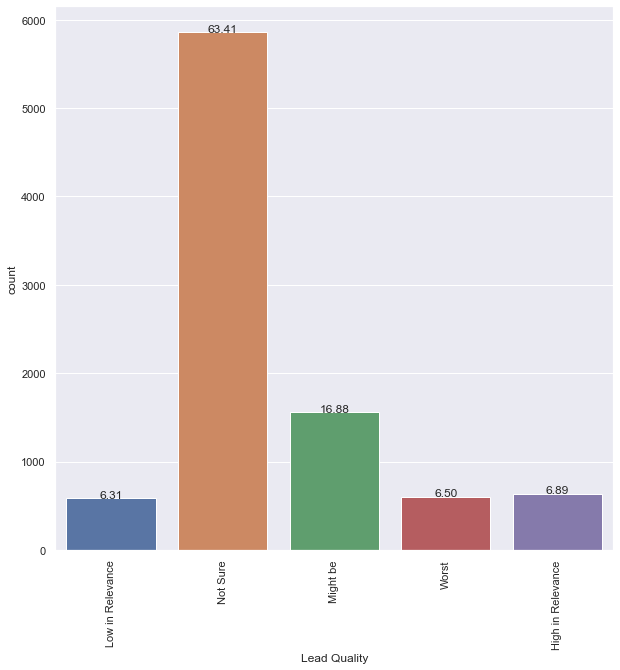

In [22]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Lead Quality', (10,10))

### Observation

From the abover barplot we see that the  number of values for 'Not Sure' are considerable high at 63.14%. We will drop this column further down.

Let us now look at the following columns: Asymmetrique Activity Index, Asymmetrique Profile Index,Asymmetrique Profile Score and Asymmetrique Activity Score. 

We know from the data dictionary that these are scores assigned to a customer based on their activity and profile.

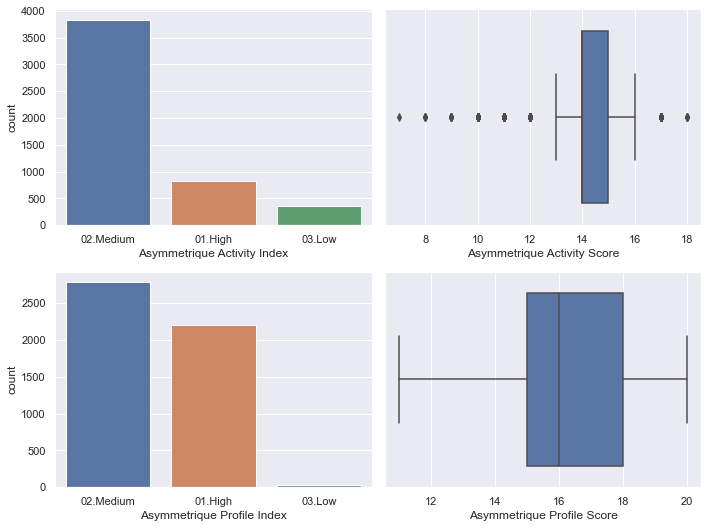

In [23]:
### We will plot box plots and count plots repectively

fig, axs = plt.subplots(2,2, figsize = (10,7.5))
plt1 = sns.countplot(leadScoreDatasetAfterDroppedColumns['Asymmetrique Activity Index'], ax = axs[0,0])
plt2 = sns.boxplot(leadScoreDatasetAfterDroppedColumns['Asymmetrique Activity Score'], ax = axs[0,1])
plt3 = sns.countplot(leadScoreDatasetAfterDroppedColumns['Asymmetrique Profile Index'], ax = axs[1,0])
plt4 = sns.boxplot(leadScoreDatasetAfterDroppedColumns['Asymmetrique Profile Score'], ax = axs[1,1])
plt.tight_layout()

### Observation 

There is a lot of variation in the data and the number of null values is also very high at 45.65%. Therefore we will drop these columns. 

Let us now drop all the 5 columns: Lead quality, Asymmetrique Activity Index, Asymmetrique Activity Score, Asymmetrique Profile Index and Asymmetrique Profile Score. 



In [24]:
colsToDrop = ['Lead Quality', 'Asymmetrique Activity Index','Asymmetrique Activity Score','Asymmetrique Profile Index','Asymmetrique Profile Score']
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.drop(colsToDrop,axis =1)

leadScoreDatasetAfterDroppedColumns.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization What is your current occupation  \
0     NaN                      NaN                      Unemployed   
1   India                      NaN                      Unemployed   
2   India  Business Administration                         Student   
3   India    Media and Advertising                      Unemployed   
4   India                      NaN                      Unemployed   

  What matters most to you in choosing a course Search Newspaper Article  \
0                       Better Career Prospects     No                No   
1                       Better Career Prospects     No                No   
2                       Better Career Prospects     No                No   
3                       Better Career Prospects     No                No   
4                       Better Career Prospects     No                No   

  X Education Forums Newspaper Digital Advertisement Through Recommendations  \
0                 No        No                    No                      No   
1                 No        No                    No                      No   
2                 No        No                    No                      No   
3                 No        No                    No                      No   
4                 No        No                    No                      No   

                                  Tags    City  \
0          Interested in other courses     NaN   
1                              Ringing     NaN   
2  Will revert after reading the email  Mumbai   
3                              Ringing  Mumbai   
4  Will revert after reading the email  Mumbai   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified

In [25]:
leadScoreDatasetAfterDroppedColumns.shape

(9240, 25)

In [26]:
### Let us now assess the percentage of missing values in the remaining dataframe
generateNullValuesPercentageTable(leadScoreDatasetAfterDroppedColumns)

Total Null Values  \
City                                                        3669   
Specialization                                              3380   
Tags                                                        3353   
What matters most to you in choosing a course               2709   
What is your current occupation                             2690   
Country                                                     2461   
TotalVisits                                                  137   
Page Views Per Visit                                         137   
Last Activity                                                103   
Lead Source                                                   36   
Total Time Spent on Website                                    0   
Lead Number                                                    0   
Lead Origin                                                    0   
Do Not Email                                                   0   
Do Not Call                                                    0   
Converted                                                      0   
Last Notable Activity                                          0   
A free copy of Mastering The Interview                         0   
Search                                                         0   
Newspaper Article                                              0   
X Education Forums                                             0   
Newspaper                                                      0   
Digital Advertisement                                          0   
Through Recommendations                                        0   
Prospect ID                                                    0   

                                               Percentage of Null Values  
City                                                               39.71  
Specialization                                                     36.58  
Tags                                                               36.29  
What matters most to you in choosing a course                      29.32  
What is your current occupation                                    29.11  
Country                                                            26.63  
TotalVisits                                                         1.48  
Page Views Per Visit                                                1.48  
Last Activity                                                       1.11  
Lead Source                                                         0.39  
Total Time Spent on Website                                         0.00  
Lead Number                                                         0.00  
Lead Origin                                                         0.00  
Do Not Email                                                        0.00  
Do Not Call                                                         0.00  
Converted                                                           0.00  
Last Notable Activity                                               0.00  
A free copy of Mastering The Interview                              0.00  
Search                                                              0.00  
Newspaper Article                                                   0.00  
X Education Forums                                                  0.00  
Newspaper                                                           0.00  
Digital Advertisement                                               0.00  
Through Recommendations                                             0.00  
Prospect ID                                                         0.00

### Observation

We observe that there are still a few columns with a high percentage of null values, i.e. above 30%. 

Let us explore these columns individually to decide if they are important for us to keep or not. 

### City

In [27]:
### Exploring 'City' column

leadScoreDatasetAfterDroppedColumns.City.describe()

count       5571
unique         6
top       Mumbai
freq        3222
Name: City, dtype: object

In [28]:
leadScoreDatasetAfterDroppedColumns.City.value_counts(normalize=True)

Mumbai                         0.578352
Thane & Outskirts              0.134985
Other Cities                   0.123138
Other Cities of Maharashtra    0.082032
Other Metro Cities             0.068210
Tier II Cities                 0.013283
Name: City, dtype: float64

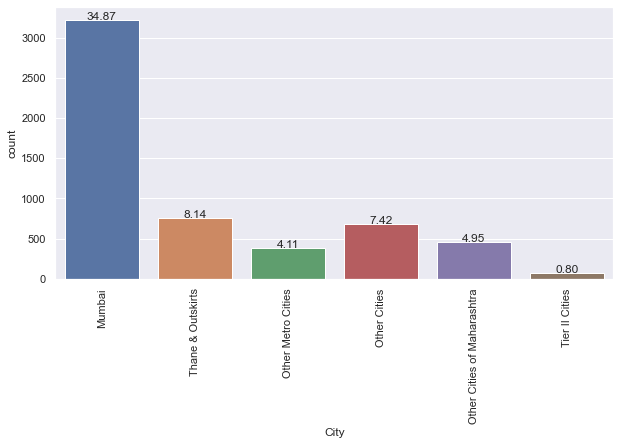

In [29]:
## From the above we can see that the value 'Mumbai' has the most number of enteries
## Let us plot the same

generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'City', (10,5))

### Observation

We shall impute the missing values with 'Mumbai' since it has the highest count. 

In [30]:
leadScoreDatasetAfterDroppedColumns.City = leadScoreDatasetAfterDroppedColumns.City.fillna('Mumbai')

In [31]:
leadScoreDatasetAfterDroppedColumns.City.value_counts(normalize=True)

Mumbai                         0.745779
Thane & Outskirts              0.081385
Other Cities                   0.074242
Other Cities of Maharashtra    0.049459
Other Metro Cities             0.041126
Tier II Cities                 0.008009
Name: City, dtype: float64

### Specialization

In [32]:
### Exploring 'Specialization' column which hs 36.58% null values
leadScoreDatasetAfterDroppedColumns.Specialization.describe()

count                   5860
unique                    18
top       Finance Management
freq                     976
Name: Specialization, dtype: object

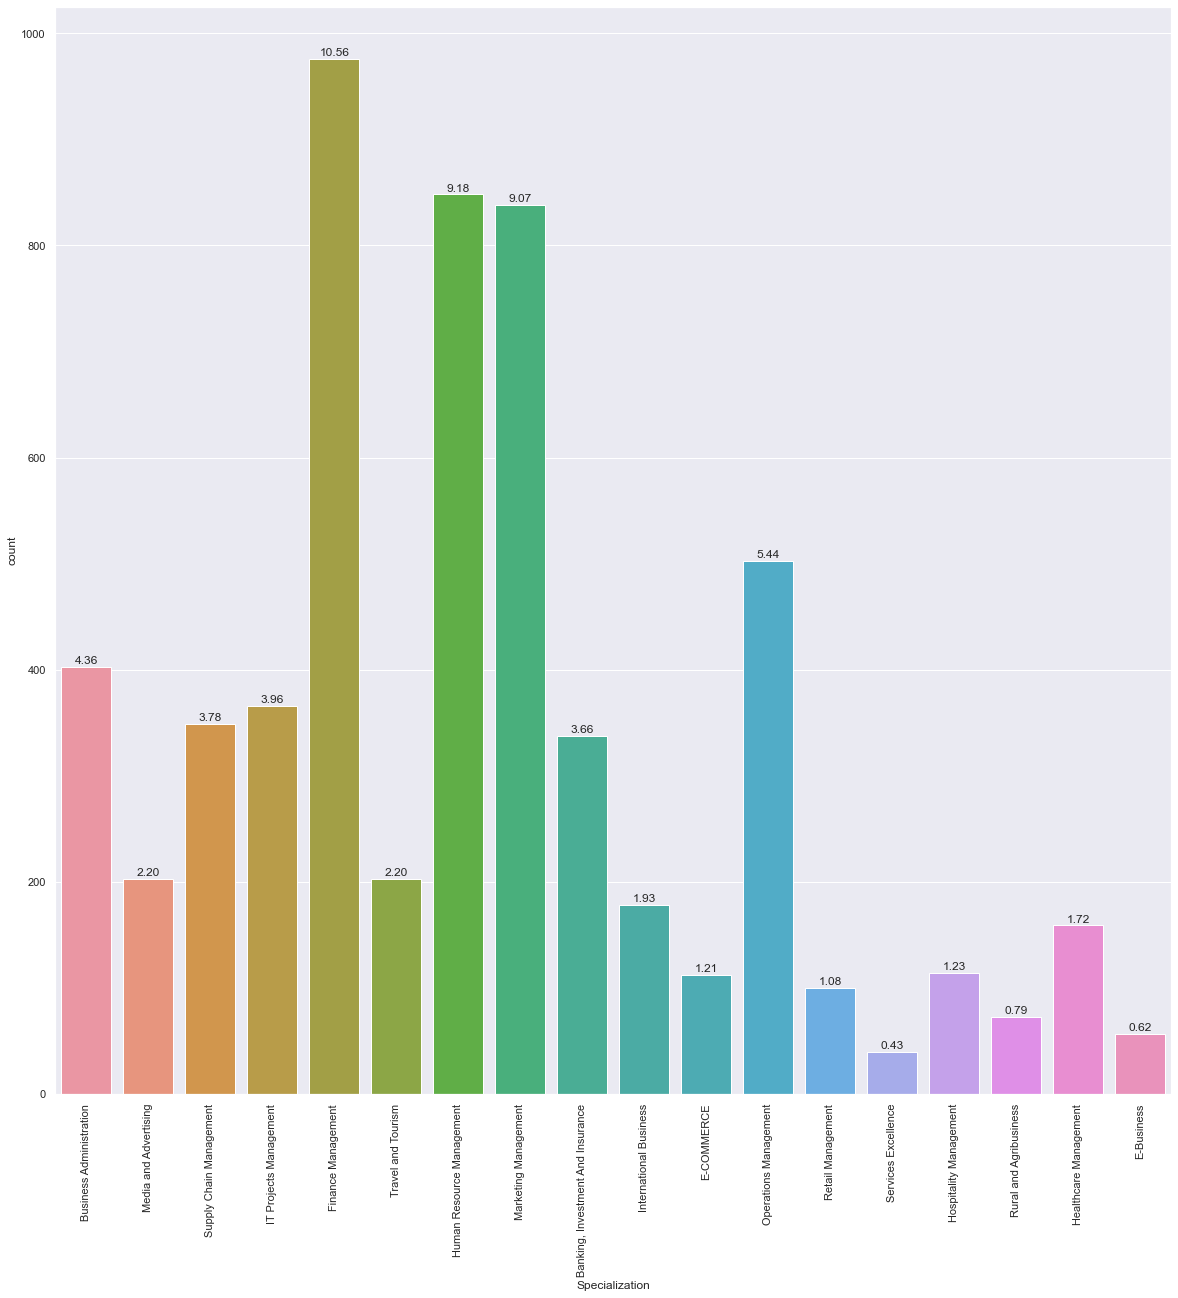

In [33]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns,'Specialization', (20,20))

#### Note:
Since there are 36% null values that haven't yet been accounted for, we will replace those with 'Others'. This is being done because the NaN values have the highest percentage of values that haven't been shown above. It simply means that the user did not have any option relevant to them in this field. 

In [34]:
### Replacing missing values with 'Others'

leadScoreDatasetAfterDroppedColumns.Specialization = leadScoreDatasetAfterDroppedColumns.Specialization.fillna('Others')

leadScoreDatasetAfterDroppedColumns.Specialization.value_counts(normalize=True)

Others                               0.365801
Finance Management                   0.105628
Human Resource Management            0.091775
Marketing Management                 0.090693
Operations Management                0.054437
Business Administration              0.043615
IT Projects Management               0.039610
Supply Chain Management              0.037771
Banking, Investment And Insurance    0.036580
Media and Advertising                0.021970
Travel and Tourism                   0.021970
International Business               0.019264
Healthcare Management                0.017208
Hospitality Management               0.012338
E-COMMERCE                           0.012121
Retail Management                    0.010823
Rural and Agribusiness               0.007900
E-Business                           0.006169
Services Excellence                  0.004329
Name: Specialization, dtype: float64

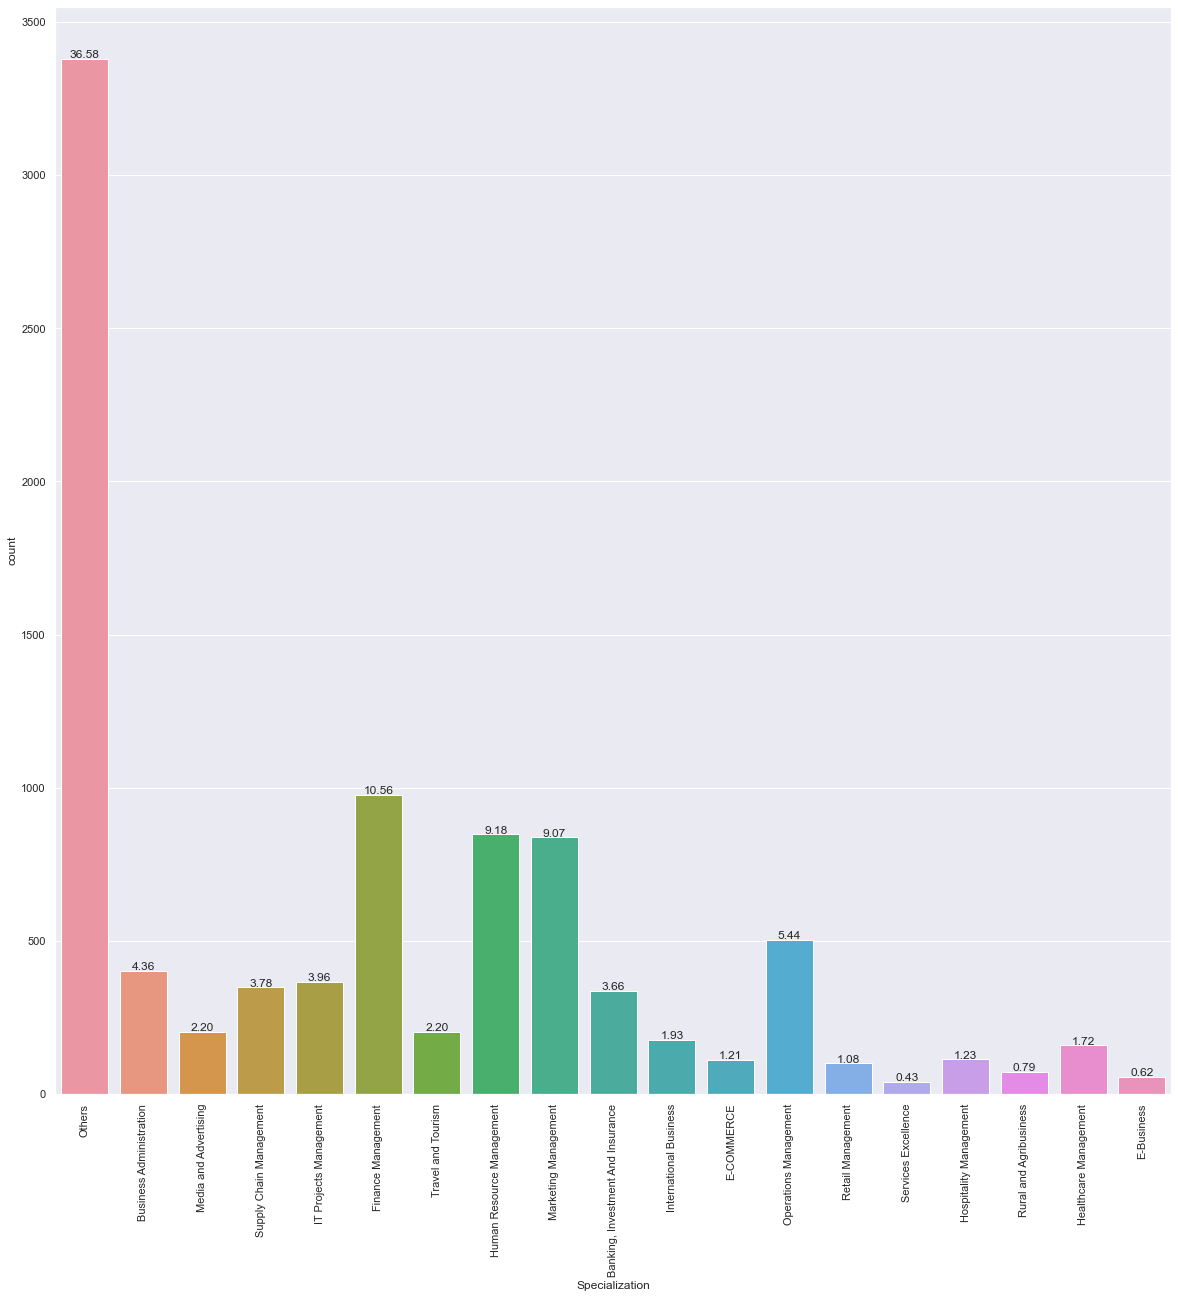

In [35]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns,'Specialization', (20,20))

<Figure size 2880x2160 with 0 Axes>

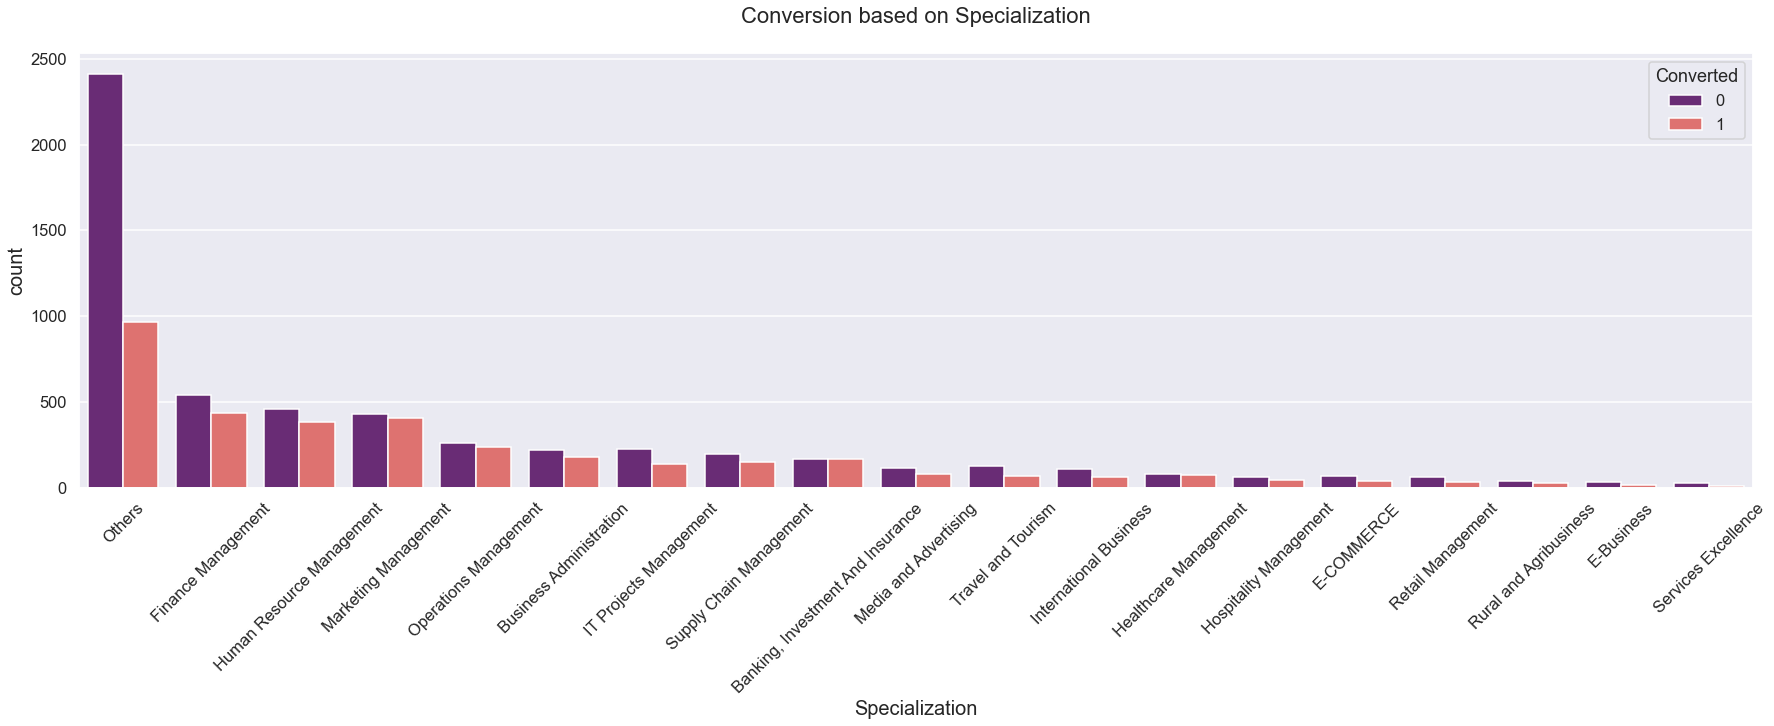

Converted                             0    1  Conversion(%)
Specialization                                             
Healthcare Management                80   79           50.0
Banking, Investment And Insurance   171  167           49.0
Marketing Management                430  408           49.0
Operations Management               265  238           47.0
Human Resource Management           460  388           46.0
Finance Management                  540  436           45.0
Business Administration             224  179           44.0
Supply Chain Management             198  151           43.0
Rural and Agribusiness               42   31           42.0
Hospitality Management               66   48           42.0
Media and Advertising               118   85           42.0
IT Projects Management              226  140           38.0
E-Business                           36   21           37.0
International Business              114   64           36.0
E-COMMERCE                           72 

In [36]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Specialization', 'Conversion based on Specialization',(40,30), 'Converted')

### Tags

In [37]:
### The last column with a high percentage of null values is Tags. Let us explore this column

leadScoreDatasetAfterDroppedColumns.Tags.describe()

count                                    5887
unique                                     26
top       Will revert after reading the email
freq                                     2072
Name: Tags, dtype: object

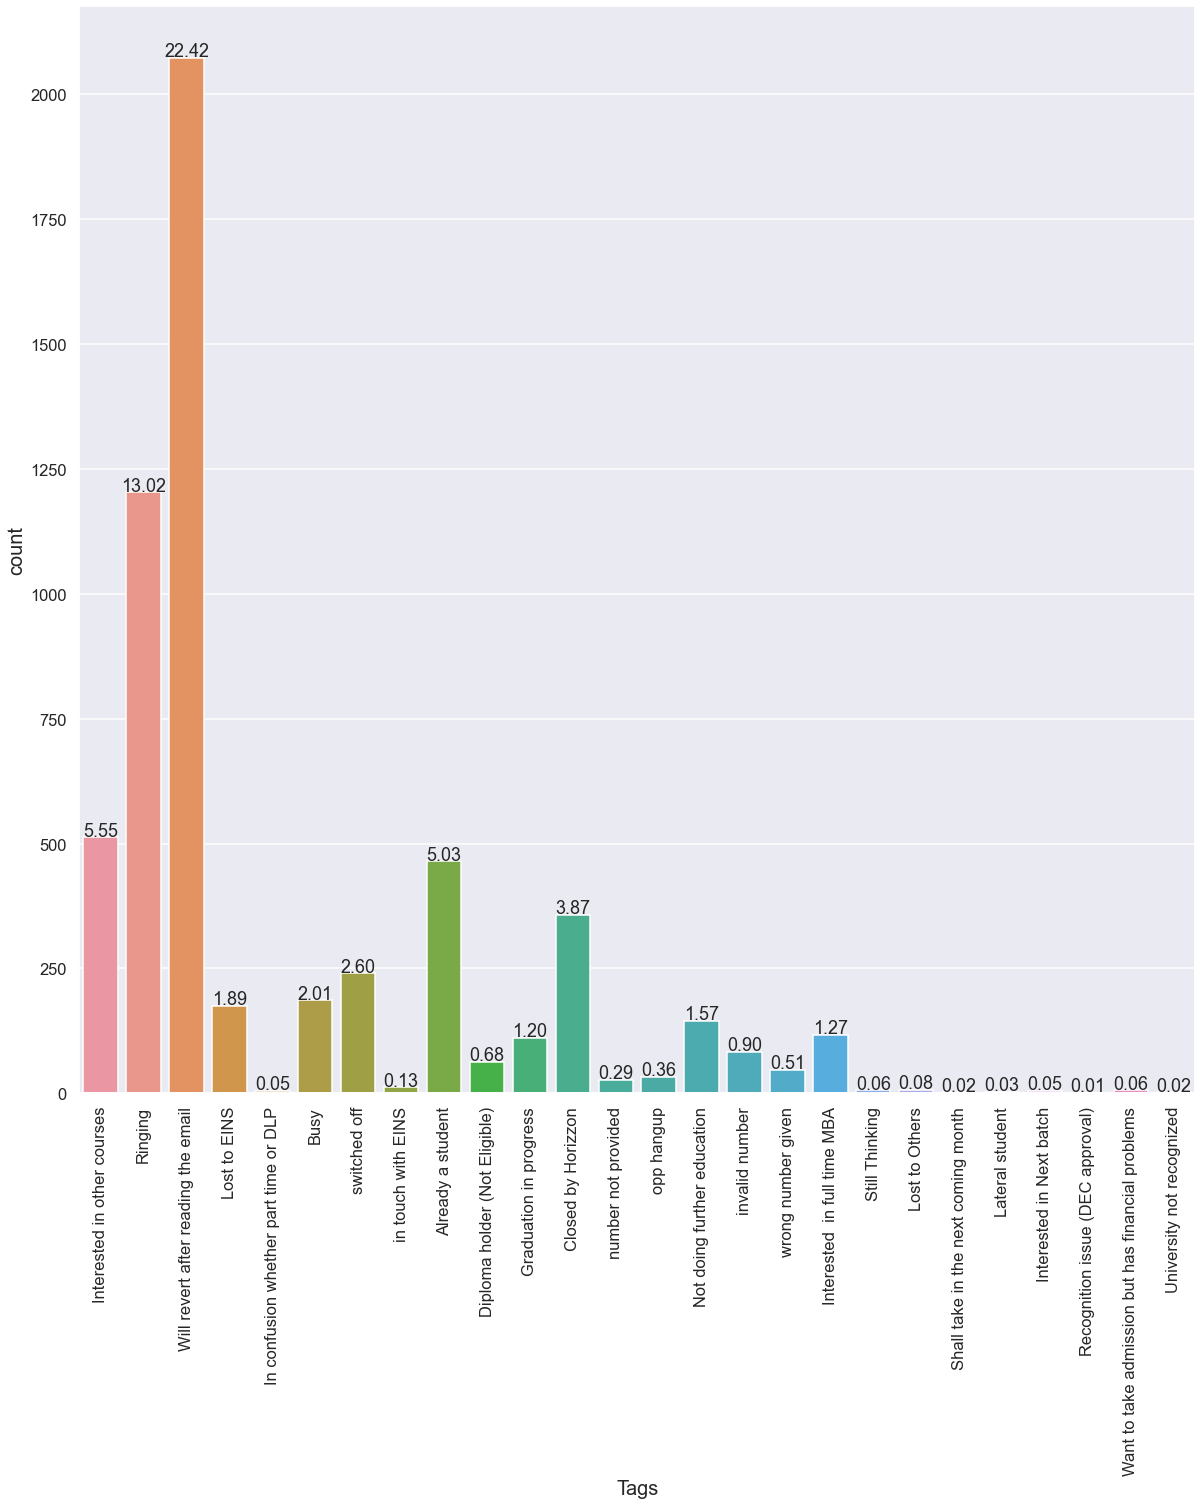

In [38]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns,'Tags', (20,20))

#### Observation

From the above bar plot it looks like we have a lot of small categories within the tags section. Moreover these tags are added by the sales team and are therefore arbitrary in nature. We can safely drop this column as this doesn't provide a lot of insight. 

In [39]:
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.drop('Tags', axis=1)

leadScoreDatasetAfterDroppedColumns.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization What is your current occupation  \
0     NaN                   Others                      Unemployed   
1   India                   Others                      Unemployed   
2   India  Business Administration                         Student   
3   India    Media and Advertising                      Unemployed   
4   India                   Others                      Unemployed   

  What matters most to you in choosing a course Search Newspaper Article  \
0                       Better Career Prospects     No                No   
1                       Better Career Prospects     No                No   
2                       Better Career Prospects     No                No   
3                       Better Career Prospects     No                No   
4                       Better Career Prospects     No                No   

  X Education Forums Newspaper Digital Advertisement Through Recommendations  \
0                 No        No                    No                      No   
1                 No        No                    No                      No   
2                 No        No                    No                      No   
3                 No        No                    No                      No   
4                 No        No                    No                      No   

     City A free copy of Mastering The Interview Last Notable Activity  
0  Mumbai                                     No              Modified  
1  Mumbai                                     No          Email Opened  
2  Mumbai                                    Yes          Email Opened  
3  Mumbai                                     No              Modified  
4  Mumbai                                     No              Modified

In [40]:
leadScoreDatasetAfterDroppedColumns.shape

(9240, 24)

In [41]:
### Let us check the null percentage of the dataframe now
generateNullValuesPercentageTable(leadScoreDatasetAfterDroppedColumns)

Total Null Values  \
What matters most to you in choosing a course               2709   
What is your current occupation                             2690   
Country                                                     2461   
TotalVisits                                                  137   
Page Views Per Visit                                         137   
Last Activity                                                103   
Lead Source                                                   36   
Lead Number                                                    0   
Lead Origin                                                    0   
Do Not Email                                                   0   
Do Not Call                                                    0   
Converted                                                      0   
Total Time Spent on Website                                    0   
Last Notable Activity                                          0   
A free copy of Mastering The Interview                         0   
Specialization                                                 0   
Search                                                         0   
Newspaper Article                                              0   
X Education Forums                                             0   
Newspaper                                                      0   
Digital Advertisement                                          0   
Through Recommendations                                        0   
City                                                           0   
Prospect ID                                                    0   

                                               Percentage of Null Values  
What matters most to you in choosing a course                      29.32  
What is your current occupation                                    29.11  
Country                                                            26.63  
TotalVisits                                                         1.48  
Page Views Per Visit                                                1.48  
Last Activity                                                       1.11  
Lead Source                                                         0.39  
Lead Number                                                         0.00  
Lead Origin                                                         0.00  
Do Not Email                                                        0.00  
Do Not Call                                                         0.00  
Converted                                                           0.00  
Total Time Spent on Website                                         0.00  
Last Notable Activity                                               0.00  
A free copy of Mastering The Interview                              0.00  
Specialization                                                      0.00  
Search                                                              0.00  
Newspaper Article                                                   0.00  
X Education Forums                                                  0.00  
Newspaper                                                           0.00  
Digital Advertisement                                               0.00  
Through Recommendations                                             0.00  
City                                                                0.00  
Prospect ID                                                         0.00

### Observation
We still have a few columns that have a high number of null values. Let us explore those

#### What matters most to you in choosing a course	

In [42]:
leadScoreDatasetAfterDroppedColumns['What matters most to you in choosing a course'].value_counts(normalize=True)

Better Career Prospects      0.999541
Flexibility & Convenience    0.000306
Other                        0.000153
Name: What matters most to you in choosing a course, dtype: float64

#### Observation

We can clearly see that this column is heavily skewed towards better career prospects. Since it doesn't really provide any more information, we can drop this column and keep note that all candidates that take this course are looking to have a better career. 

In [43]:
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.drop('What matters most to you in choosing a course', axis=1)
leadScoreDatasetAfterDroppedColumns.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization What is your current occupation Search  \
0     NaN                   Others                      Unemployed     No   
1   India                   Others                      Unemployed     No   
2   India  Business Administration                         Student     No   
3   India    Media and Advertising                      Unemployed     No   
4   India                   Others                      Unemployed     No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations    City A free copy of Mastering The Interview  \
0                      No  Mumbai                                     No   
1                      No  Mumbai                                     No   
2                      No  Mumbai                                    Yes   
3                      No  Mumbai                                     No   
4                      No  Mumbai                                     No   

  Last Notable Activity  
0              Modified  
1          Email Opened  
2          Email Opened  
3              Modified  
4              Modified

In [44]:
leadScoreDatasetAfterDroppedColumns.shape

(9240, 23)

#### What is your current occupation

In [45]:
leadScoreDatasetAfterDroppedColumns['What is your current occupation'].value_counts(normalize=True)

Unemployed              0.854962
Working Professional    0.107786
Student                 0.032061
Other                   0.002443
Housewife               0.001527
Businessman             0.001221
Name: What is your current occupation, dtype: float64

#### Observation
The data in this column looks skewed, however, it also defines potential target market for company X.
We will impute the missing values with 'Unemployed' and drop the column if analysis further down deems it necessary

In [46]:
leadScoreDatasetAfterDroppedColumns['What is your current occupation'] = leadScoreDatasetAfterDroppedColumns['What is your current occupation'].fillna('Unemployed')
leadScoreDatasetAfterDroppedColumns['What is your current occupation'].value_counts(normalize=True)

Unemployed              0.897186
Working Professional    0.076407
Student                 0.022727
Other                   0.001732
Housewife               0.001082
Businessman             0.000866
Name: What is your current occupation, dtype: float64

#### Country

In [47]:
leadScoreDatasetAfterDroppedColumns.Country.value_counts().head(5)

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
Name: Country, dtype: int64

##### Note

Since a mode value for this column is India, we can replace the missing values with India. Since this will potentially skew the data heavily in the model we will drop this column. 

In [48]:
leadScoreDatasetAfterDroppedColumns.Country = leadScoreDatasetAfterDroppedColumns.Country.fillna('India')
leadScoreDatasetAfterDroppedColumns.Country.value_counts().head(5)

India                   8953
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
Name: Country, dtype: int64

In [49]:
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.drop('Country', axis=1)
leadScoreDatasetAfterDroppedColumns.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

            Specialization What is your current occupation Search  \
0                   Others                      Unemployed     No   
1                   Others                      Unemployed     No   
2  Business Administration                         Student     No   
3    Media and Advertising                      Unemployed     No   
4                   Others                      Unemployed     No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations    City A free copy of Mastering The Interview  \
0                      No  Mumbai                                     No   
1                      No  Mumbai                                     No   
2                      No  Mumbai                                    Yes   
3                      No  Mumbai                                     No   
4                      No  Mumbai                                     No   

  Last Notable Activity  
0              Modified  
1          Email Opened  
2          Email Opened  
3              Modified  
4              Modified

In [50]:
leadScoreDatasetAfterDroppedColumns.shape

(9240, 22)

#### Let us again observe the null values in the dataframe

In [51]:
generateNullValuesPercentageTable(leadScoreDatasetAfterDroppedColumns)

Total Null Values  \
TotalVisits                                           137   
Page Views Per Visit                                  137   
Last Activity                                         103   
Lead Source                                            36   
A free copy of Mastering The Interview                  0   
Lead Number                                             0   
Lead Origin                                             0   
Do Not Email                                            0   
Do Not Call                                             0   
Converted                                               0   
Total Time Spent on Website                             0   
Last Notable Activity                                   0   
Specialization                                          0   
What is your current occupation                         0   
Search                                                  0   
Newspaper Article                                       0   
X Education Forums                                      0   
Newspaper                                               0   
Digital Advertisement                                   0   
Through Recommendations                                 0   
City                                                    0   
Prospect ID                                             0   

                                        Percentage of Null Values  
TotalVisits                                                  1.48  
Page Views Per Visit                                         1.48  
Last Activity                                                1.11  
Lead Source                                                  0.39  
A free copy of Mastering The Interview                       0.00  
Lead Number                                                  0.00  
Lead Origin                                                  0.00  
Do Not Email                                                 0.00  
Do Not Call                                                  0.00  
Converted                                                    0.00  
Total Time Spent on Website                                  0.00  
Last Notable Activity                                        0.00  
Specialization                                               0.00  
What is your current occupation                              0.00  
Search                                                       0.00  
Newspaper Article                                            0.00  
X Education Forums                                           0.00  
Newspaper                                                    0.00  
Digital Advertisement                                        0.00  
Through Recommendations                                      0.00  
City                                                         0.00  
Prospect ID                                                  0.00

### Observation

We have reduced a lot of columns and imputed missing values in a few of them. In the remaining columns we can safely impute the missing value with the mode value since it has less than 5% missing values.

#### Lead Source

In [52]:
### Imputing missing values in Lead Source column
leadScoreDatasetAfterDroppedColumns['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Live Chat               2
Social Media            2
NC_EDM                  1
blog                    1
WeLearn                 1
testone                 1
youtubechannel          1
Pay per Click Ads       1
welearnblog_Home        1
Name: Lead Source, dtype: int64

In [53]:
### Imputing missing values with 'Google'

leadScoreDatasetAfterDroppedColumns['Lead Source'] = leadScoreDatasetAfterDroppedColumns['Lead Source'].fillna('Google')
leadScoreDatasetAfterDroppedColumns['Lead Source'].value_counts()

Google               2904
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Live Chat               2
Social Media            2
NC_EDM                  1
blog                    1
WeLearn                 1
testone                 1
youtubechannel          1
Pay per Click Ads       1
welearnblog_Home        1
Name: Lead Source, dtype: int64

In [54]:
leadScoreDatasetAfterDroppedColumns['Lead Source'] =  leadScoreDatasetAfterDroppedColumns['Lead Source'].apply(lambda x:x.capitalize())

leadScoreDatasetAfterDroppedColumns['Lead Source'].value_counts()

Google               2909
Direct traffic       2543
Olark chat           1755
Organic search       1154
Reference             534
Welingak website      142
Referral sites        125
Facebook               55
Bing                    6
Click2call              4
Social media            2
Live chat               2
Press_release           2
Pay per click ads       1
Welearnblog_home        1
Welearn                 1
Youtubechannel          1
Nc_edm                  1
Testone                 1
Blog                    1
Name: Lead Source, dtype: int64

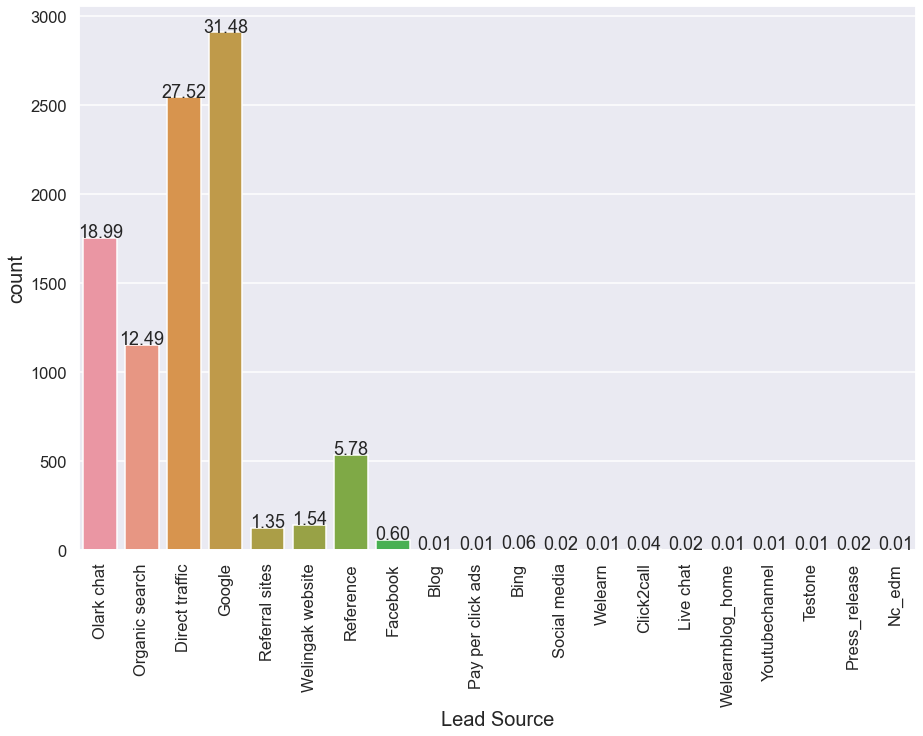

In [55]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns,'Lead Source', (15,10))

<Figure size 3600x2160 with 0 Axes>

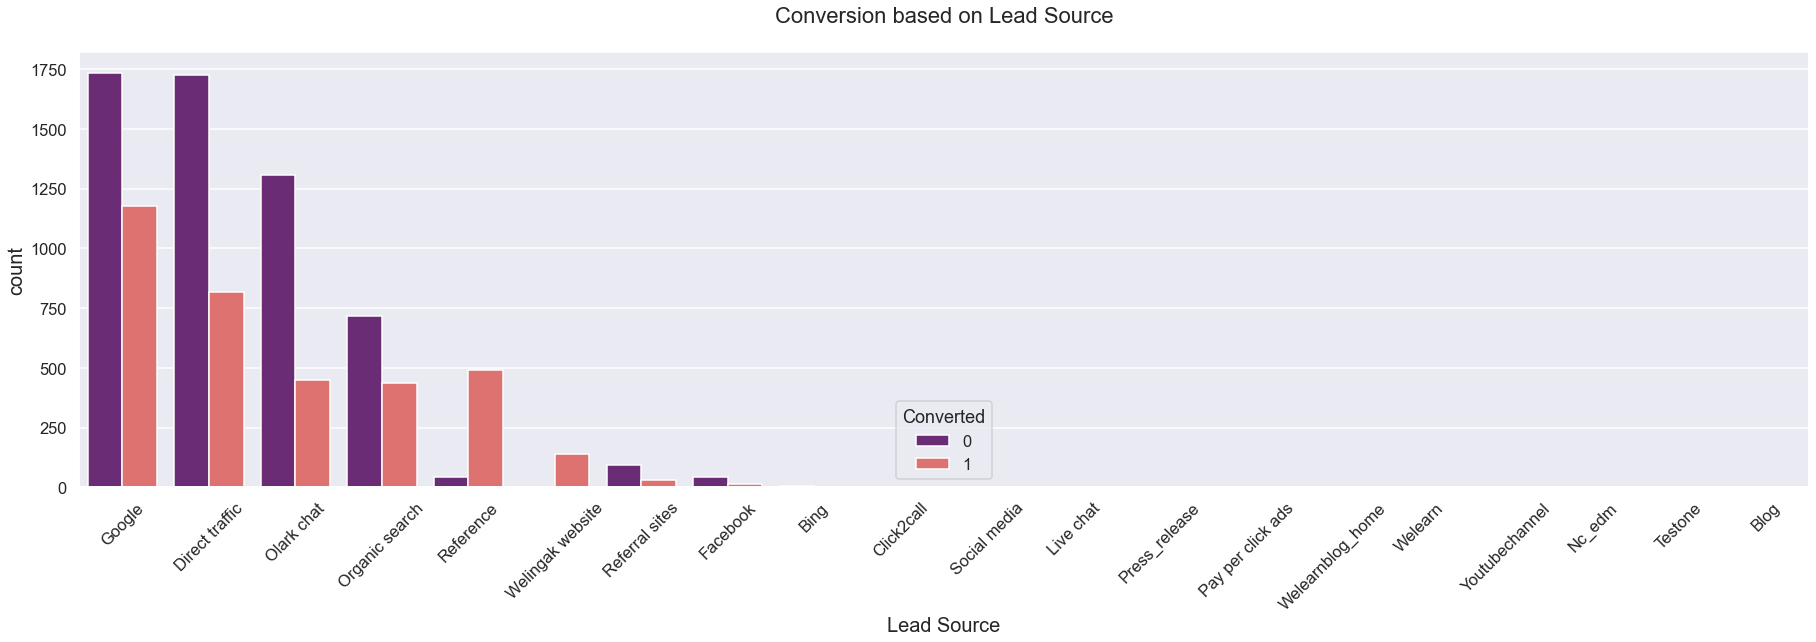

Converted               0       1  Conversion(%)
Lead Source                                     
Welearn               0.0     1.0          100.0
Live chat             0.0     2.0          100.0
Nc_edm                0.0     1.0          100.0
Welingak website      2.0   140.0           99.0
Reference            44.0   490.0           92.0
Click2call            1.0     3.0           75.0
Social media          1.0     1.0           50.0
Google             1733.0  1176.0           40.0
Organic search      718.0   436.0           38.0
Direct traffic     1725.0   818.0           32.0
Olark chat         1307.0   448.0           26.0
Referral sites       94.0    31.0           25.0
Facebook             42.0    13.0           24.0
Bing                  5.0     1.0           17.0
Welearnblog_home      1.0     0.0            0.0
Pay per click ads     1.0     0.0            0.0
Testone               1.0     0.0            0.0
Press_release         2.0     0.0            0.0
Blog                

In [56]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Lead Source', 'Conversion based on Lead Source', (50,30),'Converted')

### Observations

Based on the plots above we observe that:

- Most students found X education via 'Google' search
- However, most of the google search leads weren't converted to actual students of the platform
- References had the highest number of conversions at 92%
- Welingak website also had a significantly high number of conversions at 99%
- Welearn & Nc_edm had 100% conversion but due to their low numbers overall it might not be a correct picture of the situation
- No conversions were made through the youtube channel, blog, press releases, pay per click ads or Welearnblog_home


Let us merge the columns with low numbers into a common category: 'Others'

In [57]:
colsToReplace=['Click2call', 'Live chat', 'Nc_edm', 'Pay per click ads', 'Press_release',
  'Social media', 'Welearn', 'Bing', 'Blog', 'Testone', 'Welearnblog_home', 'Youtubechannel']
leadScoreDatasetAfterDroppedColumns['Lead Source'] = leadScoreDatasetAfterDroppedColumns['Lead Source'].replace(colsToReplace, 'Others')

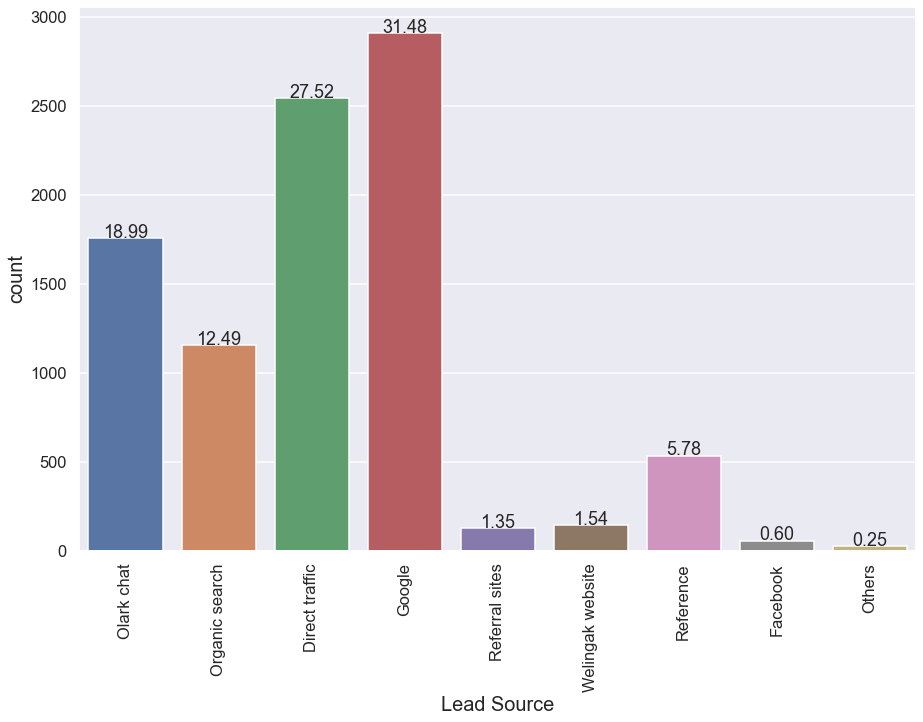

In [58]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns,'Lead Source', (15,10))

In [59]:
leadScoreDatasetAfterDroppedColumns['Lead Source'].value_counts()

Google              2909
Direct traffic      2543
Olark chat          1755
Organic search      1154
Reference            534
Welingak website     142
Referral sites       125
Facebook              55
Others                23
Name: Lead Source, dtype: int64

<Figure size 2880x1440 with 0 Axes>

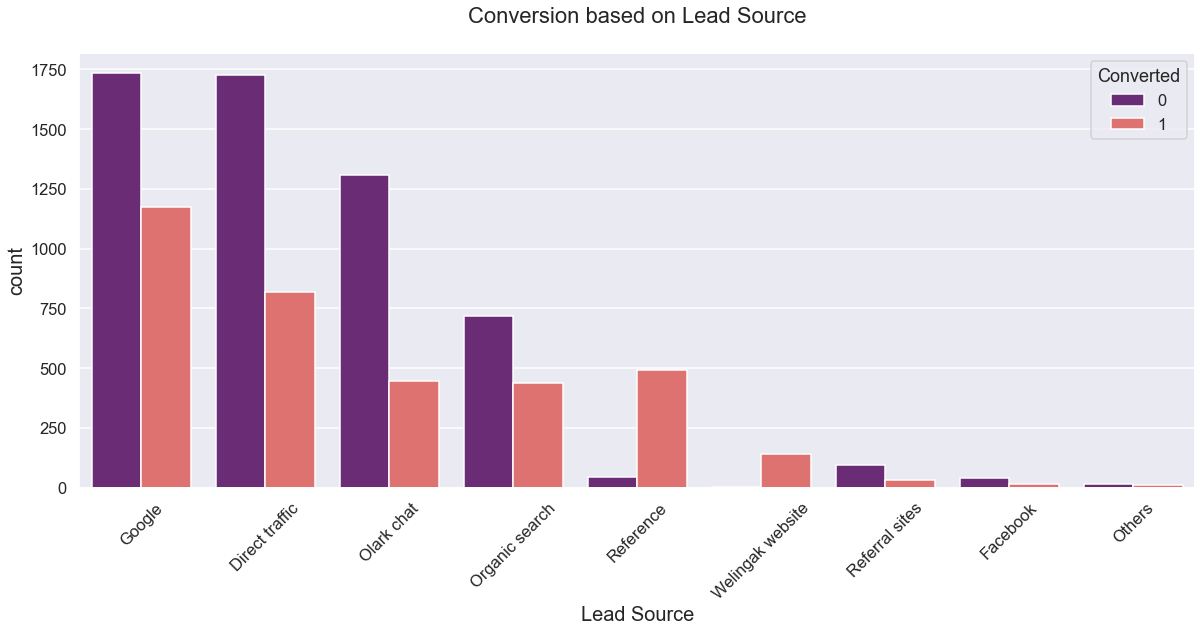

Converted            0     1  Conversion(%)
Lead Source                                
Welingak website     2   140           99.0
Reference           44   490           92.0
Google            1733  1176           40.0
Others              14     9           39.0
Organic search     718   436           38.0
Direct traffic    1725   818           32.0
Olark chat        1307   448           26.0
Referral sites      94    31           25.0
Facebook            42    13           24.0 None


In [60]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Lead Source', 'Conversion based on Lead Source', (40,20),'Converted')

### Observation

To imporve the conversion rate X education should focus on providing incentives to referrals as well as improve the lead conversion through olark chat, organic search, direct traffic, and google leads and generate more leads from reference and welingak website.

#### Last Activity


In [61]:
### Imputing values in Last Activity column
leadScoreDatasetAfterDroppedColumns['Last Activity'].value_counts()

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

In [62]:
#### Imputing the missing values with 'Email Opened'
leadScoreDatasetAfterDroppedColumns['Last Activity'] = leadScoreDatasetAfterDroppedColumns['Last Activity'].fillna('Email Opened')
leadScoreDatasetAfterDroppedColumns['Last Activity'].value_counts()

Email Opened                    3540
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

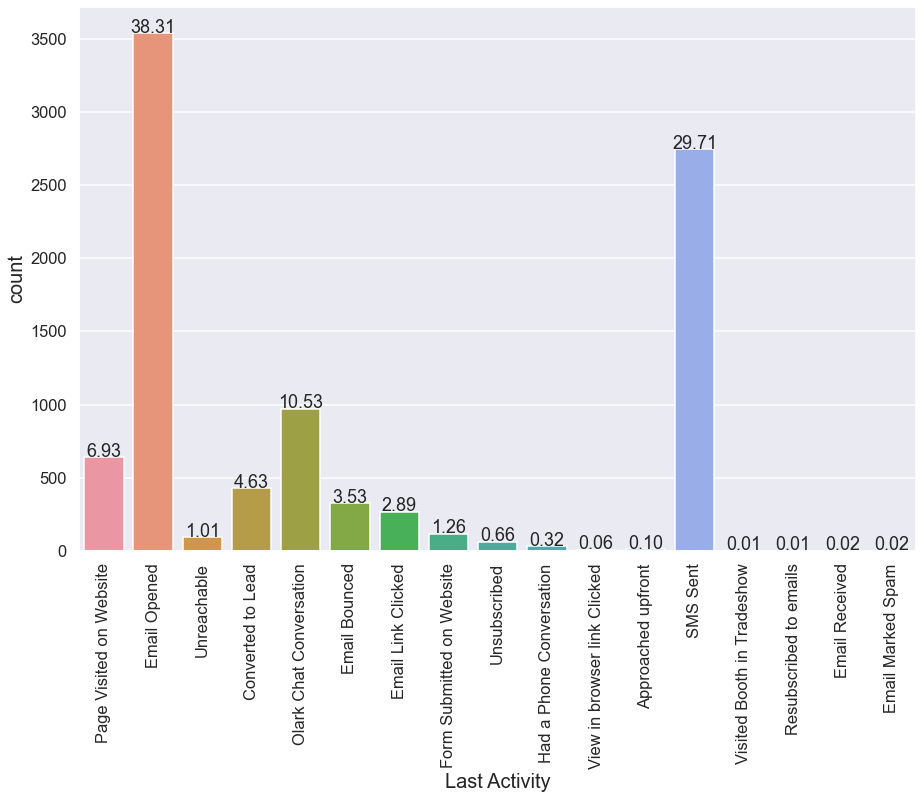

In [63]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns,'Last Activity', (15,10))

<Figure size 2880x2160 with 0 Axes>

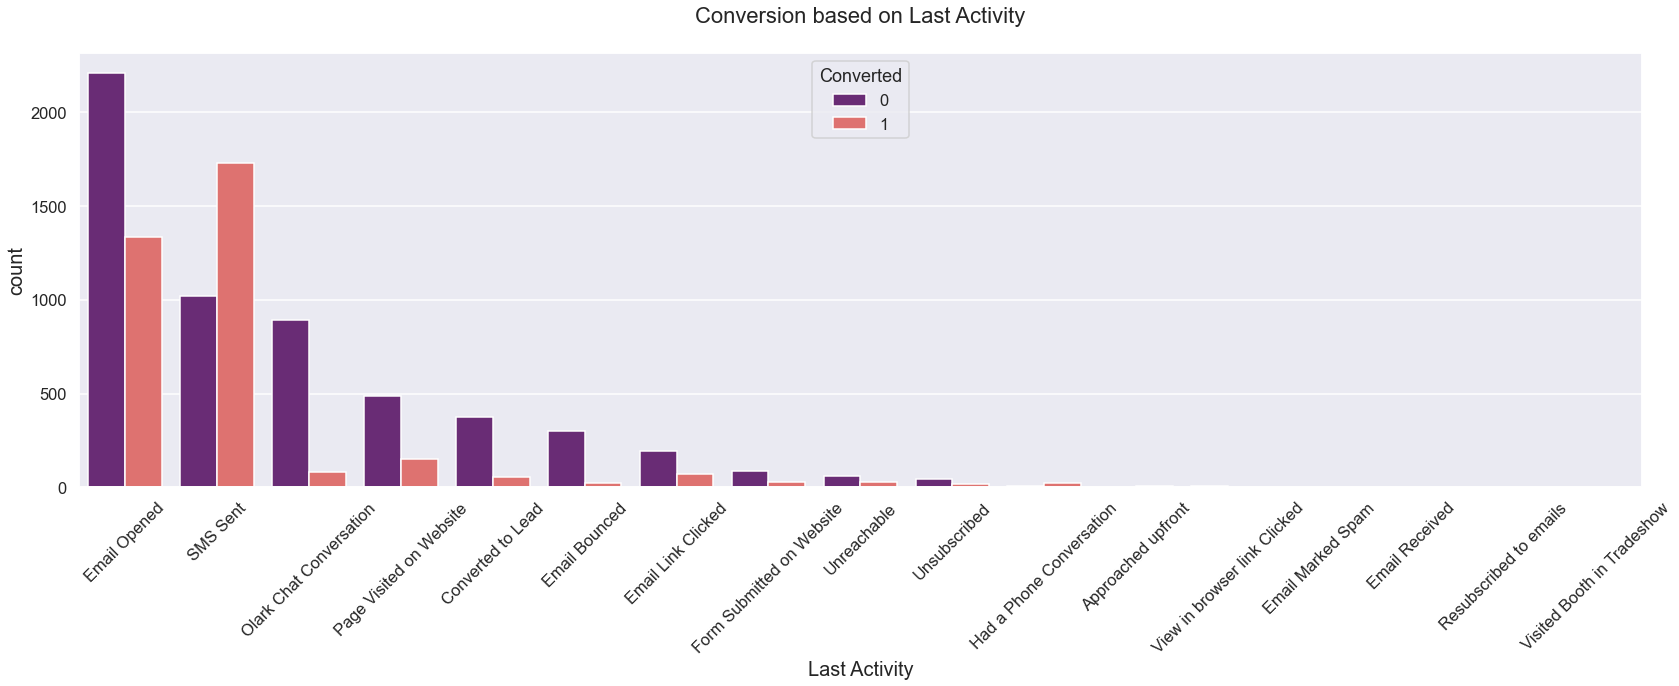

Converted                          0       1  Conversion(%)
Last Activity                                              
Approached upfront               0.0     9.0          100.0
Email Marked Spam                0.0     2.0          100.0
Resubscribed to emails           0.0     1.0          100.0
Email Received                   0.0     2.0          100.0
Had a Phone Conversation         8.0    22.0           73.0
SMS Sent                      1018.0  1727.0           63.0
Email Opened                  2206.0  1334.0           38.0
Unreachable                     62.0    31.0           33.0
Email Link Clicked             194.0    73.0           27.0
Unsubscribed                    45.0    16.0           26.0
Form Submitted on Website       88.0    28.0           24.0
Page Visited on Website        489.0   151.0           24.0
View in browser link Clicked     5.0     1.0           17.0
Converted to Lead              374.0    54.0           13.0
Olark Chat Conversation        889.0    

In [64]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Last Activity', 'Conversion based on Last Activity', (40,30),'Converted')

### Observation

Based on the plots above we can infer that:

- People interacting with the portal usually send sms the most
- Only 24% of people who visit the website convert to actual students


#### Page Views Per Visit

In [65]:
### Imputing values in Page Views Per Visit column
leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'].value_counts().head(15)

0.00    2189
2.00    1795
3.00    1196
4.00     896
1.00     651
5.00     517
1.50     306
6.00     244
2.50     241
7.00     133
3.50      94
8.00      86
1.33      66
1.67      60
2.33      59
Name: Page Views Per Visit, dtype: int64

In [66]:
leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

In [67]:
#### Imputing the missing values with '2.0' which is the median value
leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'] = leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'].replace(np.nan,'2.0')
leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'].value_counts().head(15)

0.0     2189
2.0     1795
3.0     1196
4.0      896
1.0      651
5.0      517
1.5      306
6.0      244
2.5      241
2.0      137
7.0      133
3.5       94
8.0       86
1.33      66
1.67      60
Name: Page Views Per Visit, dtype: int64

In [68]:
### Looks like 0.0 was incorrectly imputed. Let us correct the imputation
leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'] =  leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'].astype(float)

leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'].value_counts()

0.00    2189
2.00    1932
3.00    1196
4.00     896
1.00     651
        ... 
1.27       1
8.21       1
2.14       1
2.63       1
2.45       1
Name: Page Views Per Visit, Length: 114, dtype: int64

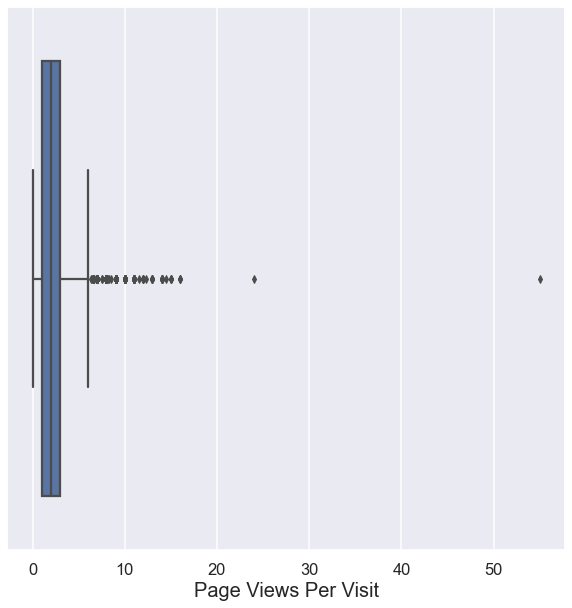

In [69]:
### It looks like there are a lot of outliers in the data, let us verify this using a boxplot
fig, axs = plt.subplots(figsize = (10,10))
sns.boxplot(leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'])

In [70]:
### We will cap our data at the 1% & 95% mark so as to not lose any values or drop rows. 
capValue = leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'].quantile([0.01,0.95]).values
leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'][leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'] <= capValue[0]] = capValue[0]
leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'][leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'] >= capValue[1]] = capValue[1]

leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'].describe(percentiles=[0.01,.25, .5, .75, .90, .95, .99])

count    9240.000000
mean        2.255105
std         1.779471
min         0.000000
1%          0.000000
25%         1.000000
50%         2.000000
75%         3.000000
90%         5.000000
95%         6.000000
99%         6.000000
max         6.000000
Name: Page Views Per Visit, dtype: float64

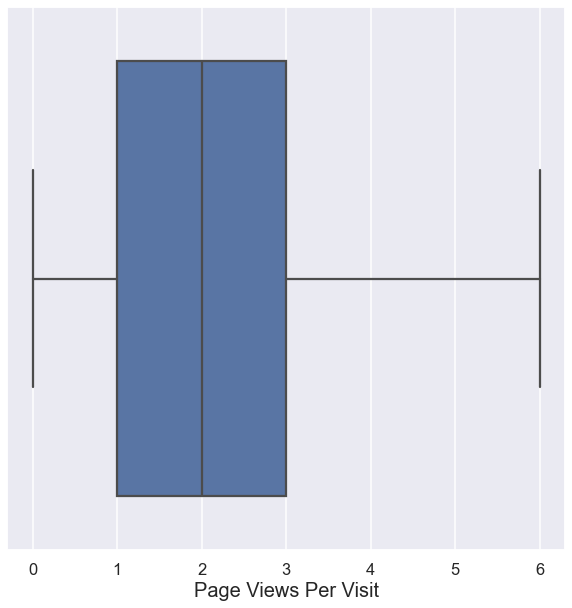

In [71]:
fig, axs = plt.subplots(figsize = (10,10))
sns.boxplot(leadScoreDatasetAfterDroppedColumns['Page Views Per Visit'])

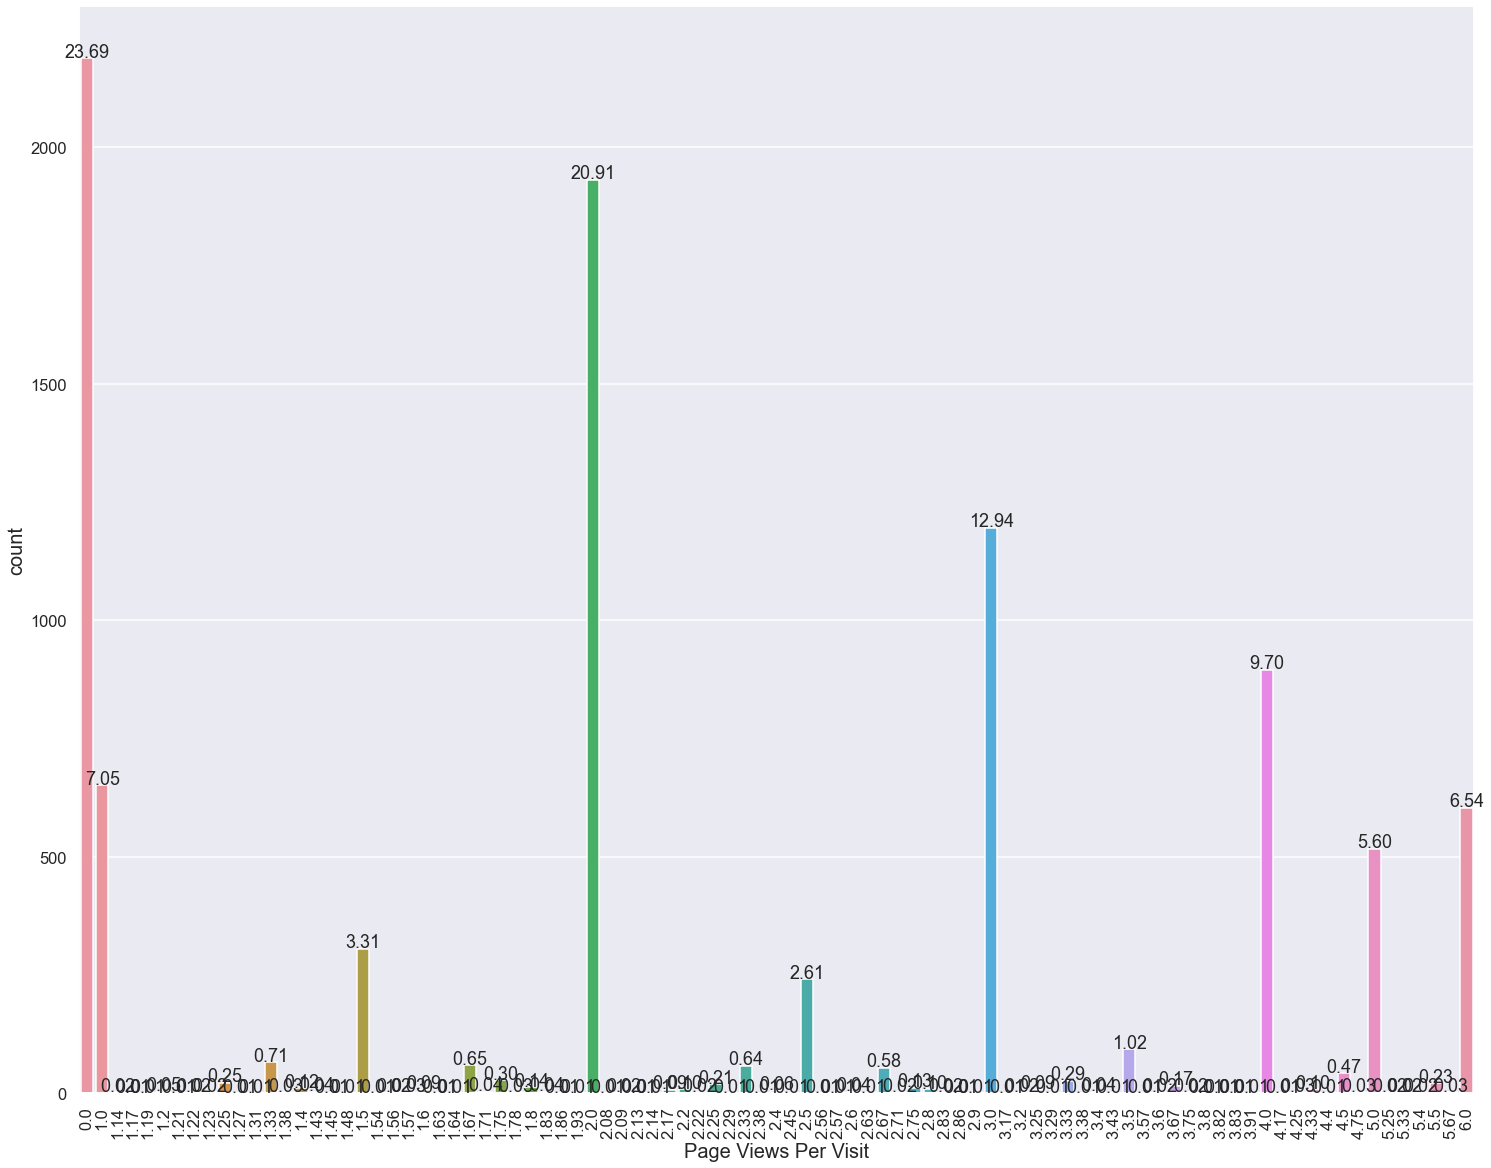

In [72]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns,'Page Views Per Visit', (25,20))

<Figure size 2880x2880 with 0 Axes>

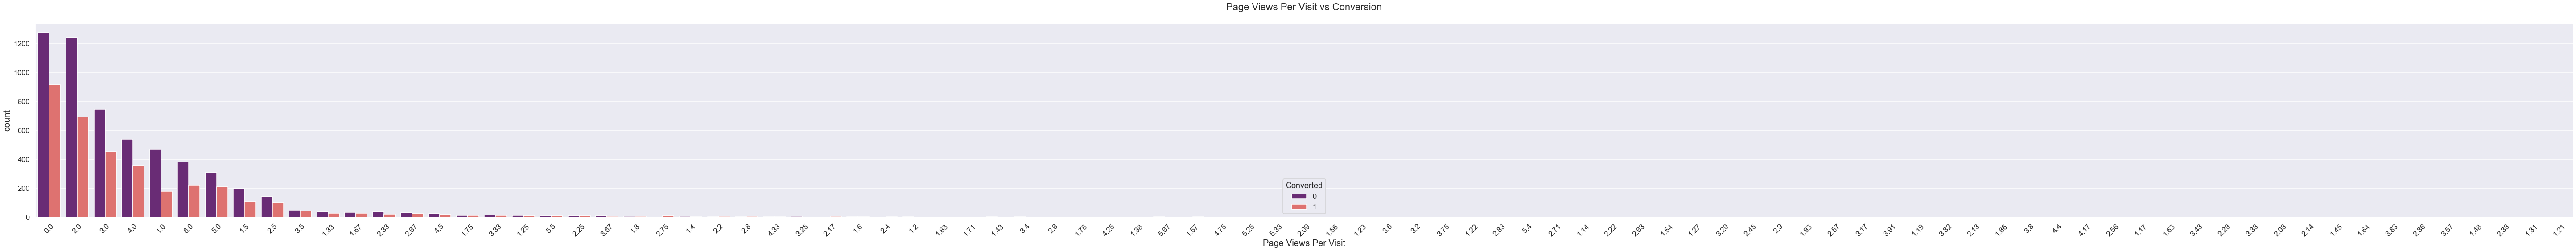

Converted               0    1  Conversion(%)
Page Views Per Visit                         
2.63                  0.0  1.0          100.0
3.29                  0.0  1.0          100.0
1.64                  0.0  1.0          100.0
1.63                  0.0  1.0          100.0
1.93                  0.0  1.0          100.0
...                   ...  ...            ...
3.57                  1.0  0.0            0.0
2.13                  1.0  0.0            0.0
3.40                  4.0  0.0            0.0
3.38                  1.0  0.0            0.0
2.56                  1.0  0.0            0.0

[91 rows x 3 columns] None


In [73]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Page Views Per Visit', 'Page Views Per Visit vs Conversion', (40,40), 'Converted')

#### Observation
We have successfully capped the data at the 95%.
From the above plots it is safe to infer that: 

- People who dont visit any pages have the highest count of conversion overall
- Less than half the people who visit 2 pages on average convert to students

### TotalVisits

In [74]:
leadScoreDatasetAfterDroppedColumns.TotalVisits.describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [75]:
### We will impute this value with the meadian value since the 
### mean and the median values are relatively close to each other
leadScoreDatasetAfterDroppedColumns.TotalVisits = leadScoreDatasetAfterDroppedColumns.TotalVisits.fillna('3.0')
leadScoreDatasetAfterDroppedColumns.TotalVisits.value_counts()

0.0     2189
2.0     1680
3.0     1306
4.0     1120
5.0      783
        ... 
43.0       1
42.0       1
41.0       1
32.0       1
30.0       1
Name: TotalVisits, Length: 42, dtype: int64

In [76]:
### Looks like 3.0 was incorrectly imputed. Let us correct the imputation
leadScoreDatasetAfterDroppedColumns['TotalVisits'] =  leadScoreDatasetAfterDroppedColumns['TotalVisits'].astype(float)

leadScoreDatasetAfterDroppedColumns['TotalVisits'].value_counts()

0.0      2189
2.0      1680
3.0      1443
4.0      1120
5.0       783
         ... 
115.0       1
43.0        1
42.0        1
32.0        1
55.0        1
Name: TotalVisits, Length: 41, dtype: int64

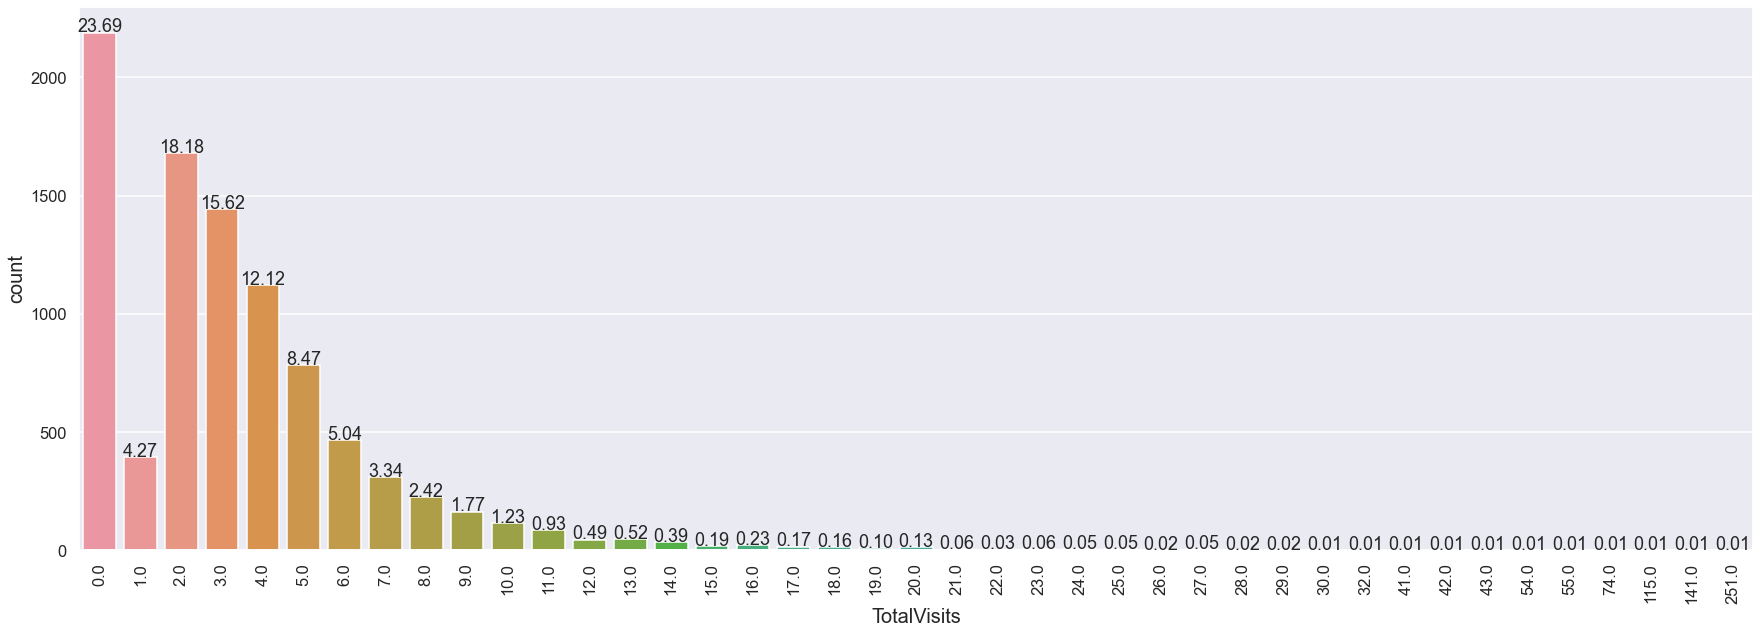

In [77]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'TotalVisits',(30,10))

In [78]:
leadScoreDatasetAfterDroppedColumns['TotalVisits'].describe(percentiles=[0.01,.25, .5, .75, .90, .95, .99])

count    9240.000000
mean        3.438636
std         4.819024
min         0.000000
1%          0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

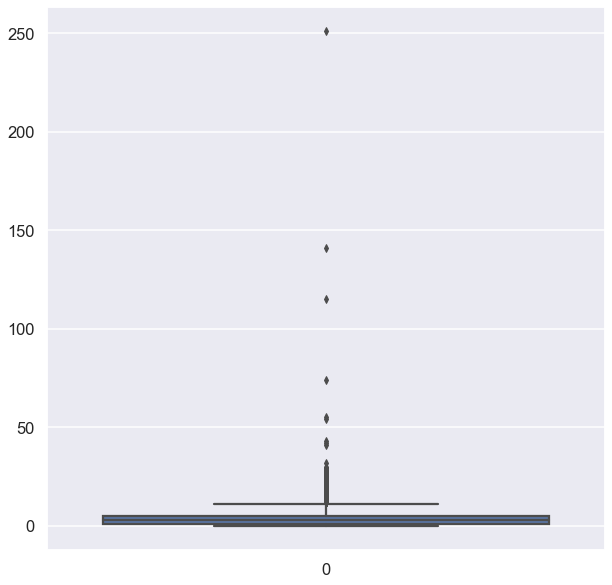

In [79]:
### There seem to be a large number of outliers. Let us check these using a boxplot and decide what to do next
fig, axs = plt.subplots(figsize = (10,10))

sns.boxplot(data=leadScoreDatasetAfterDroppedColumns.TotalVisits)


In [80]:
### We will cap our data at the 1% & 95% mark so as to not lose any values or drop rows. 
capValue = leadScoreDatasetAfterDroppedColumns.TotalVisits.quantile([0.01,0.95]).values
leadScoreDatasetAfterDroppedColumns.TotalVisits[leadScoreDatasetAfterDroppedColumns.TotalVisits <= capValue[0]] = capValue[0]
leadScoreDatasetAfterDroppedColumns.TotalVisits[leadScoreDatasetAfterDroppedColumns.TotalVisits >= capValue[1]] = capValue[1]

leadScoreDatasetAfterDroppedColumns.TotalVisits.describe(percentiles=[0.01,.25, .5, .75, .90, .95, .99])

count    9240.000000
mean        3.179221
std         2.761219
min         0.000000
1%          0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        10.000000
max        10.000000
Name: TotalVisits, dtype: float64

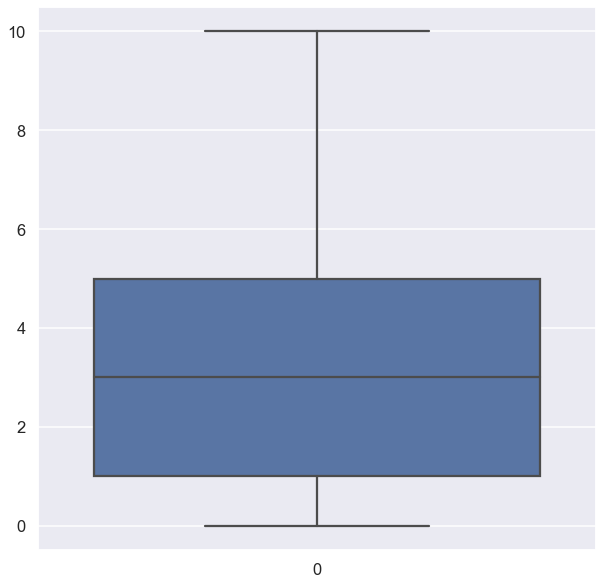

In [81]:
fig, axs = plt.subplots(figsize = (10,10))

sns.boxplot(data=leadScoreDatasetAfterDroppedColumns.TotalVisits)


<Figure size 2880x1440 with 0 Axes>

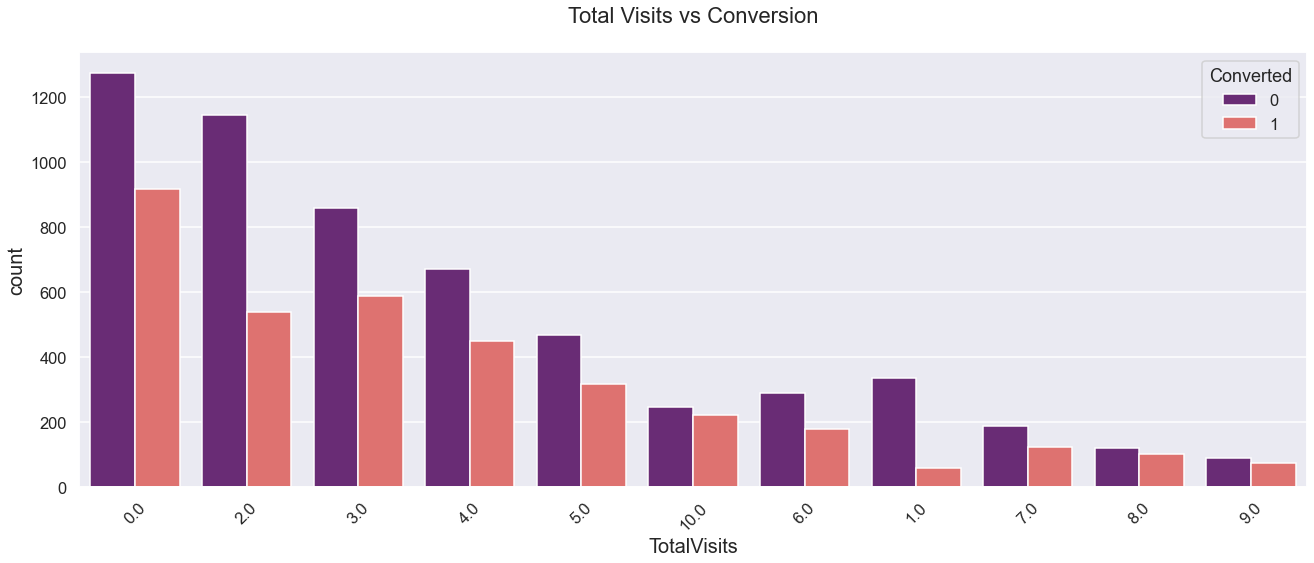

Converted       0    1  Conversion(%)
TotalVisits                          
10.0          245  222           48.0
8.0           121  103           46.0
9.0            91   73           45.0
0.0          1273  916           42.0
3.0           857  586           41.0
4.0           672  448           40.0
5.0           467  316           40.0
7.0           187  122           39.0
6.0           288  178           38.0
2.0          1143  537           32.0
1.0           335   60           15.0 None


In [82]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'TotalVisits', 'Total Visits vs Conversion', (40,20), 'Converted')

### Observations

From the above analysis we can conclude that:

- People who make more than 10 visits are almost 50% likely to apply for a course
- Only 15% of people who visited the website converted to student. This could imply that people weren't able to gather all the information they needed easily. Hence, decided not to opt for any course. 

In [83]:
### Assessing if there are any more missing values in the data
generateNullValuesPercentageTable(leadScoreDatasetAfterDroppedColumns)

Total Null Values  \
Last Notable Activity                                   0   
A free copy of Mastering The Interview                  0   
Lead Number                                             0   
Lead Origin                                             0   
Lead Source                                             0   
Do Not Email                                            0   
Do Not Call                                             0   
Converted                                               0   
TotalVisits                                             0   
Total Time Spent on Website                             0   
Page Views Per Visit                                    0   
Last Activity                                           0   
Specialization                                          0   
What is your current occupation                         0   
Search                                                  0   
Newspaper Article                                       0   
X Education Forums                                      0   
Newspaper                                               0   
Digital Advertisement                                   0   
Through Recommendations                                 0   
City                                                    0   
Prospect ID                                             0   

                                        Percentage of Null Values  
Last Notable Activity                                         0.0  
A free copy of Mastering The Interview                        0.0  
Lead Number                                                   0.0  
Lead Origin                                                   0.0  
Lead Source                                                   0.0  
Do Not Email                                                  0.0  
Do Not Call                                                   0.0  
Converted                                                     0.0  
TotalVisits                                                   0.0  
Total Time Spent on Website                                   0.0  
Page Views Per Visit                                          0.0  
Last Activity                                                 0.0  
Specialization                                                0.0  
What is your current occupation                               0.0  
Search                                                        0.0  
Newspaper Article                                             0.0  
X Education Forums                                            0.0  
Newspaper                                                     0.0  
Digital Advertisement                                         0.0  
Through Recommendations                                       0.0  
City                                                          0.0  
Prospect ID                                                   0.0

### Observation

Now that there are no missing values in the dataset we can proceed with our next analysis.

In [84]:
### We can also drop the column 'Prospect ID' as we already have an identifying column with unique values: 'Lead Number'
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.drop('Prospect ID', axis=1)
leadScoreDatasetAfterDroppedColumns.head()

Lead Number              Lead Origin     Lead Source Do Not Email  \
0       660737                      API      Olark chat           No   
1       660728                      API  Organic search           No   
2       660727  Landing Page Submission  Direct traffic           No   
3       660719  Landing Page Submission  Direct traffic           No   
4       660681  Landing Page Submission          Google           No   

  Do Not Call  Converted  TotalVisits  Total Time Spent on Website  \
0          No          0          0.0                            0   
1          No          0          5.0                          674   
2          No          1          2.0                         1532   
3          No          0          1.0                          305   
4          No          1          2.0                         1428   

   Page Views Per Visit            Last Activity           Specialization  \
0                   0.0  Page Visited on Website                   Others   
1                   2.5             Email Opened                   Others   
2                   2.0             Email Opened  Business Administration   
3                   1.0              Unreachable    Media and Advertising   
4                   1.0        Converted to Lead                   Others   

  What is your current occupation Search Newspaper Article X Education Forums  \
0                      Unemployed     No                No                 No   
1                      Unemployed     No                No                 No   
2                         Student     No                No                 No   
3                      Unemployed     No                No                 No   
4                      Unemployed     No                No                 No   

  Newspaper Digital Advertisement Through Recommendations    City  \
0        No                    No                      No  Mumbai   
1        No                    No                      No  Mumbai   
2        No                    No                      No  Mumbai   
3        No                    No                      No  Mumbai   
4        No                    No                      No  Mumbai   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified

In [85]:
### Checking the shape of the dataset before beginning any further analysis
leadScoreDatasetAfterDroppedColumns.shape

(9240, 21)

In [86]:
### Identifying the remaining columns and their datatypes before proceeding
leadScoreDatasetAfterDroppedColumns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Number                             9240 non-null   int64  
 1   Lead Origin                             9240 non-null   object 
 2   Lead Source                             9240 non-null   object 
 3   Do Not Email                            9240 non-null   object 
 4   Do Not Call                             9240 non-null   object 
 5   Converted                               9240 non-null   int64  
 6   TotalVisits                             9240 non-null   float64
 7   Total Time Spent on Website             9240 non-null   int64  
 8   Page Views Per Visit                    9240 non-null   float64
 9   Last Activity                           9240 non-null   object 
 10  Specialization                          9240 non-null   obje

In [87]:
leadScoreDatasetAfterDroppedColumns.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9240.000000                  9240.000000   
mean   617188.435606     0.385390     3.179221                   487.698268   
std     23405.995698     0.486714     2.761219                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000    10.000000                  2272.000000   

       Page Views Per Visit  
count           9240.000000  
mean               2.255105  
std                1.779471  
min                0.000000  
25%                1.000000  
50%                2.000000  
75%                3.000000  
max                6.000000

### Observations

Now that our dataset is clear of all the null values we can begin performing analysis on the remaining columns

#### Lead Origin

In [88]:
leadScoreDatasetAfterDroppedColumns['Lead Origin'].value_counts()

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

From the provided data dictionary we know that 'Converted' is our target column. 1 means the lead was converted and 0 means it wasn't. We will use this information to generate bivariate plots for our features.  

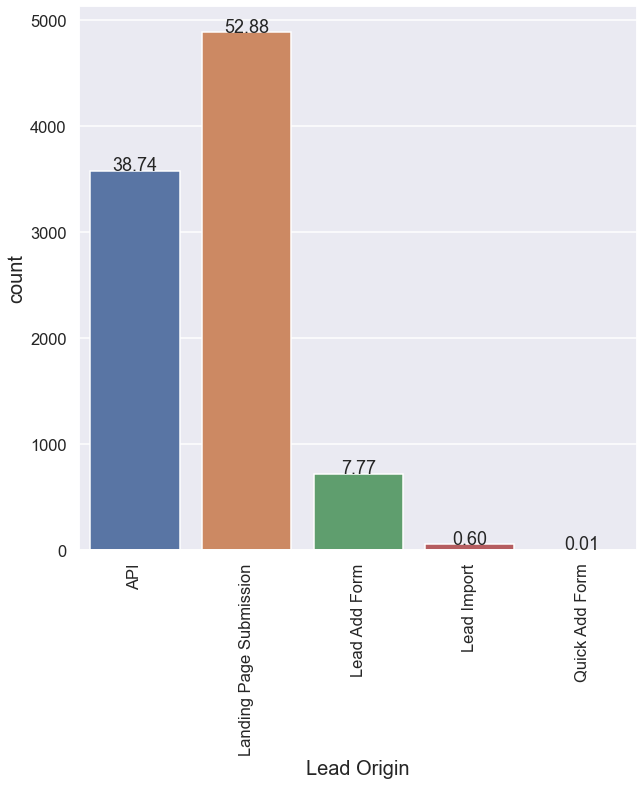

In [89]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns,'Lead Origin', (10,10))

<Figure size 2880x1440 with 0 Axes>

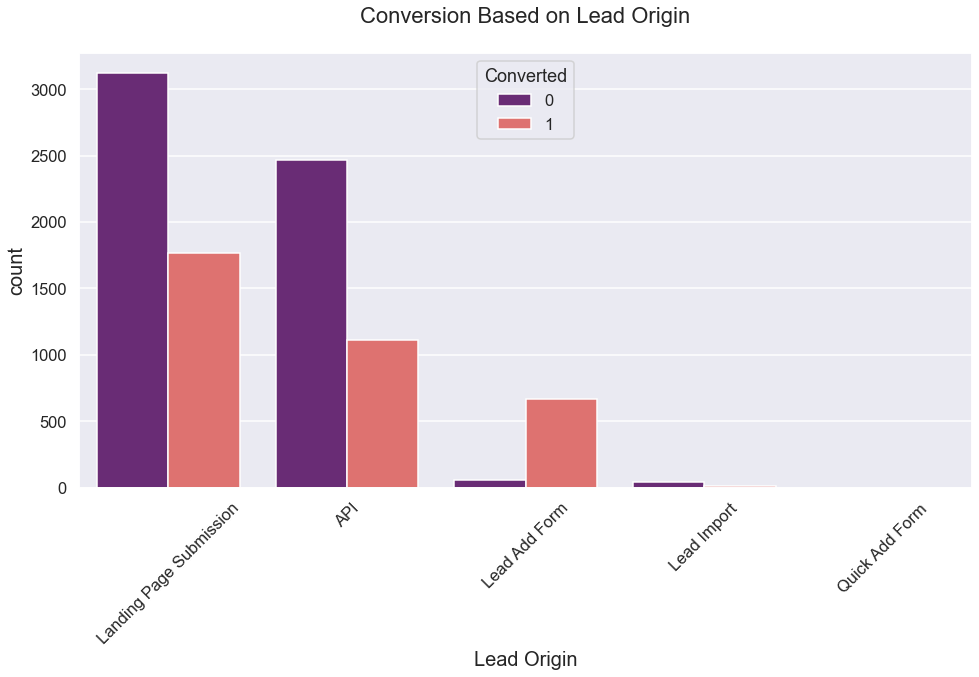

Converted                     0       1  Conversion(%)
Lead Origin                                           
Quick Add Form              0.0     1.0          100.0
Lead Add Form              54.0   664.0           92.0
Landing Page Submission  3118.0  1768.0           36.0
API                      2465.0  1115.0           31.0
Lead Import                42.0    13.0           24.0 None


In [90]:
generateBiplot(leadScoreDatasetAfterDroppedColumns,'Lead Origin', 'Conversion Based on Lead Origin', (40,20),'Converted')

### Observation

From the barplot above we can infer that:

- Lead Add Form has the highest conversion rate at 92%
- Quick Add Form has 100% conversion rate but it has only 1 entry, so it might not be that reliable as a lead to go on
- API has the least amount of conversions

####  Do Not Email

In [91]:
leadScoreDatasetAfterDroppedColumns['Do Not Email'].value_counts()

No     8506
Yes     734
Name: Do Not Email, dtype: int64

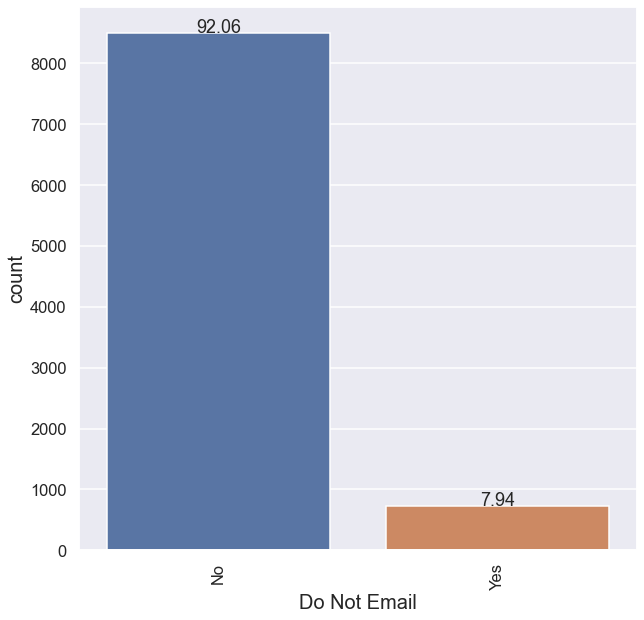

In [92]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Do Not Email',(10,10))

<Figure size 2880x1440 with 0 Axes>

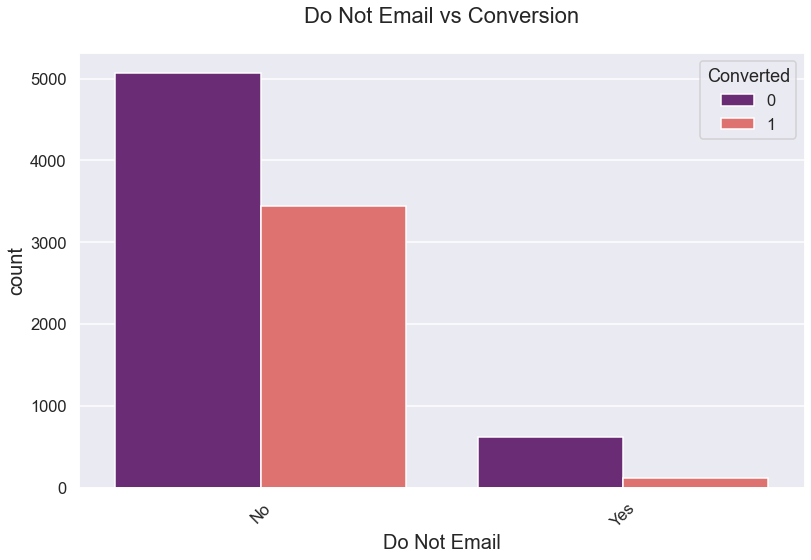

Converted        0     1  Conversion(%)
Do Not Email                           
No            5063  3443           40.0
Yes            616   118           16.0 None


In [93]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Do Not Email', 'Do Not Email vs Conversion', (40,20),'Converted')

### Observation

Based on the above we can see that the data is highly skewed. Therefore we will be dropping this column eventually

#### Do Not Call

In [94]:
leadScoreDatasetAfterDroppedColumns['Do Not Call'].value_counts()

No     9238
Yes       2
Name: Do Not Call, dtype: int64

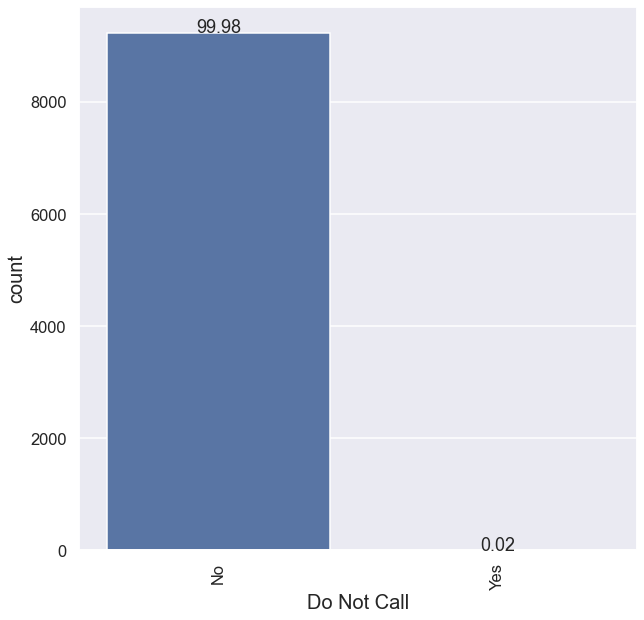

In [95]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Do Not Call',(10,10))

<Figure size 2880x1440 with 0 Axes>

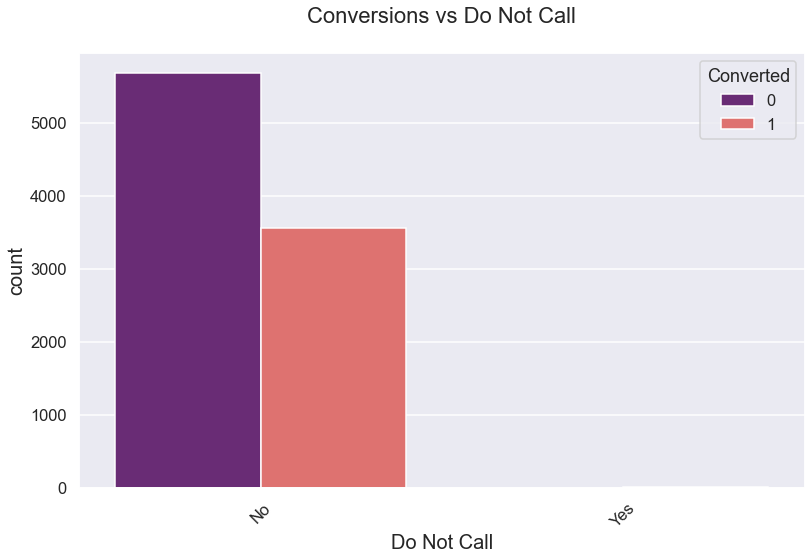

Converted         0       1  Conversion(%)
Do Not Call                               
Yes             0.0     2.0          100.0
No           5679.0  3559.0           39.0 None


In [96]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Do Not Call', 'Conversions vs Do Not Call', (40,20),'Converted')

### Observations
Based on the above we can see that the data is highly skewed. Therefore we will be dropping this column eventually

### Note
We will be dropping the columns Do Not Email & Do Not Call as the data is highly skewed towards the No section. These two columns can be take as safe assumptions by company X that 99% of their prospective customers do not like to be called or receive emails. 

In [97]:
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.drop(['Do Not Call', 'Do Not Email'], axis=1)
leadScoreDatasetAfterDroppedColumns.shape

(9240, 19)

In [98]:
leadScoreDatasetAfterDroppedColumns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Number                             9240 non-null   int64  
 1   Lead Origin                             9240 non-null   object 
 2   Lead Source                             9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9240 non-null   float64
 5   Total Time Spent on Website             9240 non-null   int64  
 6   Page Views Per Visit                    9240 non-null   float64
 7   Last Activity                           9240 non-null   object 
 8   Specialization                          9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  Search                                  9240 non-null   obje

#### Note: 

From our analysis of the data dictionary we can see that the folloowing columns: Search, Newspaper Article, Education Forums, Newspaper , Digital Advertisement and Through Recommendations, are already represented in the 'Lead Source' column. 

We will carry out basic univariate analysis on them and make a decision on if we need to drop them or not. 

#### Search

In [99]:
leadScoreDatasetAfterDroppedColumns.Search.describe()

count     9240
unique       2
top         No
freq      9226
Name: Search, dtype: object

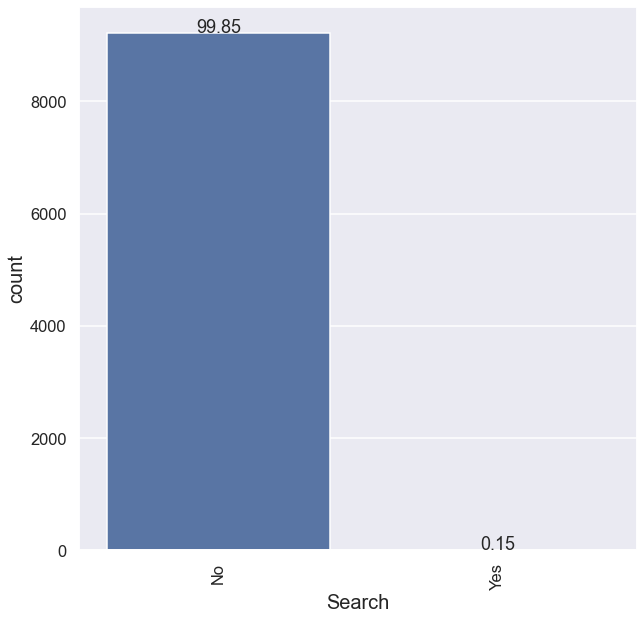

In [100]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Search',(10,10))

<Figure size 2880x1440 with 0 Axes>

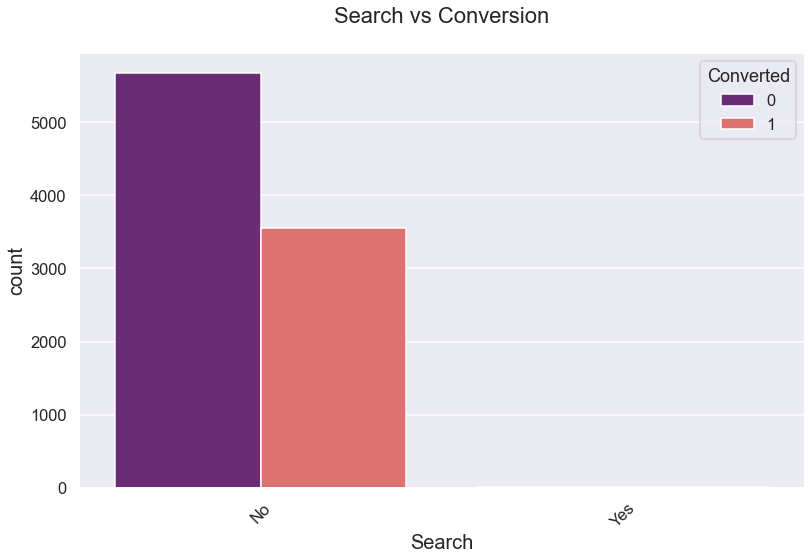

Converted     0     1  Conversion(%)
Search                              
No         5670  3556           39.0
Yes           9     5           36.0 None


In [101]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Search', 'Search vs Conversion',(40,20), 'Converted')

#### Observation

The data feels highly skewed and confirms our assumption that it is correctly represented in the Lead Source Column

#### Newspaper Article

In [102]:
leadScoreDatasetAfterDroppedColumns['Newspaper Article'].describe()

count     9240
unique       2
top         No
freq      9238
Name: Newspaper Article, dtype: object

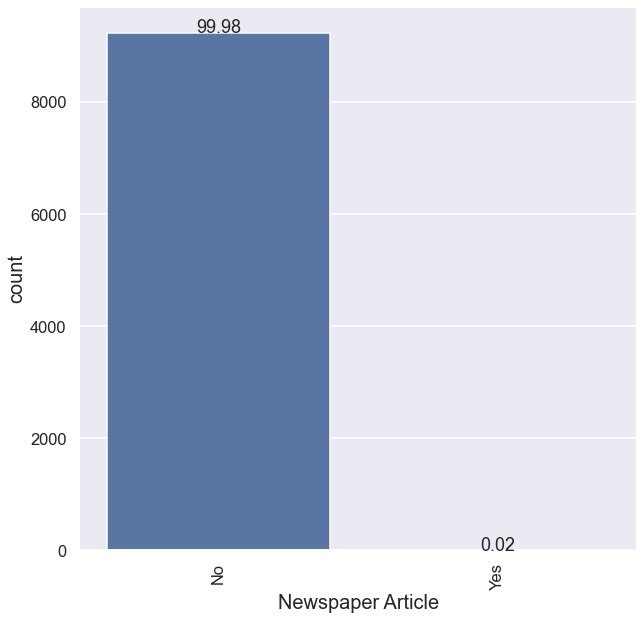

In [103]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Newspaper Article',(10,10))

<Figure size 2880x1440 with 0 Axes>

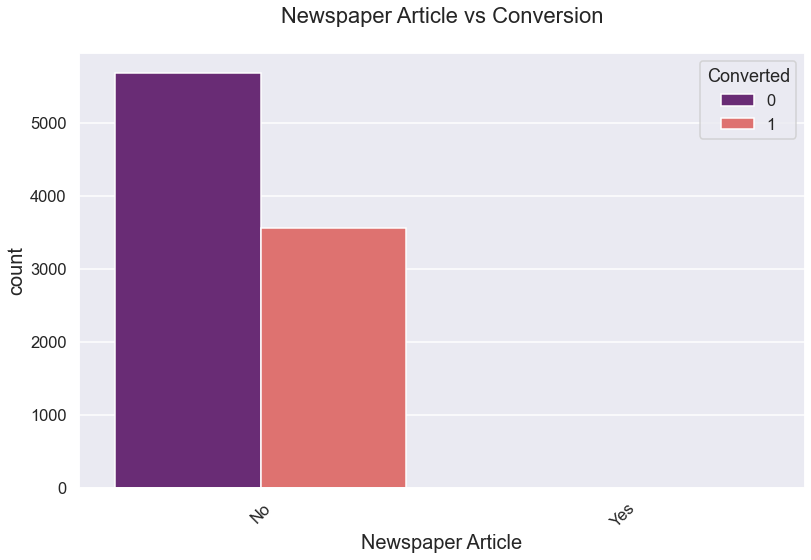

Converted             0     1  Conversion(%)
Newspaper Article                           
Yes                   1     1           50.0
No                 5678  3560           39.0 None


In [104]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Newspaper Article', 'Newspaper Article vs Conversion',(40,20), 'Converted')

#### Observation
The data feels highly skewed and confirms our assumption that it is correctly represented in the Lead Source Column

#### Education Forums

In [105]:
leadScoreDatasetAfterDroppedColumns['X Education Forums'].value_counts()

No     9239
Yes       1
Name: X Education Forums, dtype: int64

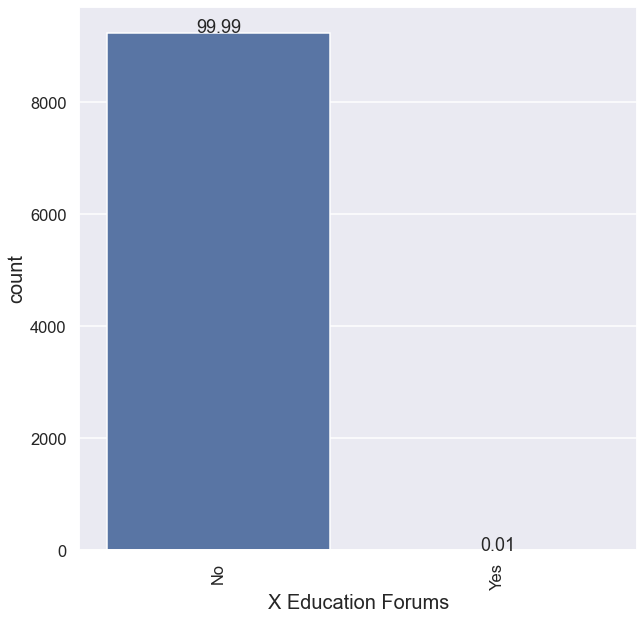

In [106]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'X Education Forums',(10,10))

<Figure size 2880x1440 with 0 Axes>

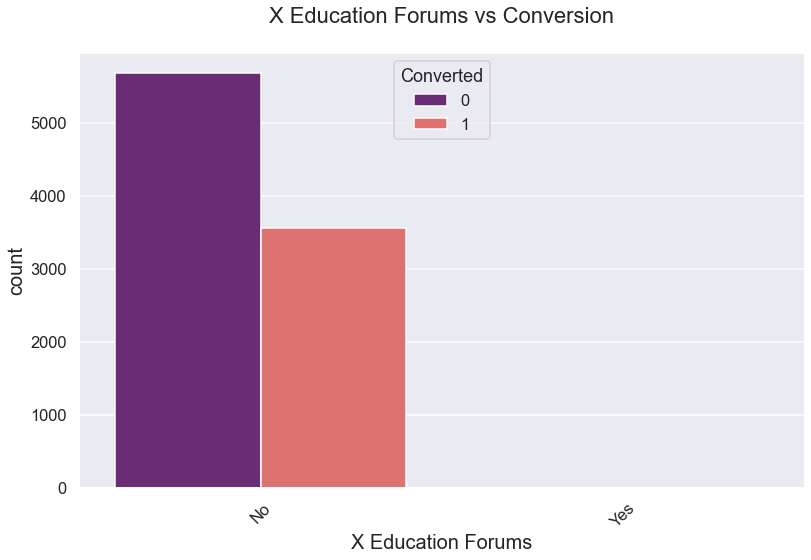

Converted                0       1  Conversion(%)
X Education Forums                               
No                  5678.0  3561.0           39.0
Yes                    1.0     0.0            0.0 None


In [107]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'X Education Forums', 'X Education Forums vs Conversion', (40,20),'Converted')

#### Observation
The data feels highly skewed and confirms our assumption that it is correctly represented in the Lead Source column

#### Newspaper

In [108]:
leadScoreDatasetAfterDroppedColumns['Newspaper'].value_counts()

No     9239
Yes       1
Name: Newspaper, dtype: int64

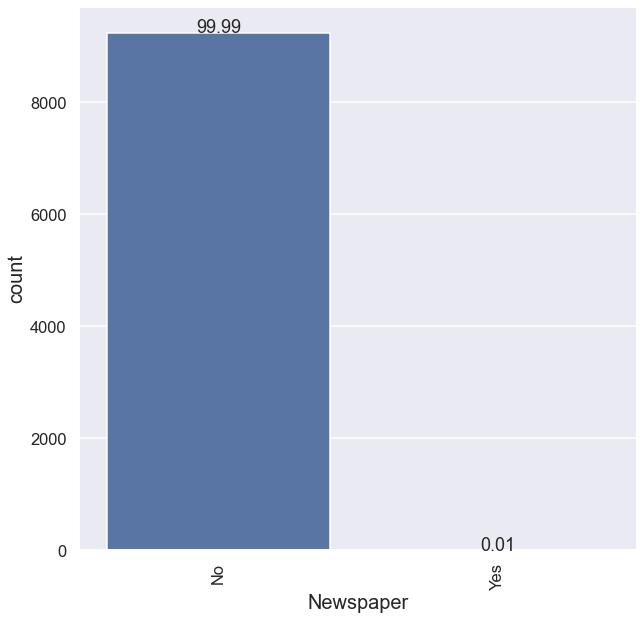

In [109]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Newspaper',(10,10))

<Figure size 2880x1440 with 0 Axes>

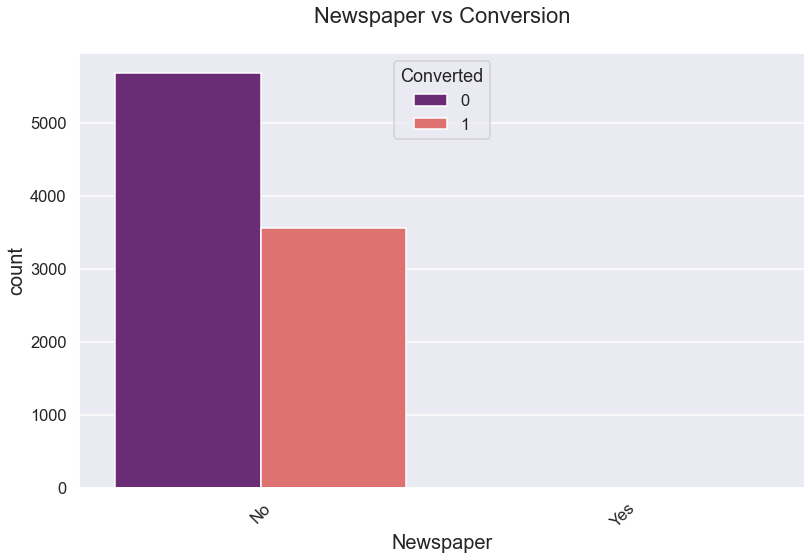

Converted       0       1  Conversion(%)
Newspaper                               
No         5678.0  3561.0           39.0
Yes           1.0     0.0            0.0 None


In [110]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Newspaper', 'Newspaper vs Conversion', (40,20),'Converted')

#### Observation
The data feels highly skewed and confirms our assumption that it is correctly represented in the Lead Source column

#### Digital Advertisement

In [111]:
leadScoreDatasetAfterDroppedColumns['Digital Advertisement'].value_counts()

No     9236
Yes       4
Name: Digital Advertisement, dtype: int64

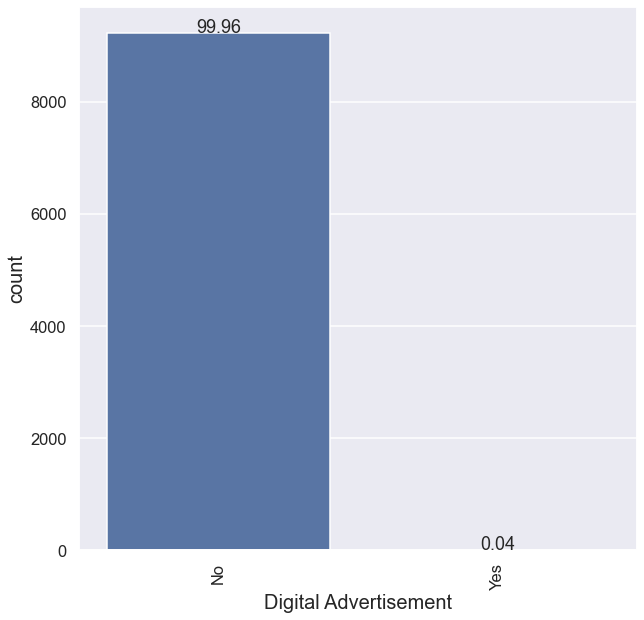

In [112]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Digital Advertisement',(10,10))

<Figure size 2880x1440 with 0 Axes>

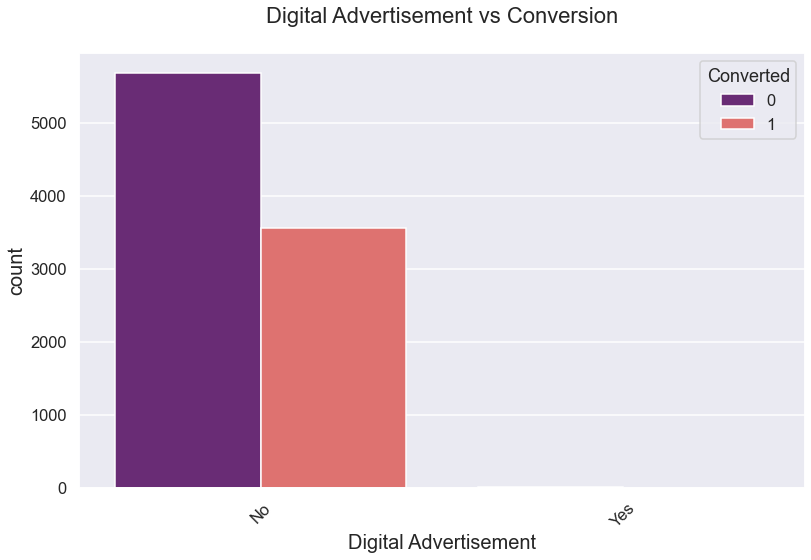

Converted                 0     1  Conversion(%)
Digital Advertisement                           
No                     5676  3560           39.0
Yes                       3     1           25.0 None


In [113]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Digital Advertisement', 'Digital Advertisement vs Conversion', (40,20),'Converted')

### Observation
The data feels highly skewed and confirms our assumption that it is correctly represented in the Lead Source column

#### Through Recommendations

In [114]:
leadScoreDatasetAfterDroppedColumns['Through Recommendations'].value_counts()

No     9233
Yes       7
Name: Through Recommendations, dtype: int64

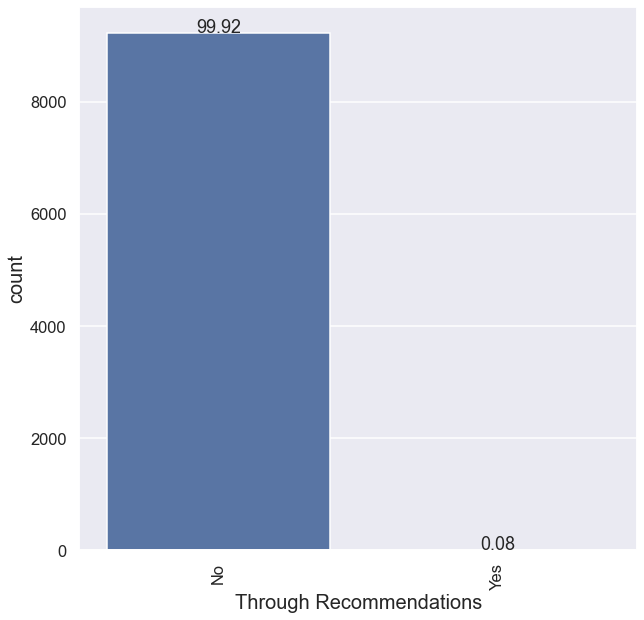

In [115]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Through Recommendations',(10,10))

<Figure size 2880x1440 with 0 Axes>

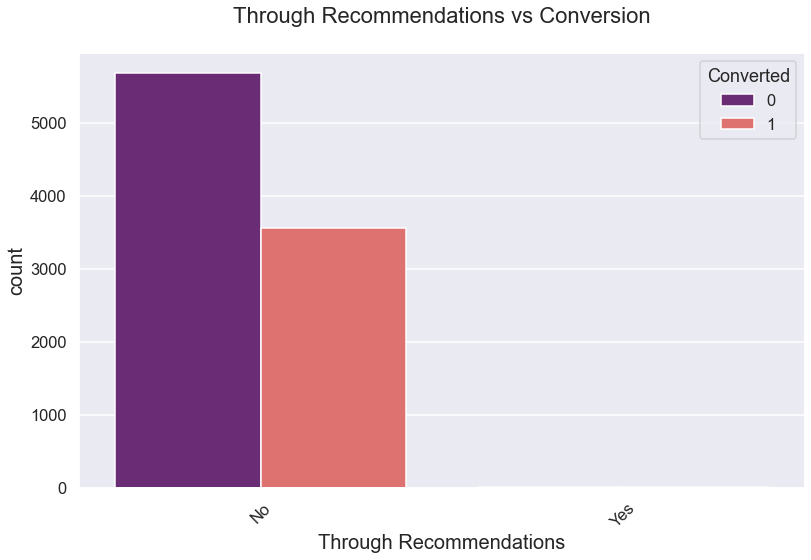

Converted                   0     1  Conversion(%)
Through Recommendations                           
Yes                         2     5           71.0
No                       5677  3556           39.0 None


In [116]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Through Recommendations', 'Through Recommendations vs Conversion', (40,20),'Converted')

### Observation
The data feels highly skewed and confirms our assumption that it is correctly represented in the Lead Source column.

Since the data for these columns is already correctly represented in the 'Lead Source' column, we will drop these columns

In [117]:
dropCols = ['Search', 'Newspaper', 'X Education Forums', 'Newspaper Article' , 'Digital Advertisement','Through Recommendations']
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.drop(dropCols, axis=1)
leadScoreDatasetAfterDroppedColumns.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified

In [118]:
leadScoreDatasetAfterDroppedColumns.shape

(9240, 13)

In [119]:
leadScoreDatasetAfterDroppedColumns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Number                             9240 non-null   int64  
 1   Lead Origin                             9240 non-null   object 
 2   Lead Source                             9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9240 non-null   float64
 5   Total Time Spent on Website             9240 non-null   int64  
 6   Page Views Per Visit                    9240 non-null   float64
 7   Last Activity                           9240 non-null   object 
 8   Specialization                          9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  City                                    9240 non-null   obje

#### A free copy of Mastering The Interview

In [120]:
leadScoreDatasetAfterDroppedColumns['A free copy of Mastering The Interview'].value_counts()

No     6352
Yes    2888
Name: A free copy of Mastering The Interview, dtype: int64

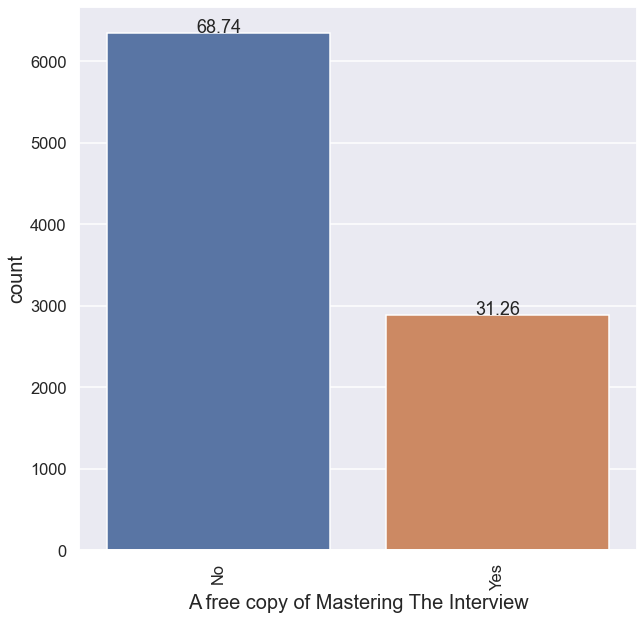

In [121]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'A free copy of Mastering The Interview',(10,10))

<Figure size 2880x1440 with 0 Axes>

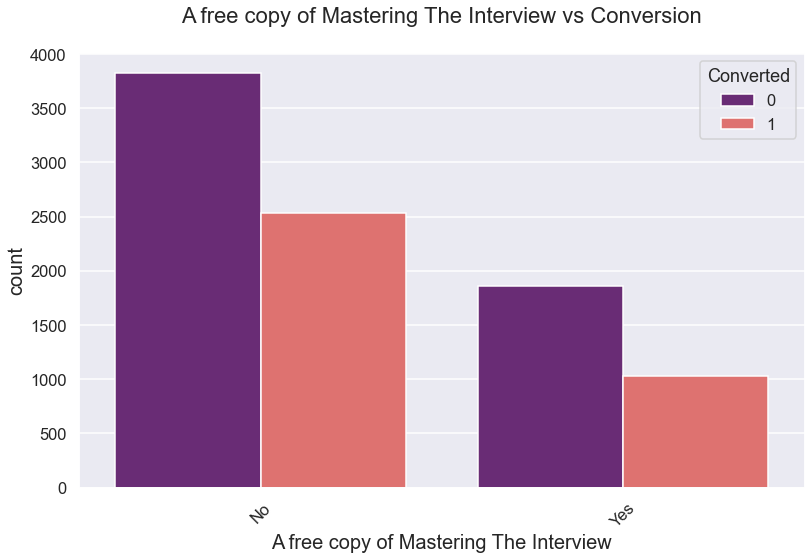

Converted                                  0     1  Conversion(%)
A free copy of Mastering The Interview                           
No                                      3821  2531           40.0
Yes                                     1858  1030           36.0 None


In [122]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'A free copy of Mastering The Interview', 'A free copy of Mastering The Interview vs Conversion', (40,20),'Converted')

#### Observation

A large number of candidates, 64% didnt opt for any course even though the would like a free copy. 
60% of the candidates didn't opt for any course or the free book. It is safe to say that this column has no impact on the behaviour of the prospective candidates. We will drop this column.

In [123]:
leadScoreDatasetAfterDroppedColumns.shape

(9240, 13)

#### Last Notable Activity 

From the data dictionary it looks like this column is very simmilar to the 'Last Activity' column. We will do some analysis on this and if found similar we will drop this column. 

In [124]:
leadScoreDatasetAfterDroppedColumns['Last Notable Activity'].describe()

count         9240
unique          16
top       Modified
freq          3407
Name: Last Notable Activity, dtype: object

In [125]:
leadScoreDatasetAfterDroppedColumns['Last Notable Activity'].value_counts()

Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
View in browser link Clicked       1
Email Received                     1
Approached upfront                 1
Form Submitted on Website          1
Resubscribed to emails             1
Name: Last Notable Activity, dtype: int64

From our initial analysis it looks like these columns are very similar. Let us do some univariate & bivariate analysis to confirm this. 

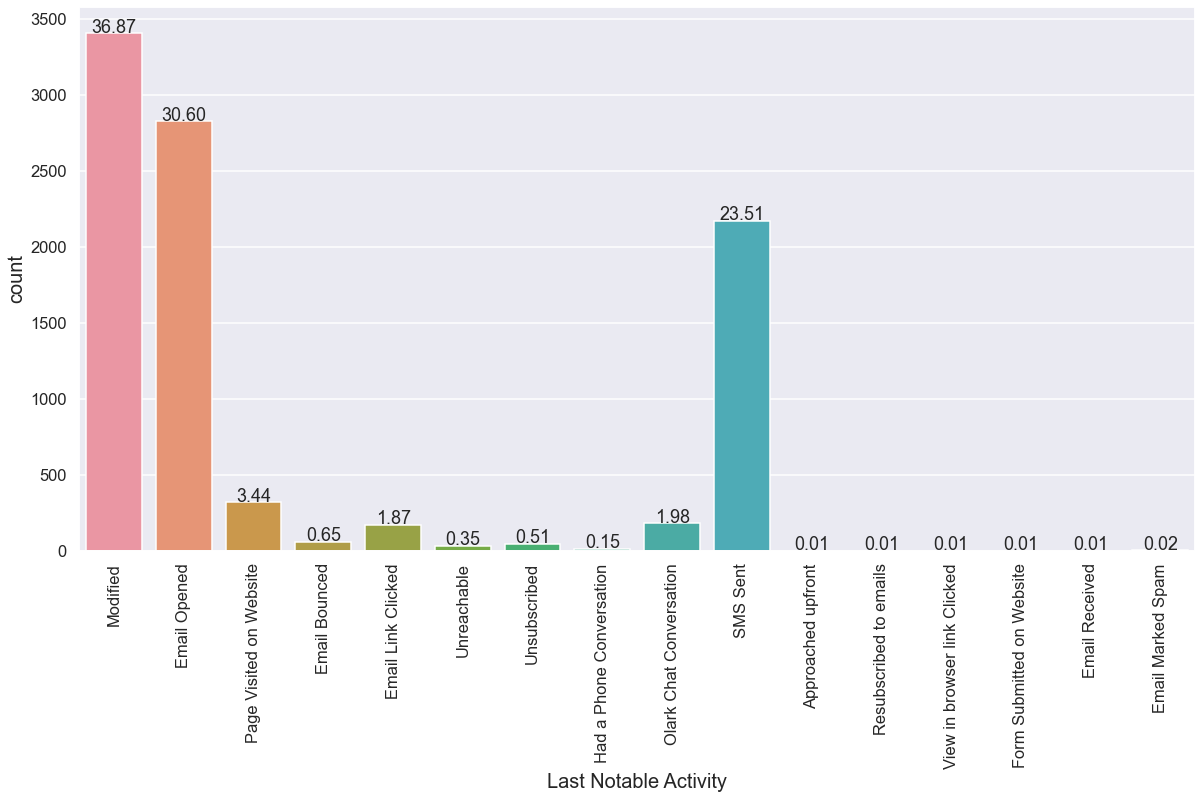

In [126]:
generateBarPlot(leadScoreDatasetAfterDroppedColumns, 'Last Notable Activity',(20,10))

<Figure size 2880x1440 with 0 Axes>

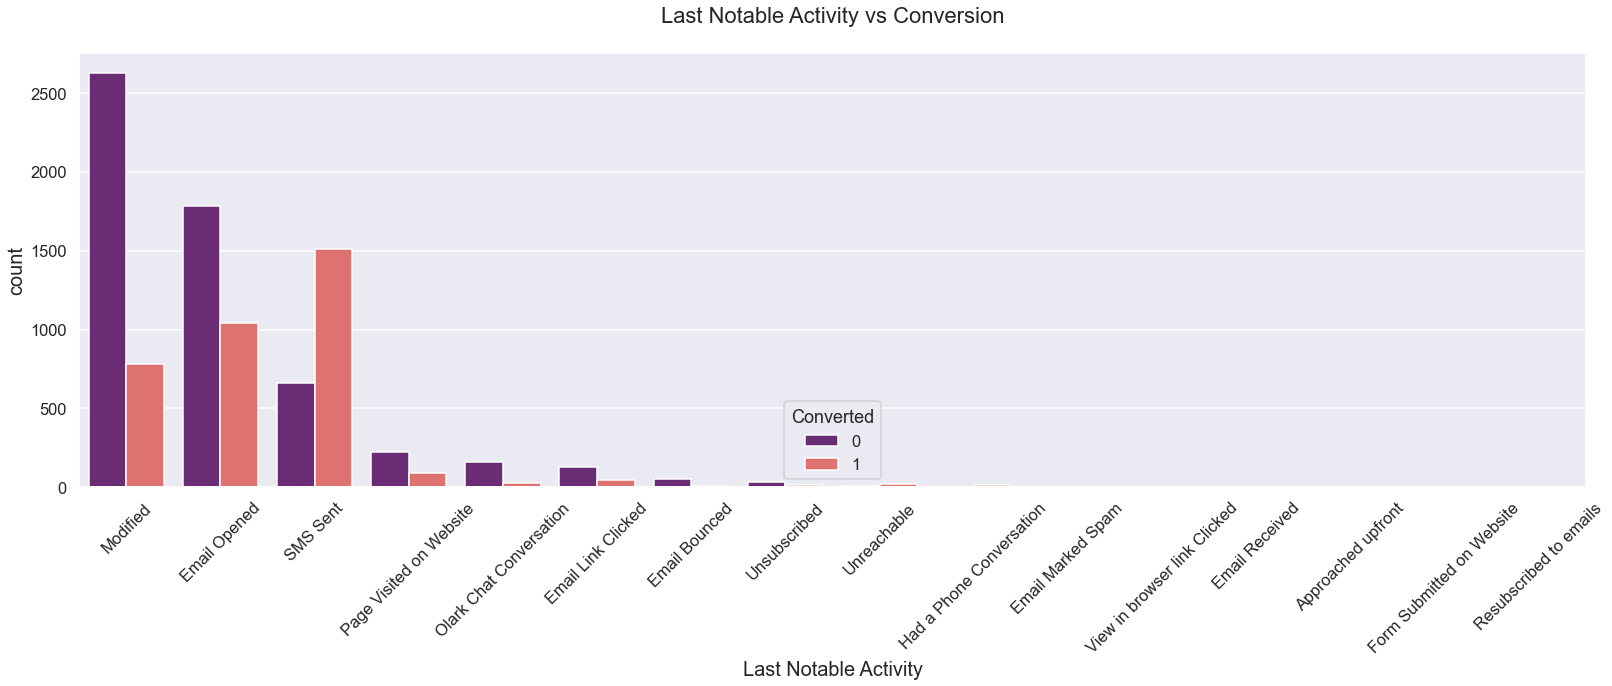

Converted                          0       1  Conversion(%)
Last Notable Activity                                      
Approached upfront               0.0     1.0          100.0
Email Marked Spam                0.0     2.0          100.0
Email Received                   0.0     1.0          100.0
Resubscribed to emails           0.0     1.0          100.0
Had a Phone Conversation         1.0    13.0           93.0
SMS Sent                       664.0  1508.0           69.0
Unreachable                     10.0    22.0           69.0
Email Opened                  1783.0  1044.0           37.0
Unsubscribed                    33.0    14.0           30.0
Page Visited on Website        225.0    93.0           29.0
Email Link Clicked             128.0    45.0           26.0
Modified                      2624.0   783.0           23.0
Email Bounced                   51.0     9.0           15.0
Olark Chat Conversation        158.0    25.0           14.0
Form Submitted on Website        1.0    

In [127]:
generateBiplot(leadScoreDatasetAfterDroppedColumns, 'Last Notable Activity', 'Last Notable Activity vs Conversion', (40,20),'Converted')

#### Observation

From our analysis we see that this column holds similar data represented in the Last Activity column. We will drop this one and keep the Last Activity column.

In [128]:
leadScoreDatasetAfterDroppedColumns = leadScoreDatasetAfterDroppedColumns.drop('Last Notable Activity', axis=1)
leadScoreDatasetAfterDroppedColumns.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

  A free copy of Mastering The Interview  
0                                     No  
1                                     No  
2                                    Yes  
3                                     No  
4                                     No

In [129]:
leadScoreDatasetAfterDroppedColumns.shape

(9240, 12)

#### Note:
Now that we have identified the above 12 columns, let us generate dummies for the same


#### Total Time Spent on Website

In [130]:
leadScoreDatasetAfterDroppedColumns['Total Time Spent on Website'].describe()

count    9240.000000
mean      487.698268
std       548.021466
min         0.000000
25%        12.000000
50%       248.000000
75%       936.000000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

In [131]:
leadScoreDatasetAfterDroppedColumns['Total Time Spent on Website'].value_counts()

0       2193
60        19
127       18
75        18
74        18
        ... 
1235       1
1091       1
1043       1
1035       1
1915       1
Name: Total Time Spent on Website, Length: 1731, dtype: int64

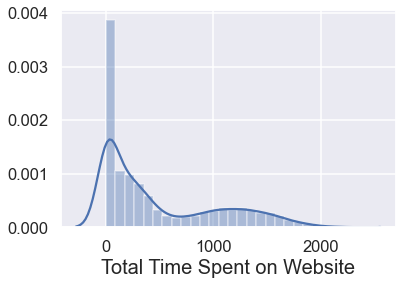

In [132]:
### Let us generate a distplot to view the split of this data
sns.distplot(leadScoreDatasetAfterDroppedColumns['Total Time Spent on Website'])
plt.show()

### Observation

The above looks like time spent was recorded in minutes rather than hours. We will convert the entire column into hours for ease of analysis

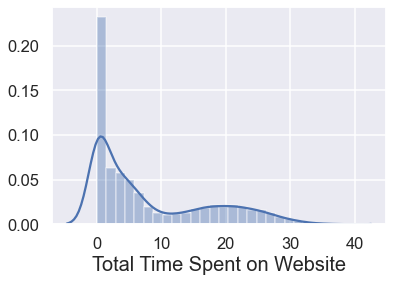

In [133]:
leadScoreDatasetAfterDroppedColumns['Total Time Spent on Website'] = leadScoreDatasetAfterDroppedColumns['Total Time Spent on Website'].apply(lambda x: round((x/60), 2))
sns.distplot(leadScoreDatasetAfterDroppedColumns['Total Time Spent on Website'])
plt.show()

In [134]:
leadScoreDatasetAfterDroppedColumns.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

  A free copy of Mastering The Interview  
0                                     No  
1                                     No  
2                                    Yes  
3                                     No  
4                                     No

#### Note
Since this is a key variable for us it would make sense to check what percentage of candidates were converted depending on the number of hours they spent.

In [135]:
# Let us split our dataframe to perform better analysis
timeSpentMoreThan1HourDF=leadScoreDatasetAfterDroppedColumns[leadScoreDatasetAfterDroppedColumns['Total Time Spent on Website']>=1.0]
timeSpentMoreThan1HourDF["Hours Spent"]= timeSpentMoreThan1HourDF["Total Time Spent on Website"].astype(int)

timeSpentMoreThan1HourDF.head()


Lead Number              Lead Origin     Lead Source  Converted  \
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   
6       660673  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   
6          2.0                        27.33                   2.0   

       Last Activity           Specialization What is your current occupation  \
1       Email Opened                   Others                      Unemployed   
2       Email Opened  Business Administration                         Student   
3        Unreachable    Media and Advertising                      Unemployed   
4  Converted to Lead                   Others                      Unemployed   
6       Email Opened  Supply Chain Management                      Unemployed   

     City A free copy of Mastering The Interview  Hours Spent  
1  Mumbai                                     No           11  
2  Mumbai                                    Yes           25  
3  Mumbai                                     No            5  
4  Mumbai                                     No           23  
6  Mumbai                                     No           27

<Figure size 2880x2880 with 0 Axes>

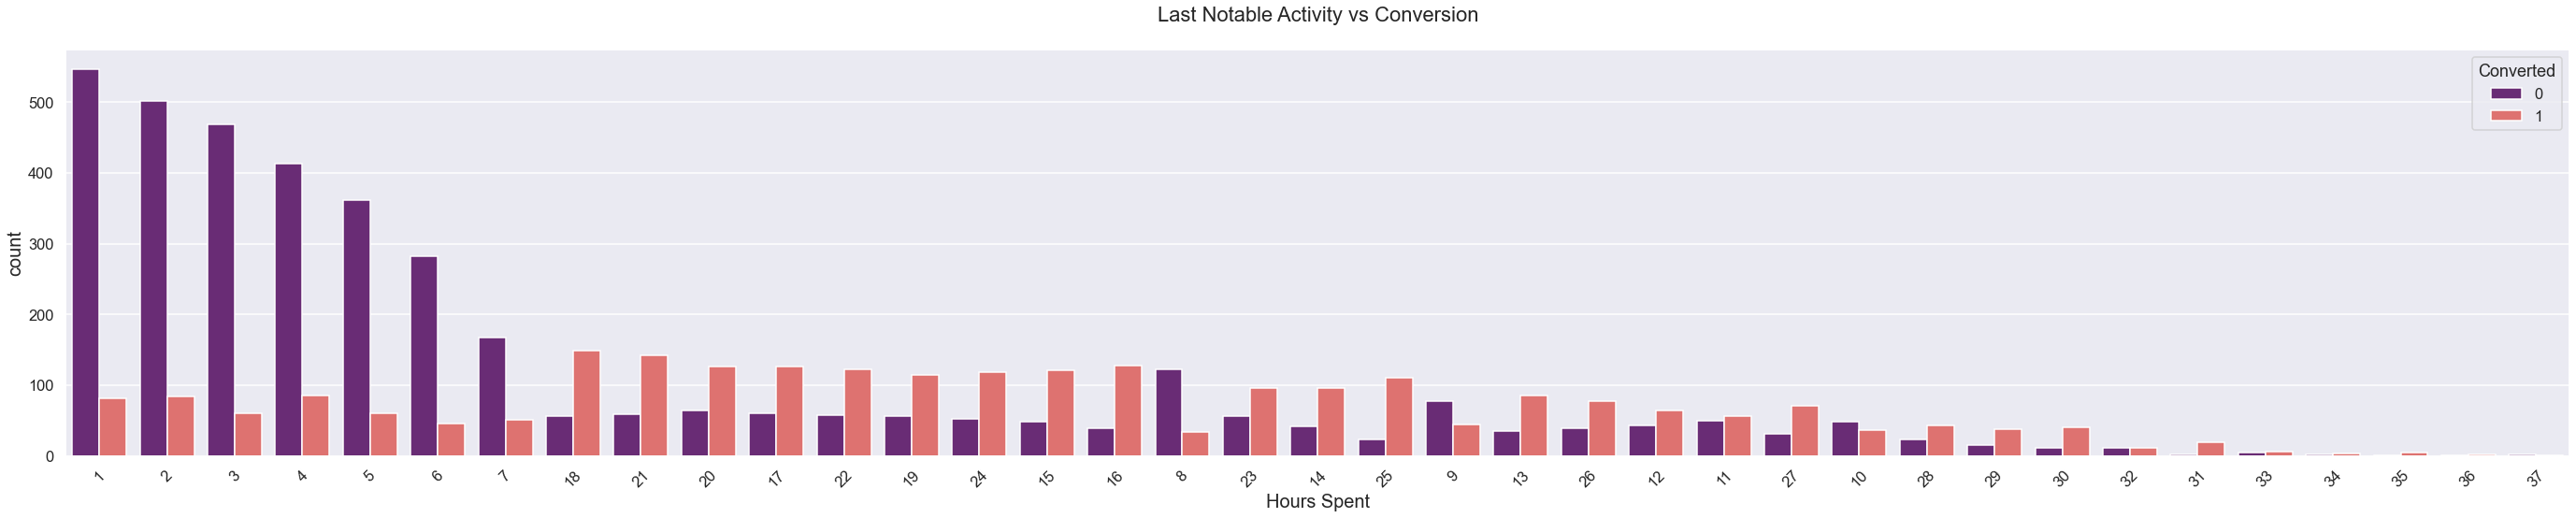

Converted      0    1  Conversion(%)
Hours Spent                         
31             2   20           91.0
35             1    5           83.0
25            24  111           82.0
30            12   41           77.0
16            40  128           76.0
18            56  149           73.0
15            48  121           72.0
21            59  142           71.0
13            35   85           71.0
24            52  119           70.0
14            42   96           70.0
29            16   38           70.0
27            32   71           69.0
22            58  122           68.0
17            60  126           68.0
19            57  114           67.0
36             1    2           67.0
20            64  127           66.0
26            39   77           66.0
28            23   43           65.0
23            57   96           63.0
12            43   64           60.0
34             3    4           57.0
33             5    6           55.0
11            50   56           53.0
3

In [136]:
### Let us generate a bivariate analysis bar plot to better understand our conversions

generateBiplot(timeSpentMoreThan1HourDF, 'Hours Spent', 'Last Notable Activity vs Conversion', (40,40),'Converted')

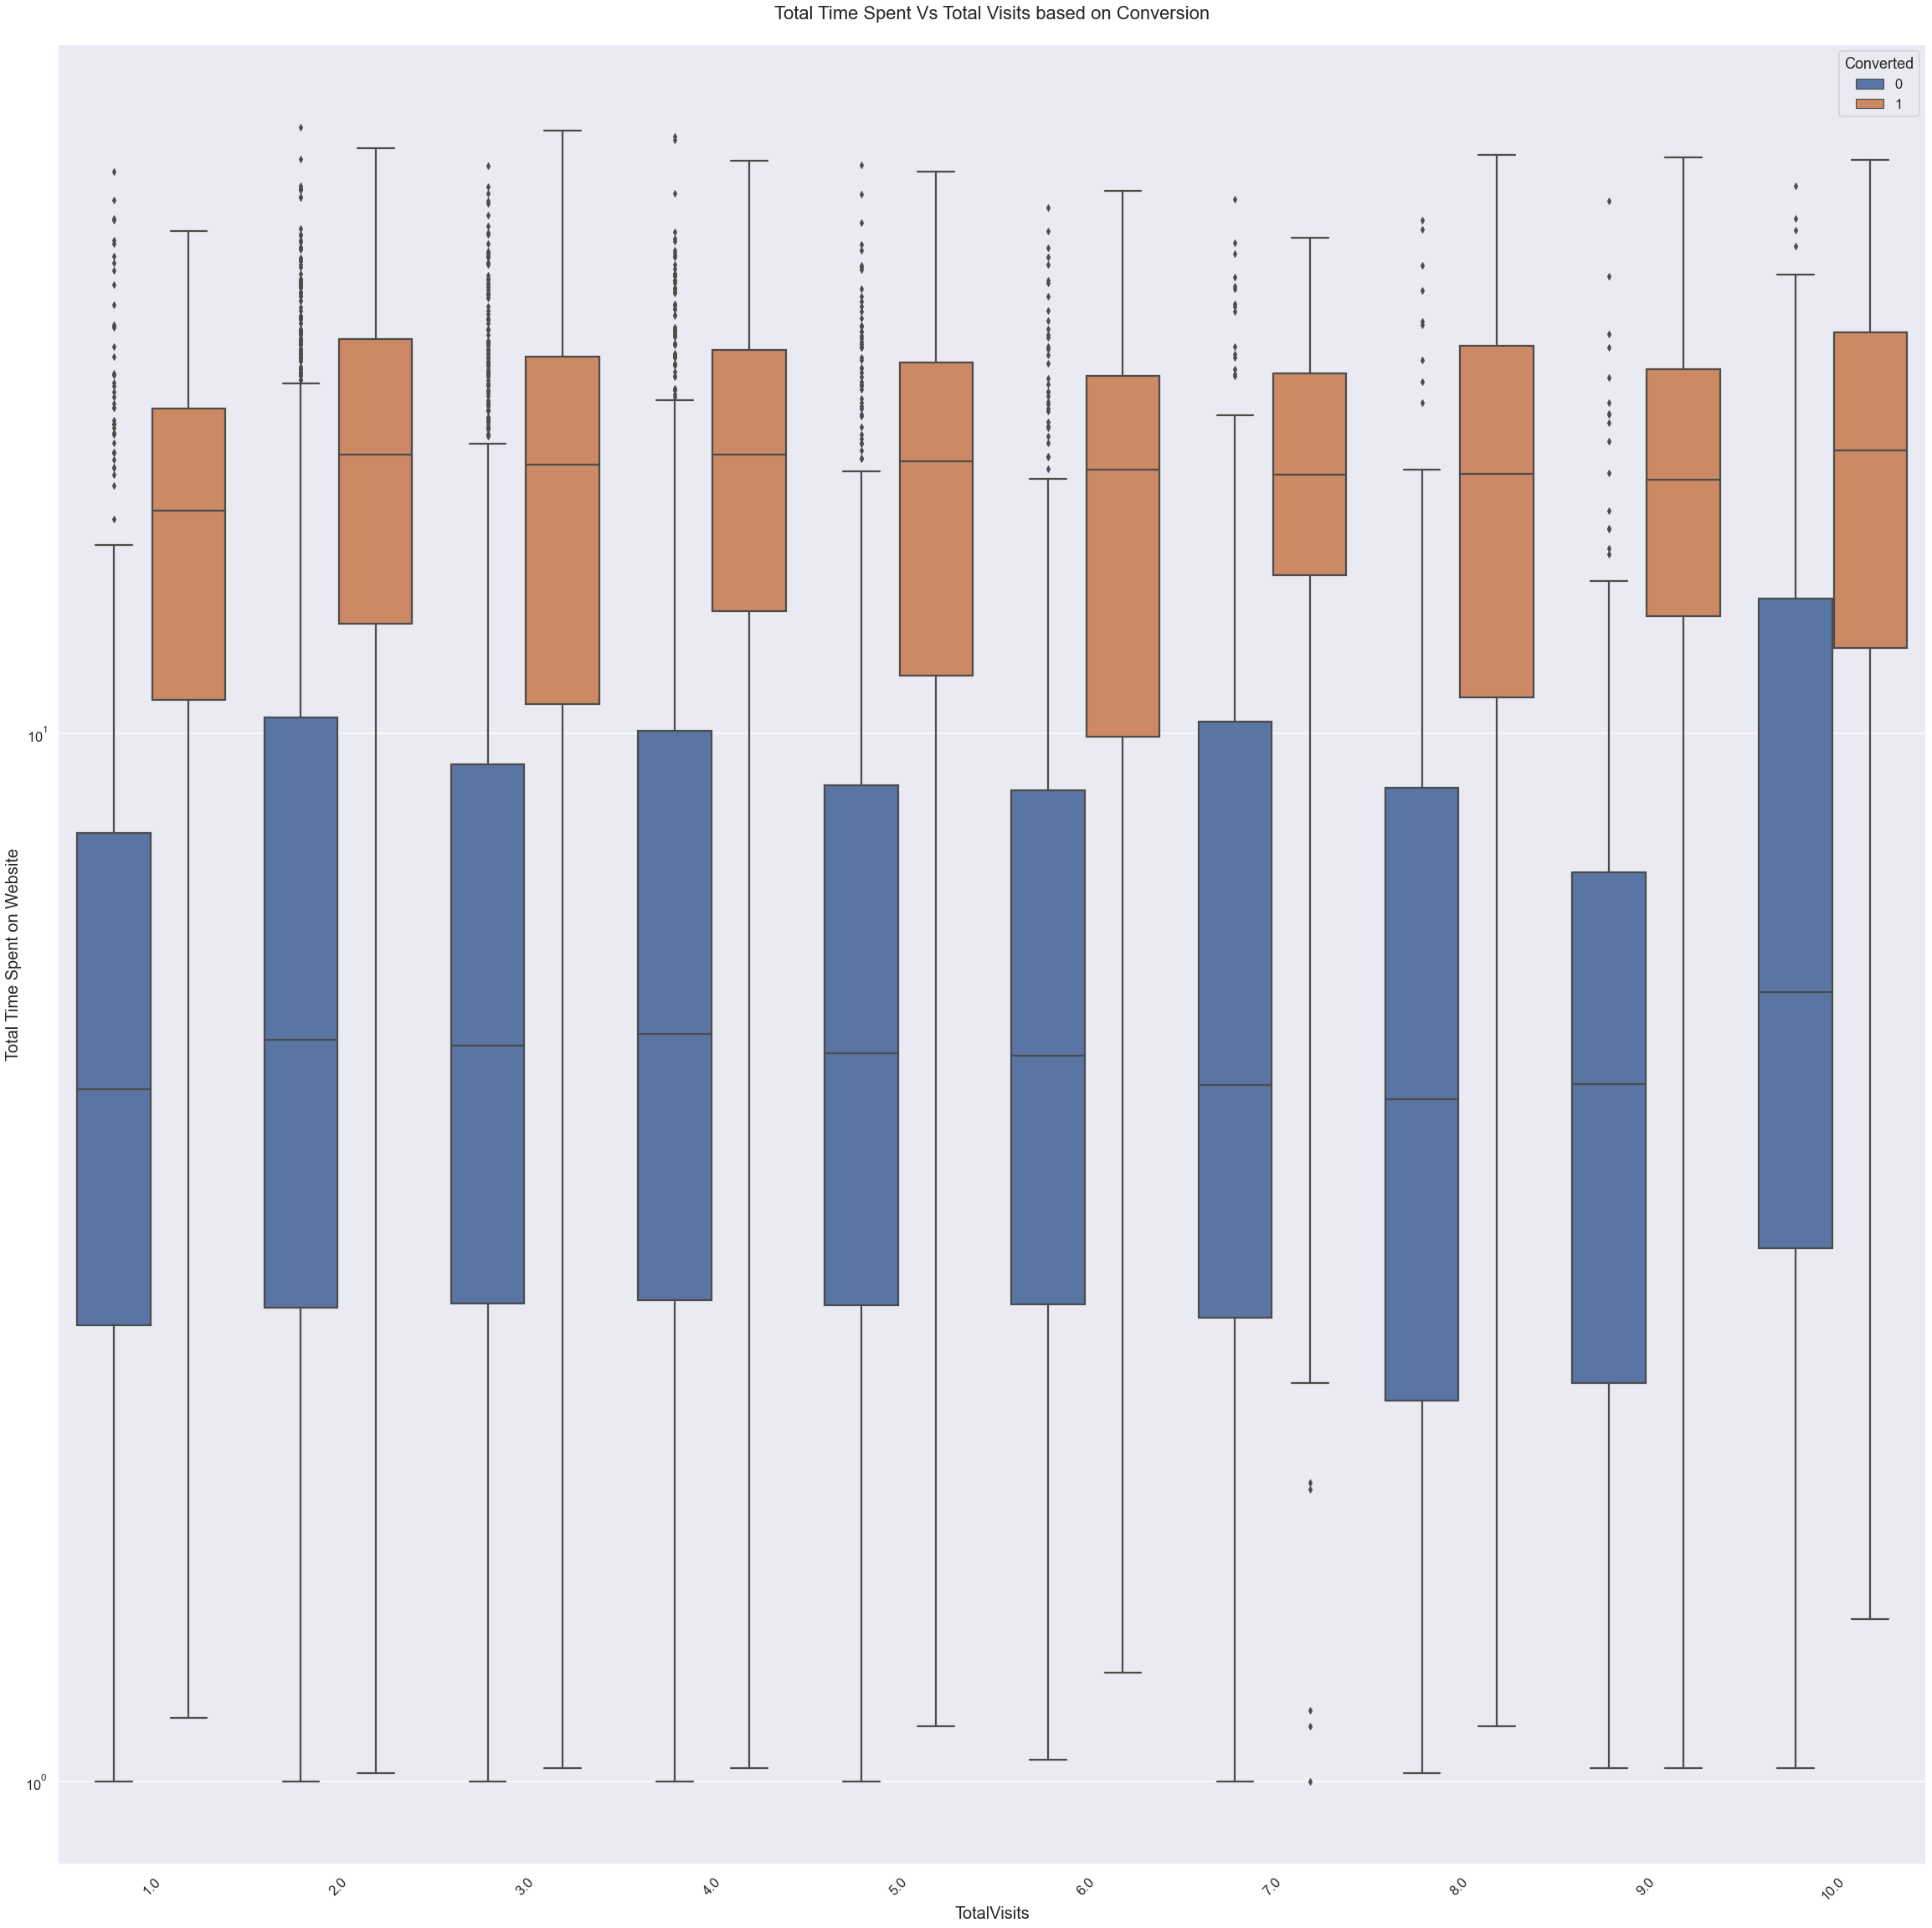

In [137]:
plt.figure(figsize=(40,40))
plt.xticks(rotation=45)
plt.yscale('log')
sns.boxplot(data =timeSpentMoreThan1HourDF, x='TotalVisits',y='Total Time Spent on Website', hue ='Converted',orient='v')
plt.title('Total Time Spent Vs Total Visits based on Conversion')
plt.show()

### Observation 

From the above bar plot we can infer that:

- The highest number of conversions happen when people are spending around 18 hours or above on the website
- People who spent around 3 hours on the website didn't opt for any courses. 
- From the boxplot we can see better that the longer you stay on the website, the higher your chances of conversion as well.

Overall it is safe to say that the more time the user spends on the website, the better their chances of becoming a student. 

In [138]:
generateNullValuesPercentageTable(leadScoreDatasetAfterDroppedColumns)

Total Null Values  \
A free copy of Mastering The Interview                  0   
City                                                    0   
What is your current occupation                         0   
Specialization                                          0   
Last Activity                                           0   
Page Views Per Visit                                    0   
Total Time Spent on Website                             0   
TotalVisits                                             0   
Converted                                               0   
Lead Source                                             0   
Lead Origin                                             0   
Lead Number                                             0   

                                        Percentage of Null Values  
A free copy of Mastering The Interview                        0.0  
City                                                          0.0  
What is your current occupation                               0.0  
Specialization                                                0.0  
Last Activity                                                 0.0  
Page Views Per Visit                                          0.0  
Total Time Spent on Website                                   0.0  
TotalVisits                                                   0.0  
Converted                                                     0.0  
Lead Source                                                   0.0  
Lead Origin                                                   0.0  
Lead Number                                                   0.0

### Note

Our Exploratory Data Analysis and outlier analysis is now complete.

Our data is free of outliers and any issues that might have prevented our model from performing the best it can. 

Let us now asses the final data frame and create a new dataframe for the dummies. 

In [139]:
leadScoreDatasetAfterDroppedColumns.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

  A free copy of Mastering The Interview  
0                                     No  
1                                     No  
2                                    Yes  
3                                     No  
4                                     No

In [140]:
### Assessing current dataframe
leadScoreDatasetAfterDroppedColumns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Number                             9240 non-null   int64  
 1   Lead Origin                             9240 non-null   object 
 2   Lead Source                             9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9240 non-null   float64
 5   Total Time Spent on Website             9240 non-null   float64
 6   Page Views Per Visit                    9240 non-null   float64
 7   Last Activity                           9240 non-null   object 
 8   Specialization                          9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  City                                    9240 non-null   obje

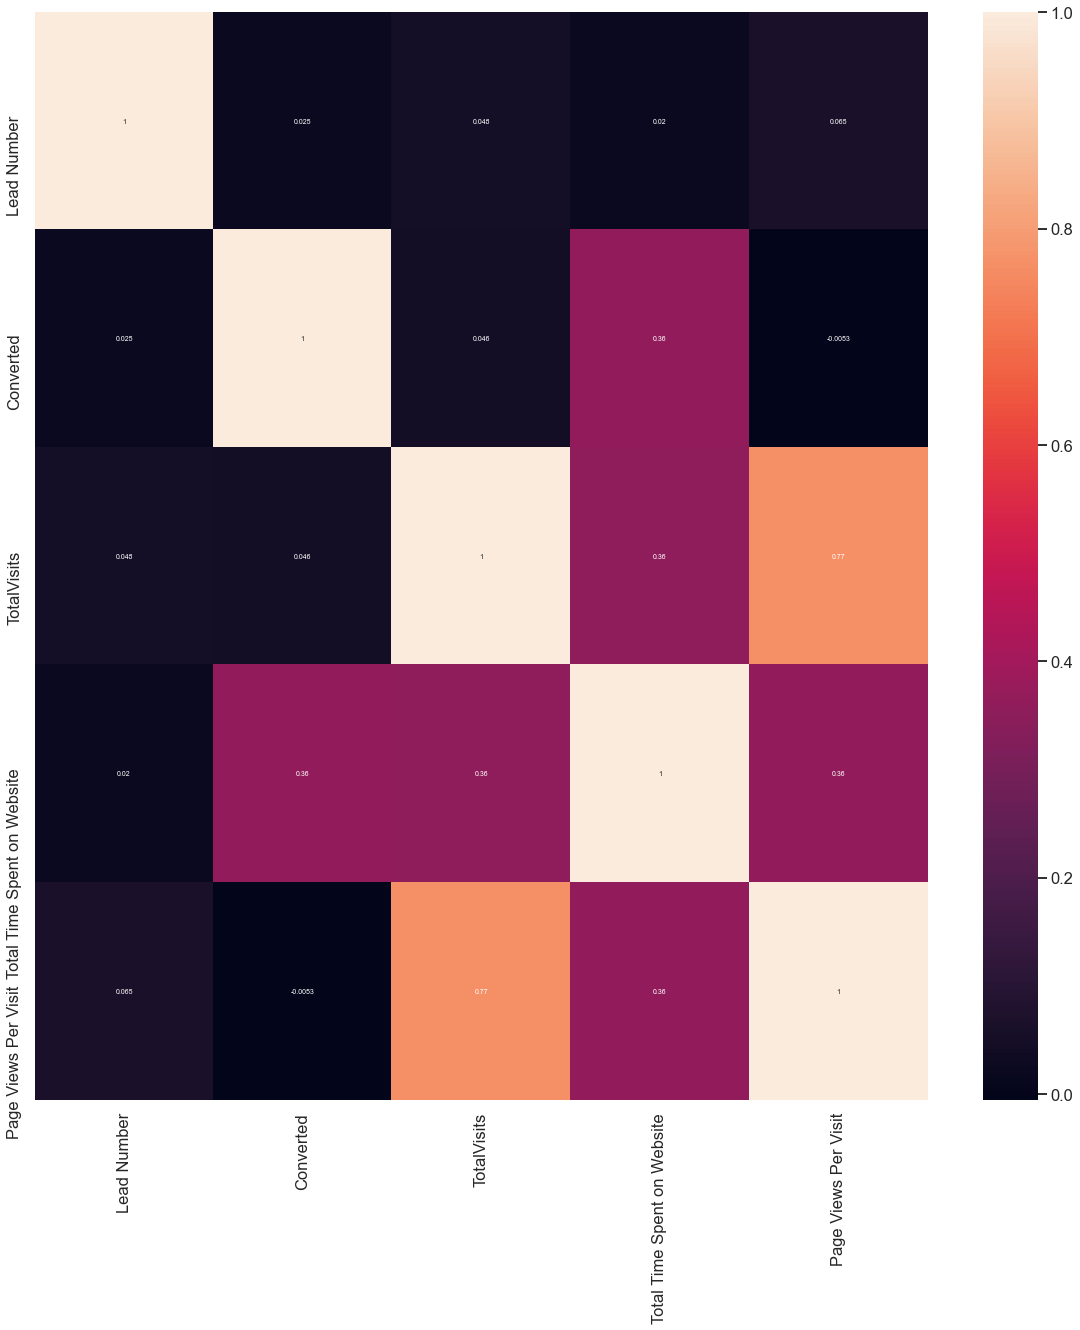

In [141]:
### Let us assess the correlation between the existing variables to rule out any colinearity 
generateHeatmaps(leadScoreDatasetAfterDroppedColumns, (20,20))

#### Observation

Based on the above heatmap we can see that we don't have any highly correlated features. Therefore there is no multicollinearity in the dataset.

# 2. Data Preparation

We will begin our data prepartation for the Logistic Regression model by:

- Creating Dummy variables for categorical columns
- Removing repeated columns
- Performing train-test split
- Performing scaling

### Creating Dummies

In [142]:
### First we will convert the Yes/No values in the 'A free copy of Mastering The Interview' column to 1/0

leadScoreDatasetAfterDroppedColumns['A free copy of Mastering The Interview'] = leadScoreDatasetAfterDroppedColumns['A free copy of Mastering The Interview'].map(dict(Yes=1, No=0))
leadScoreDatasetAfterDroppedColumns.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

   A free copy of Mastering The Interview  
0                                       0  
1                                       0  
2                                       1  
3                                       0  
4                                       0

In [143]:
leadScoreDatasetAfterDroppedColumns.shape

(9240, 12)

In [144]:
### Creating dummies
dummyCols = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation','City']
dummyDataset = pd.get_dummies(leadScoreDatasetAfterDroppedColumns[dummyCols],drop_first=True)
dummyDataset.head()

Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_Facebook  \
0                        0                           0                     0   
1                        0                           0                     0   
2                        0                           0                     0   
3                        0                           0                     0   
4                        0                           0                     0   

   Lead Source_Google  Lead Source_Olark chat  Lead Source_Organic search  \
0                   0                       1                           0   
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   1                       0                           0   

   Lead Source_Others  Lead Source_Reference  Lead Source_Referral sites  \
0                   0                      0                           0   
1                   0                      0                           0   
2                   0                      0                           0   
3                   0                      0                           0   
4                   0                      0                           0   

   Lead Source_Welingak website  Last Activity_Converted to Lead  \
0                             0                                0   
1                             0                                0   
2                             0                                0   
3                             0                                0   
4                             0                                1   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
0                            0                                 0   
1                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   

   Last Activity_Email Marked Spam  Last Activity_Email Opened  \
0                                0                           0   
1                                0                           1   
2                                0                           1   
3                                0                           0   
4                                0                           0   

   Last Activity_Email Received  Last Activity_Form Submitted on Website  \
0                             0                                        0   
1                             0                                        0   
2                             0                                        0   
3                             0                                        0   
4                             0                                        0   

   Last Activity_Had a Phone Conversation  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   Last Activity_Olark Chat Conversation  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                       

In [145]:
dummyDataset.shape

(9240, 56)

In [146]:
### Combining dummies with the original dataset into a new dataset

combinedDummyDataset = leadScoreDatasetAfterDroppedColumns.copy()
combinedDummyDataset.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

   A free copy of Mastering The Interview  
0                                       0  
1                                       0  
2                                       1  
3                                       0  
4                                       0

In [147]:
combinedDummyDataset.shape

(9240, 12)

In [148]:
### combining datasets
combinedDummyDataset = pd.concat([combinedDummyDataset, dummyDataset], axis=1)
combinedDummyDataset.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

   A free copy of Mastering The Interview  \
0                                       0   
1                                       0   
2                                       1   
3                                       0   
4                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_Facebook  \
0                        0                           0                     0   
1                        0                           0                     0   
2                        0                           0                     0   
3                        0                           0                     0   
4                        0                           0                     0   

   Lead Source_Google  Lead Source_Olark chat  Lead Source_Organic search  \
0                   0                       1                           0   
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   1                       0                           0   

   Lead Source_Others  Lead Source_Reference  Lead Source_Referral sites  \
0                   0                      0                           0   
1                   0                      0                           0   
2                   0                      0                           0   
3                   0                      0                           0   
4                   0                      0                           0   

   Lead Source_Welingak website  Last Activity_Converted to Lead  \
0                             0                                0   
1                             0                                0   
2                             0                                0   
3                             0                                0   
4                             0                                1   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
0

In [149]:
combinedDummyDataset.shape

(9240, 68)

In [150]:
### We will now drop the original columns and the columns that have 'Others' as a sub heading since we had 
### combined various values to create those columns

dummiesColsToDrop = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation','City',
                     'Lead Source_Others','Specialization_Others']
combinedDummyDataset = combinedDummyDataset.drop(dummiesColsToDrop, axis=1)
combinedDummyDataset.head()

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0       660737          0          0.0                         0.00   
1       660728          0          5.0                        11.23   
2       660727          1          2.0                        25.53   
3       660719          0          1.0                         5.08   
4       660681          1          2.0                        23.80   

   Page Views Per Visit  A free copy of Mastering The Interview  \
0                   0.0                                       0   
1                   2.5                                       0   
2                   2.0                                       1   
3                   1.0                                       0   
4                   1.0                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_Facebook  \
0                        0                           0                     0   
1                        0                           0                     0   
2                        0                           0                     0   
3                        0                           0                     0   
4                        0                           0                     0   

   Lead Source_Google  Lead Source_Olark chat  Lead Source_Organic search  \
0                   0                       1                           0   
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   1                       0                           0   

   Lead Source_Reference  Lead Source_Referral sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Welingak website  Last Activity_Converted to Lead  \
0                             0                                0   
1                             0                                0   
2                             0                                0   
3                             0                                0   
4                             0                                1   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
0                            0                                 0   
1                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   

   Last Activity_Email Marked Spam  Last Activity_Email Opened  \
0                                0                           0   
1                                0                           1   
2                                0                           1   
3                                0                           0   
4                                0                           0   

   Last Activity_Email Received  Last Activity_Form Submitted on Website  \
0                             0                                        0   
1                             0                                        0   
2                             0   

In [151]:
combinedDummyDataset.shape

(9240, 60)

In [152]:
combinedDummyDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 60 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Lead Number                                           9240 non-null   int64  
 1   Converted                                             9240 non-null   int64  
 2   TotalVisits                                           9240 non-null   float64
 3   Total Time Spent on Website                           9240 non-null   float64
 4   Page Views Per Visit                                  9240 non-null   float64
 5   A free copy of Mastering The Interview                9240 non-null   int64  
 6   Lead Origin_Landing Page Submission                   9240 non-null   uint8  
 7   Lead Origin_Lead Add Form                             9240 non-null   uint8  
 8   Lead Origin_Lead Import                               9240

### Observation

Our dummies dataset was correctly created and the columns have been respectively removed. 
Now that we have our final data we are ready to create our model.

## Performing Train - Test Split

In [153]:
### First we will drop the Converted & Lead Number columns 
### We will create another copy of our model and use that for this

X = combinedDummyDataset.drop(['Converted','Lead Number'], axis=1)
X.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

   A free copy of Mastering The Interview  \
0                                       0   
1                                       0   
2                                       1   
3                                       0   
4                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_Facebook  \
0                        0                           0                     0   
1                        0                           0                     0   
2                        0                           0                     0   
3                        0                           0                     0   
4                        0                           0                     0   

   Lead Source_Google  Lead Source_Olark chat  Lead Source_Organic search  \
0                   0                       1                           0   
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   1                       0                           0   

   Lead Source_Reference  Lead Source_Referral sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Welingak website  Last Activity_Converted to Lead  \
0                             0                                0   
1                             0                                0   
2                             0                                0   
3                             0                                0   
4                             0                                1   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
0                            0                                 0   
1                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   

   Last Activity_Email Marked Spam  Last Activity_Email Opened  \
0                                0                           0   
1                                0                           1   
2                                0                           1   
3                                0                           0   
4                                0                           0   

   Last Activity_Email Received  Last Activity_Form Submitted on Website  \
0                             0                                        0   
1                             0                                        0   
2                             0                                        0   
3                             0                                        0   
4                         

In [154]:
X.shape

(9240, 58)

In [155]:
### Adding the target variable 'Converted' to y
y = combinedDummyDataset['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [156]:
# Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### Feature Scaling

In [157]:
### Now let us begin scaling features. First let us assess our training dataset
X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1871          0.0                         0.00                  0.00   
6795          4.0                         8.12                  1.33   
3516          5.0                         1.77                  2.50   
8105          5.0                        20.50                  5.00   
3934          0.0                         0.00                  0.00   

      A free copy of Mastering The Interview  \
1871                                       0   
6795                                       1   
3516                                       0   
8105                                       0   
3934                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1871                                    0                          0   
6795                                    1                          0   
3516                                    0                          0   
8105                                    1                          0   
3934                                    0                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
1871                        0                           0   
6795                        0                           0   
3516                        0                           0   
8105                        0                           0   
3934                        0                           0   

      Lead Source_Facebook  Lead Source_Google  Lead Source_Olark chat  \
1871                     0                   0                       1   
6795                     0                   0                       0   
3516                     0                   0                       1   
8105                     0                   1                       0   
3934                     0                   0                       1   

      Lead Source_Organic search  Lead Source_Reference  \
1871                           0                      0   
6795                           0                      0   
3516                           0                      0   
8105                           0                      0   
3934                           0                      0   

      Lead Source_Referral sites  Lead Source_Welingak website  \
1871                           0                             0   
6795                           0                             0   
3516                           0                             0   
8105                           0                             0   
3934                           0                             0   

      Last Activity_Converted to Lead  Last Activity_Email Bounced  \
1871                                0                            0   
6795                                0                            0   
3516                                0                            0   
8105                                0                            0   
3934                                0                            0   

      Last Activity_Email Link Clicked  Last Activity_Email Marked Spam  \
1871                                 0                                0   
6795                                 0                                0   
3516                                 0                                0   
8105                                 0                                0   
3934                                 0                                0   

      Last Activity_Email Opened  Last Activity_Email Received  \
1871                           1                             0   
6795                           1                             0   
3516                           1                             0   
8105                           0                             0   
3934                           1                             0   

      Last Activit

In [158]:
### Scaling 
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])


X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1871    -1.149699                    -0.885369             -1.266675   
6795     0.299722                     0.006083             -0.516439   
3516     0.662077                    -0.691050              0.143543   
8105     0.662077                     1.365217              1.553761   
3934    -1.149699                    -0.885369             -1.266675   

      A free copy of Mastering The Interview  \
1871                                       0   
6795                                       1   
3516                                       0   
8105                                       0   
3934                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1871                                    0                          0   
6795                                    1                          0   
3516                                    0                          0   
8105                                    1                          0   
3934                                    0                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
1871                        0                           0   
6795                        0                           0   
3516                        0                           0   
8105                        0                           0   
3934                        0                           0   

      Lead Source_Facebook  Lead Source_Google  Lead Source_Olark chat  \
1871                     0                   0                       1   
6795                     0                   0                       0   
3516                     0                   0                       1   
8105                     0                   1                       0   
3934                     0                   0                       1   

      Lead Source_Organic search  Lead Source_Reference  \
1871                           0                      0   
6795                           0                      0   
3516                           0                      0   
8105                           0                      0   
3934                           0                      0   

      Lead Source_Referral sites  Lead Source_Welingak website  \
1871                           0                             0   
6795                           0                             0   
3516                           0                             0   
8105                           0                             0   
3934                           0                             0   

      Last Activity_Converted to Lead  Last Activity_Email Bounced  \
1871                                0                            0   
6795                                0                            0   
3516                                0                            0   
8105                                0                            0   
3934                                0                            0   

      Last Activity_Email Link Clicked  Last Activity_Email Marked Spam  \
1871                                 0                                0   
6795                                 0                                0   
3516                                 0                                0   
8105                                 0                                0   
3934                                 0                                0   

      Last Activity_Email Opened  Last Activity_Email Received  \
1871                           1                             0   
6795                           1                             0   
3516                           1                             0   
8105                           0                             0   
3934                           1                             0   

      Last Activit

In [159]:
X_train.shape

(6468, 58)

### Establishing Correlations

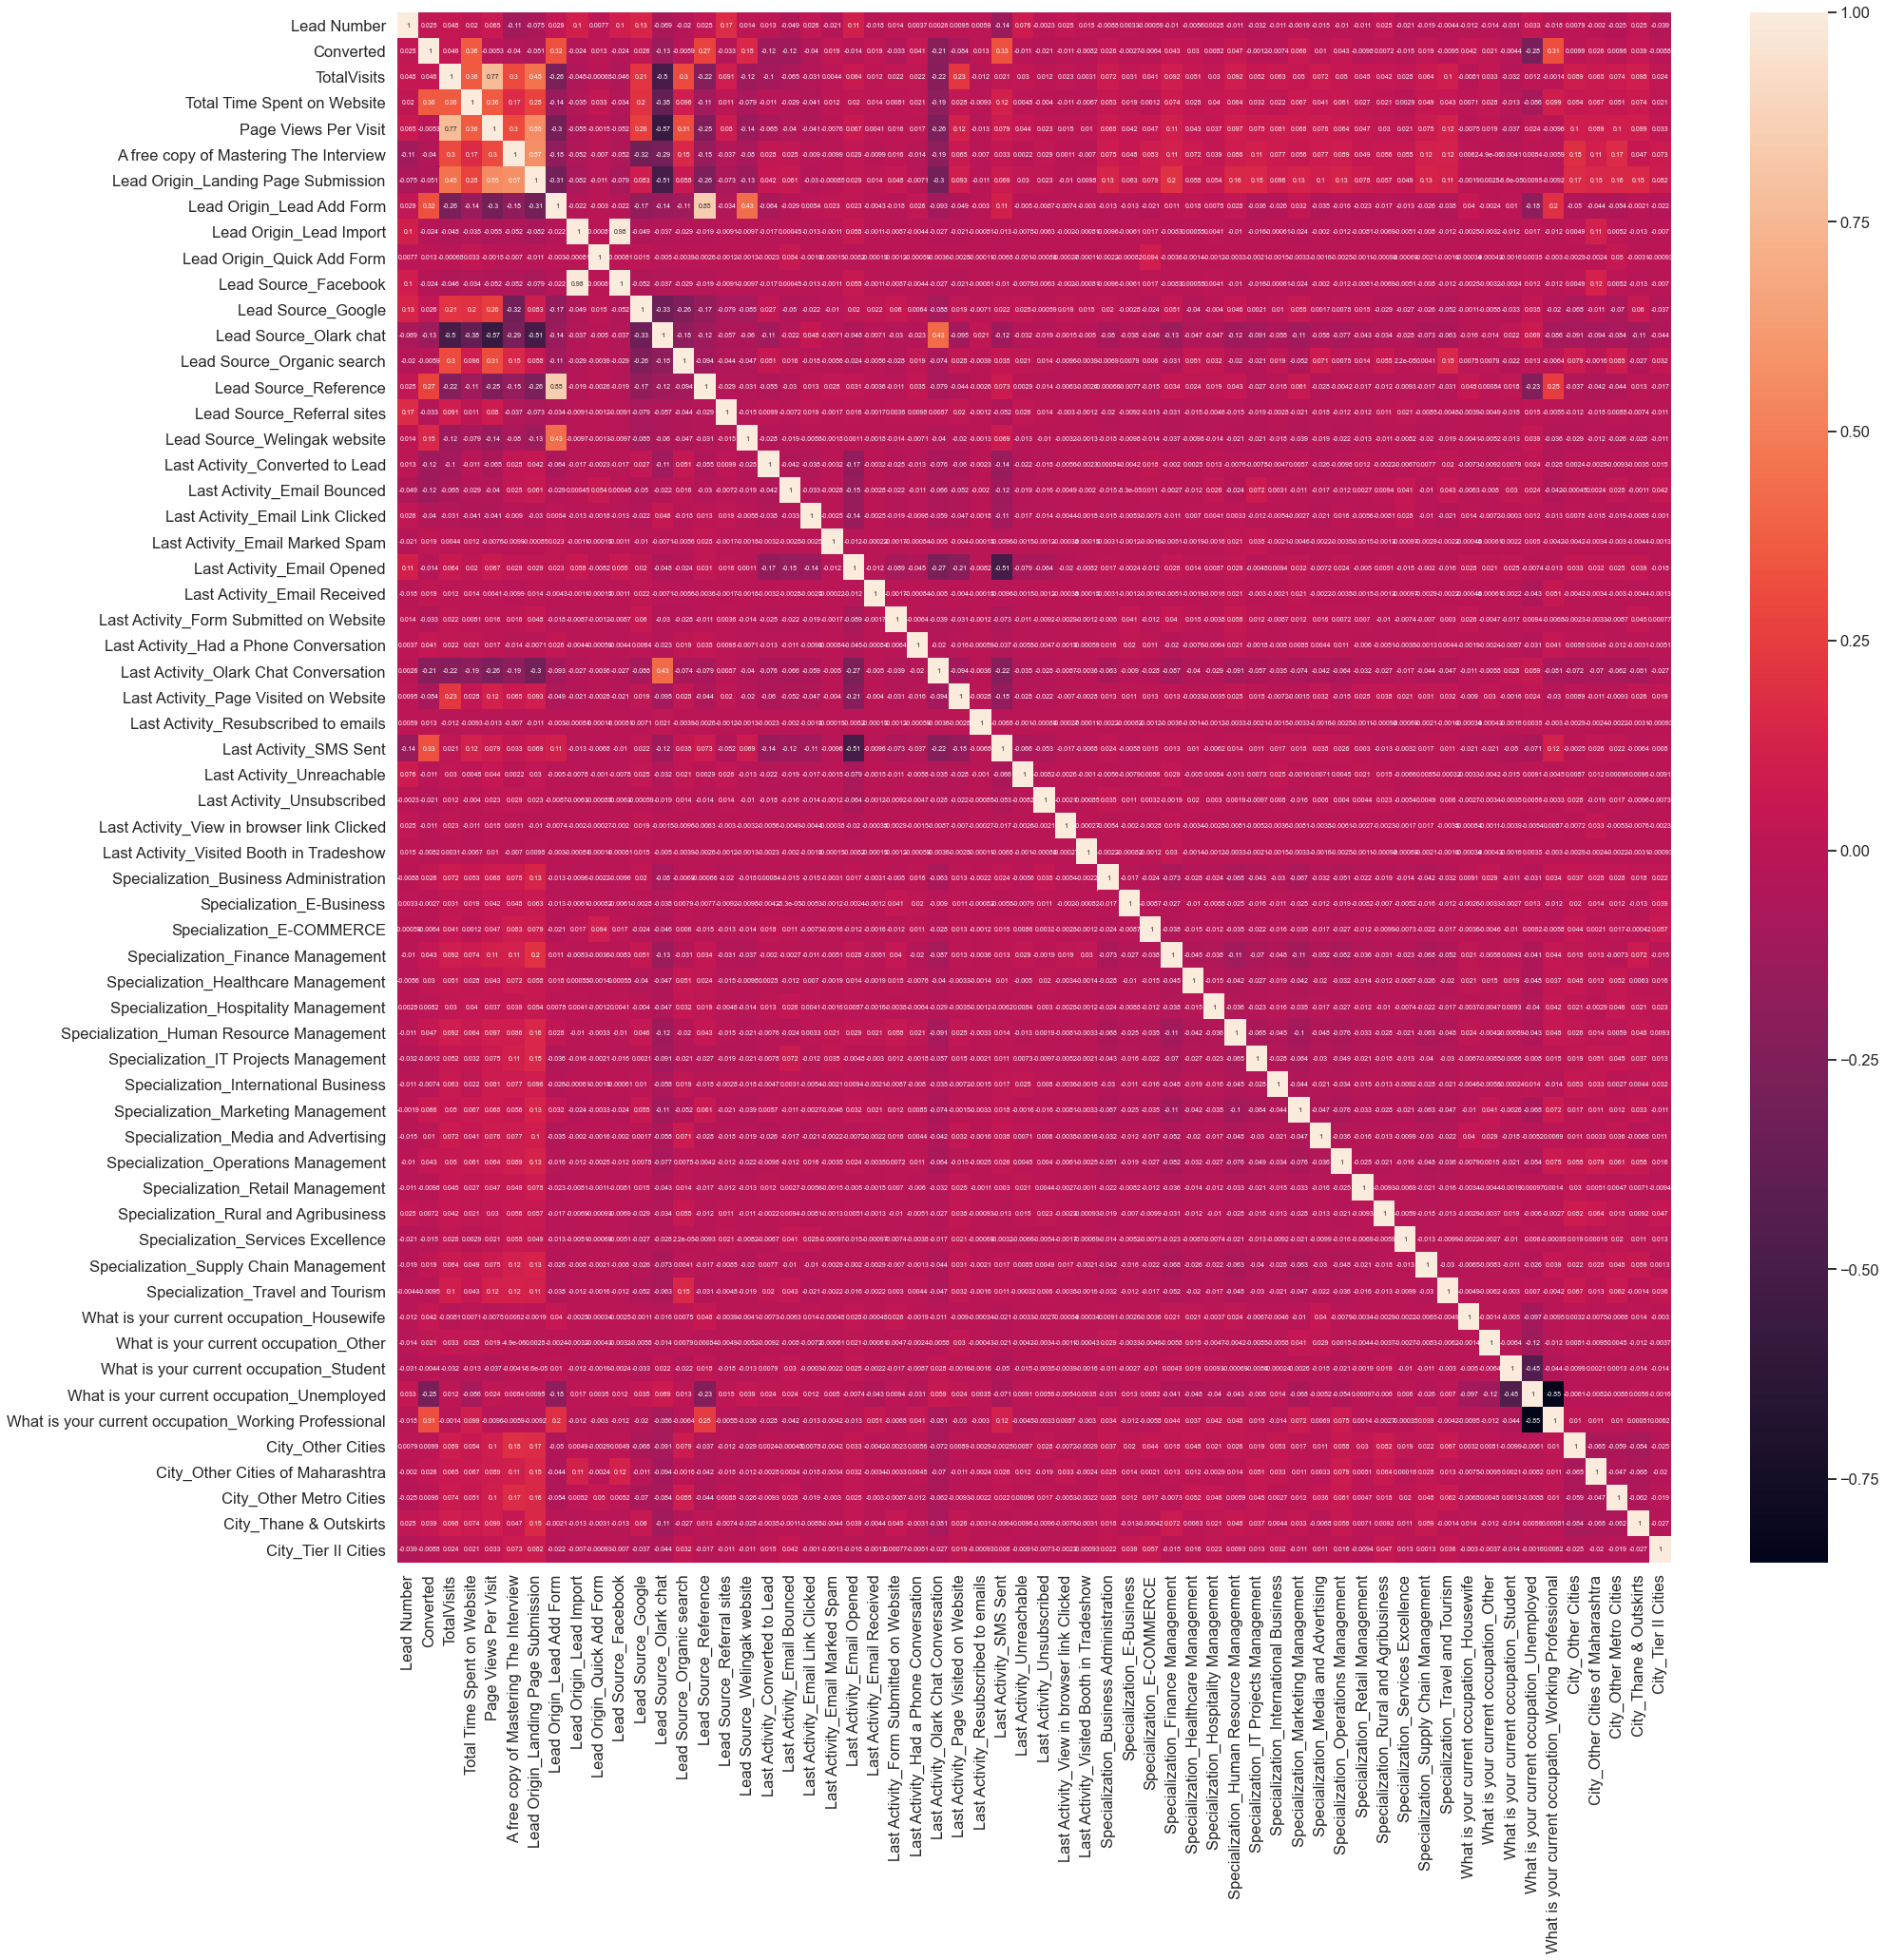

In [160]:
generateHeatmaps(combinedDummyDataset,(30,30))

In [161]:
### Dropping highly correlated variables
X_train = X_train.drop(['Lead Origin_Lead Add Form', 'Lead Source_Facebook'], axis=1)
X_test = X_test.drop(['Lead Origin_Lead Add Form', 'Lead Source_Facebook'], axis=1)

In [162]:
X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1871    -1.149699                    -0.885369             -1.266675   
6795     0.299722                     0.006083             -0.516439   
3516     0.662077                    -0.691050              0.143543   
8105     0.662077                     1.365217              1.553761   
3934    -1.149699                    -0.885369             -1.266675   

      A free copy of Mastering The Interview  \
1871                                       0   
6795                                       1   
3516                                       0   
8105                                       0   
3934                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Import  \
1871                                    0                        0   
6795                                    1                        0   
3516                                    0                        0   
8105                                    1                        0   
3934                                    0                        0   

      Lead Origin_Quick Add Form  Lead Source_Google  Lead Source_Olark chat  \
1871                           0                   0                       1   
6795                           0                   0                       0   
3516                           0                   0                       1   
8105                           0                   1                       0   
3934                           0                   0                       1   

      Lead Source_Organic search  Lead Source_Reference  \
1871                           0                      0   
6795                           0                      0   
3516                           0                      0   
8105                           0                      0   
3934                           0                      0   

      Lead Source_Referral sites  Lead Source_Welingak website  \
1871                           0                             0   
6795                           0                             0   
3516                           0                             0   
8105                           0                             0   
3934                           0                             0   

      Last Activity_Converted to Lead  Last Activity_Email Bounced  \
1871                                0                            0   
6795                                0                            0   
3516                                0                            0   
8105                                0                            0   
3934                                0                            0   

      Last Activity_Email Link Clicked  Last Activity_Email Marked Spam  \
1871                                 0                                0   
6795                                 0                                0   
3516                                 0                                0   
8105                                 0                                0   
3934                                 0                                0   

      Last Activity_Email Opened  Last Activity_Email Received  \
1871                           1                             0   
6795                           1                             0   
3516                           1                             0   
8105                           0                             0   
3934                           1                             0   

      Last Activity_Form Submitted on Website  \
1871                                        0   
6795                                        0   
3516                                        0   
8105                                        0   
3934                                        0   

      Last Activity_Had a Phone Conversation  \
1871              

In [163]:
X_train.shape

(6468, 56)

In [164]:
X_test.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
4269          8.0                        16.85                   6.0   
2376          0.0                         0.00                   0.0   
7766          5.0                         0.98                   5.0   
9199          0.0                         0.00                   0.0   
4359          0.0                         0.00                   0.0   

      A free copy of Mastering The Interview  \
4269                                       0   
2376                                       0   
7766                                       0   
9199                                       0   
4359                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Import  \
4269                                    0                        0   
2376                                    0                        0   
7766                                    0                        0   
9199                                    0                        0   
4359                                    0                        0   

      Lead Origin_Quick Add Form  Lead Source_Google  Lead Source_Olark chat  \
4269                           0                   0                       0   
2376                           0                   0                       0   
7766                           0                   1                       0   
9199                           0                   0                       1   
4359                           0                   0                       0   

      Lead Source_Organic search  Lead Source_Reference  \
4269                           0                      0   
2376                           0                      1   
7766                           0                      0   
9199                           0                      0   
4359                           0                      1   

      Lead Source_Referral sites  Lead Source_Welingak website  \
4269                           0                             0   
2376                           0                             0   
7766                           0                             0   
9199                           0                             0   
4359                           0                             0   

      Last Activity_Converted to Lead  Last Activity_Email Bounced  \
4269                                0                            0   
2376                                0                            0   
7766                                0                            0   
9199                                0                            0   
4359                                0                            0   

      Last Activity_Email Link Clicked  Last Activity_Email Marked Spam  \
4269                                 0                                0   
2376                                 0                                0   
7766                                 0                                0   
9199                                 0                                0   
4359                                 0                                0   

      Last Activity_Email Opened  Last Activity_Email Received  \
4269                           0                             0   
2376                           0                             0   
7766                           0                             0   
9199                           0                             0   
4359                           1                             0   

      Last Activity_Form Submitted on Website  \
4269                                        0   
2376                                        0   
7766                                        0   
9199                                        0   
4359                                        0   

      Last Activity_Had a Phone Conversation  \
4269              

In [165]:
X_test.shape

(2772, 56)

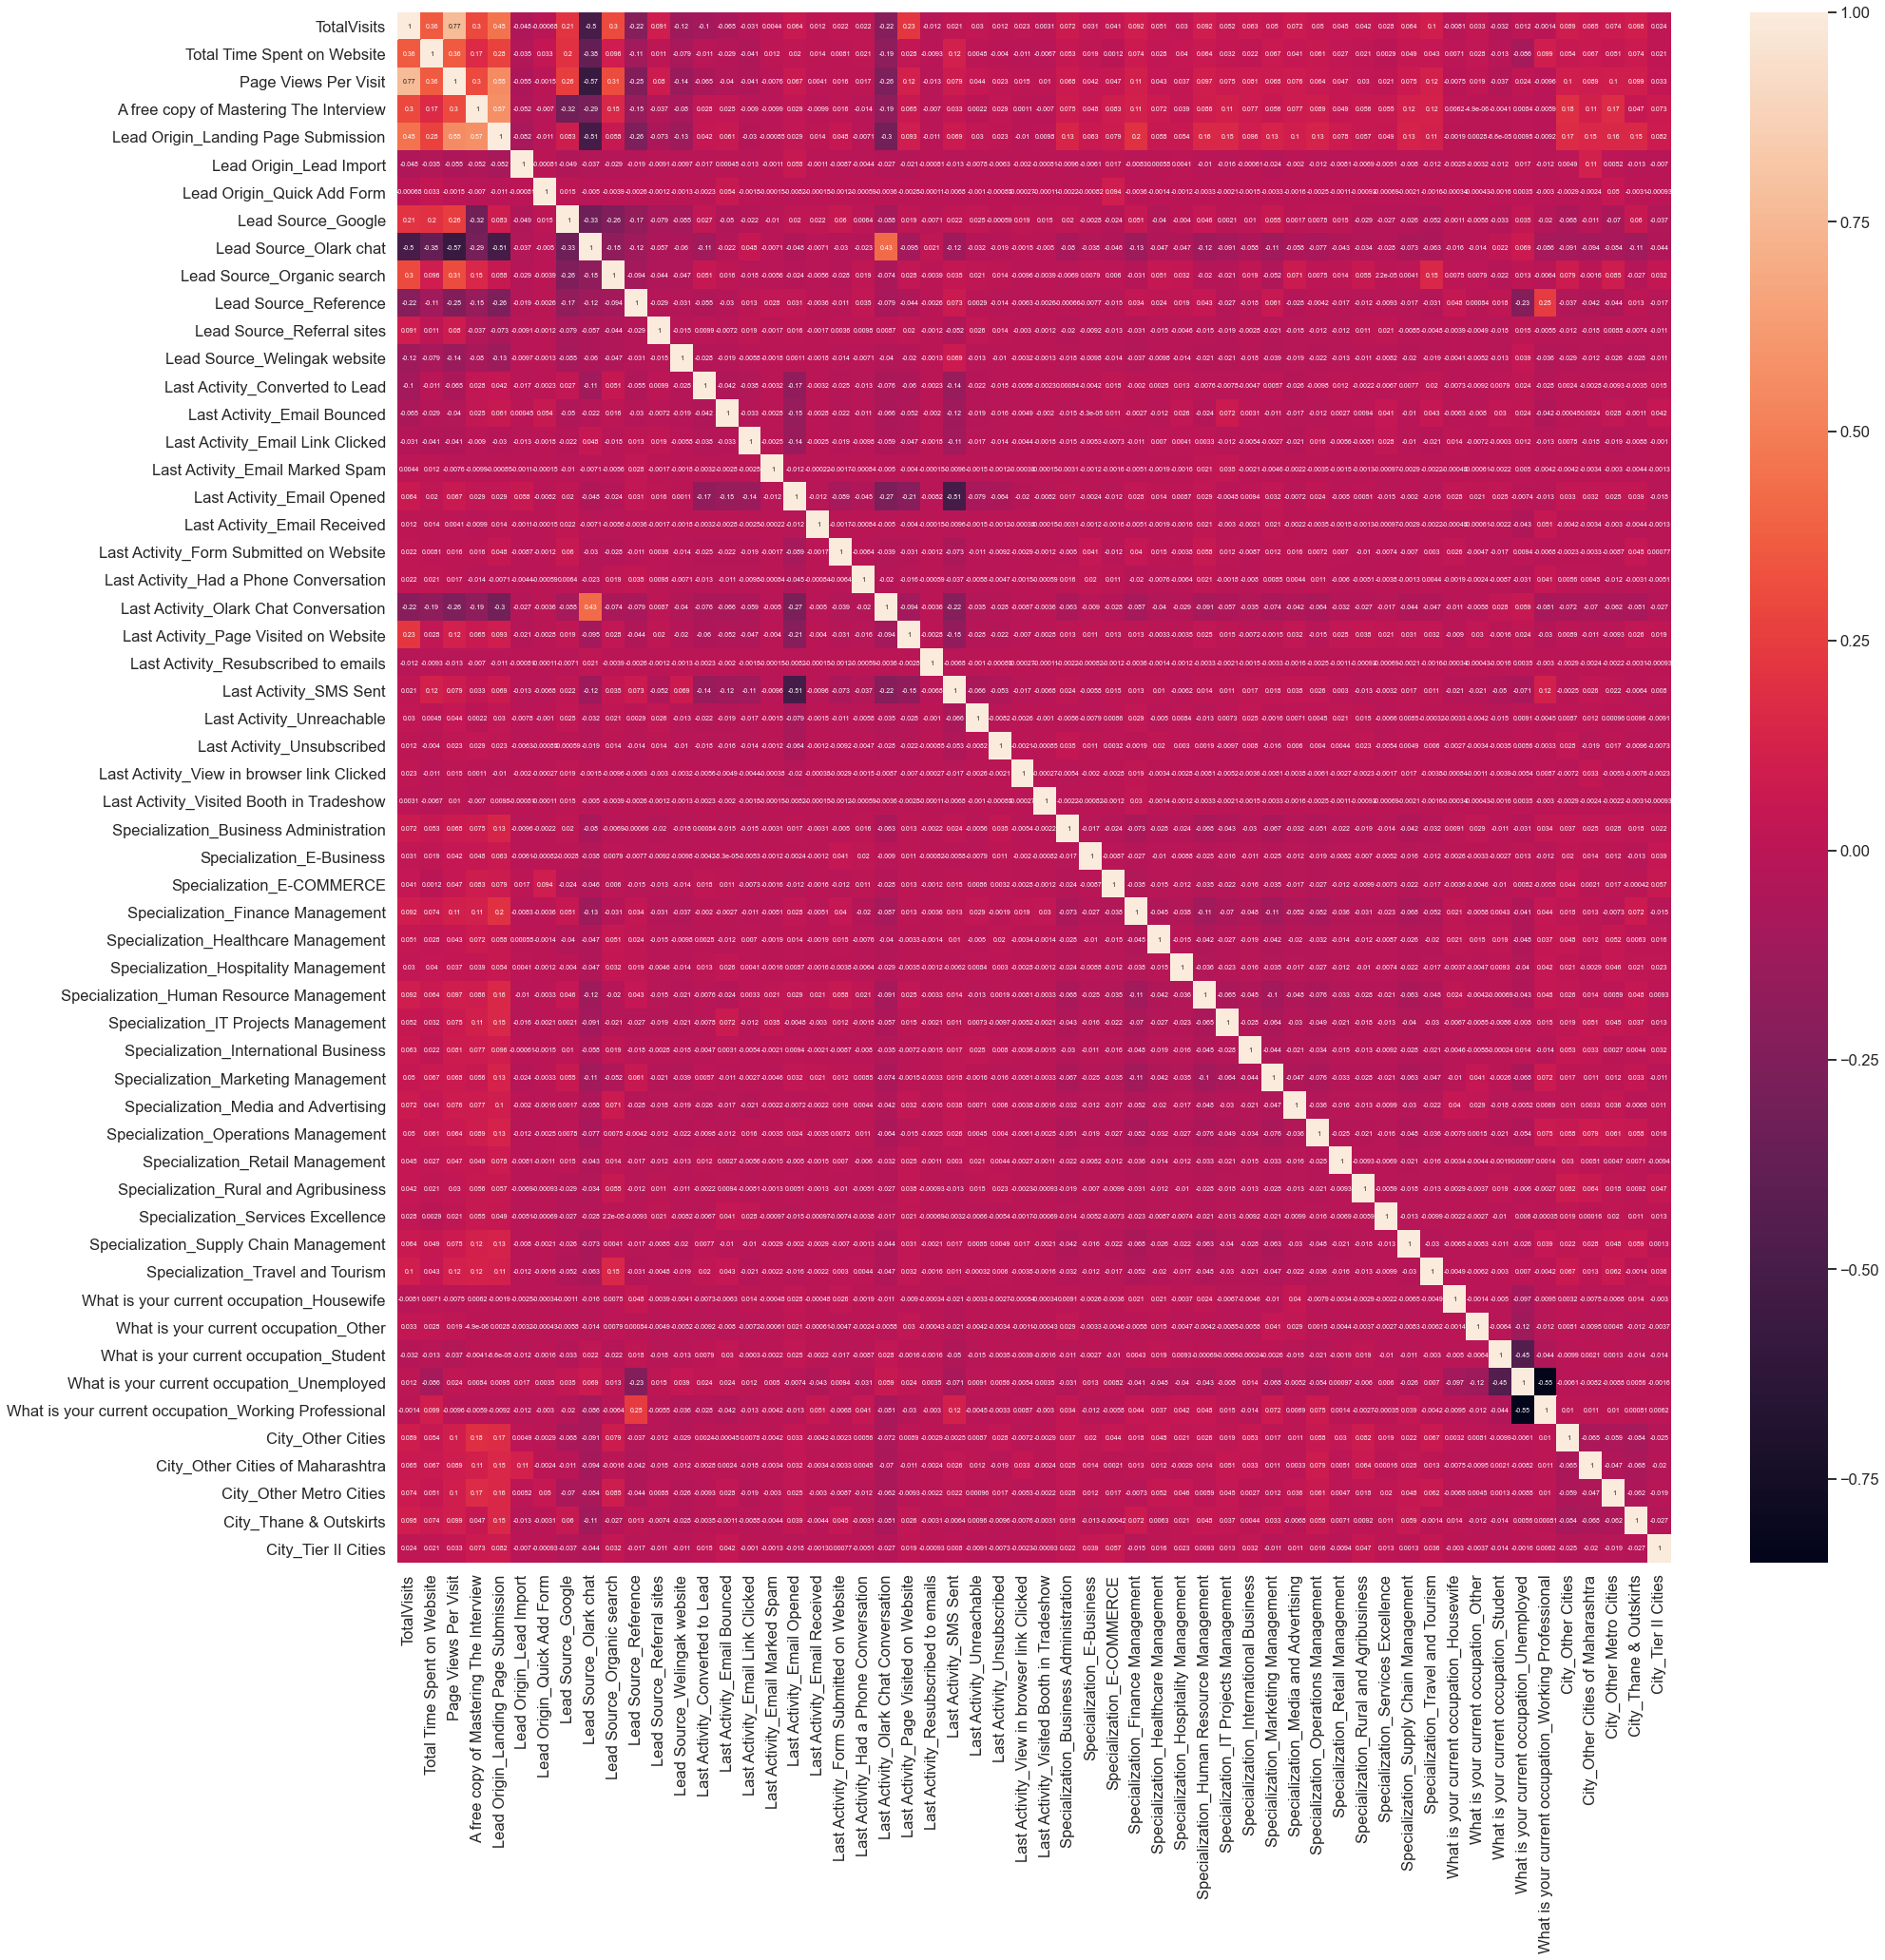

In [166]:
generateHeatmaps(combinedDummyDataset[X_train.columns],(30,30))

### Observation

We have successfully removed the highly corellated variables from the traiing and test datasets. 

We are now ready to train our model

## 3. Modeling

To build our Logistic Regression based model we will do the following:

- Perform GLM analysis on the base model
- Use RFE to perform feature selection 
- Calculate VIF
- Build a model
- Assess parameters & repeat the previous two steps till we have a good model with no multicollinearity 
- Generate prediction probabilities for our existing dataset
- Plot the ROC curve to assess our model
- Check the accuracy, specificity, sensitivity, precision & recall of our model
- Repeat the whole process till an agreeable model is created

### Logistic Regression Model Acceptance Criteria

- The model does not over-fit
- The model is simple enough to be understood
- The model is built using significant features.
- The VIF value is under 3 & the p value is under 0.05 for each feature
- The accuracy, sensitivity and specificity of our model after test are at least 80%(+- 1% between all 3 parameters)


In [167]:
## Creating Logistic Regression Model

logisticRegressionModel = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logisticRegressionModel.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6411
Model Family:                Binomial   Df Model:                           56
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2687.4
Date:                Wed, 05 Aug 2020   Deviance:                       5374.7
Time:                        19:21:27   Pearson chi2:                 9.66e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   22.0679   2.75e+04      0.001      0.999   -5.38e+04    5.39e+04
TotalVisits                                              0.3701      0.054      6.823      0.000       0.264       0.476
Total Time Spent on Website                              1.0606      0.039     26.878      0.000       0.983       1.138
Page Views Per Visit                                    -0.3785      0.060     -6.282      0.000      -0.497      -0.260
A free copy of Mastering The Interview                  -0.2079      0.106     -1.955      0.051      -0.416       0.000
Lead Origin_Landing Page Submission                     -0.7872      0.128     -6.133      0.000      -1.039      -0.536
Lead Origin_Lead Import                                 -0.6152      0.540     -1.140      0.254      -1.673       0.442
Lead Origin_Quick Add Form                              21.9160   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
Lead Source_Google                                       0.2319      0.112      2.075      0.038       0.013       0.451
Lead Source_Olark chat                                   0.9776      0.160      6.116      0.000       0.664       1.291
Lead Source_Organic search                               0.0737      0.131      0.563      0.573      -0.183       0.330
Lead Source_Reference                                    3.1216      0.243     12.862      0.000       2.646       3.597
Lead Source_Referral sites                              -0.0378      0.322     -0.117      0.907      -0.669       0.594
Lead Source_Welingak website                             5.4307      0.740      7.337      0.000       3.980       6.882
Last Activity_Converted to Lead                        -24.4836   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Email Bounced                            -25.1132   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Email Link Clicked                       -23.7712   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Email Marked Spam                         -1.7196   8.41e+04  -2.05e-05      1.000   -1.65e+05    1.65e+05
Last Activity_Email Opened                             -23.2548   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Email Received                            -2.4553   6.13e+04  -4.01e-05      1.000    -1.2e+05     1.2e+05
Last Activity_Form Submitted on Website                -24.2199   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Had a Phone Conversation                 -21.2802   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Olark Chat Conversation                  -24

### RFE

We currently have 56 variables which is very high to create a model. 

We will use RFE to generate a model with 20 variables.

In [168]:
### RFE with 20 variables
logreg = LogisticRegression()

rfe20 = RFE(logreg, 20)
rfe20= rfe20.fit(X_train,y_train)
rfe20.support_

array([False,  True, False, False, False,  True, False, False,  True,
       False,  True, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False])

In [169]:
list(zip(X_train.columns, rfe20.support_, rfe20.ranking_))

[('TotalVisits', False, 17),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 16),
 ('A free copy of Mastering The Interview', False, 21),
 ('Lead Origin_Landing Page Submission', False, 2),
 ('Lead Origin_Lead Import', True, 1),
 ('Lead Origin_Quick Add Form', False, 29),
 ('Lead Source_Google', False, 26),
 ('Lead Source_Olark chat', True, 1),
 ('Lead Source_Organic search', False, 37),
 ('Lead Source_Reference', True, 1),
 ('Lead Source_Referral sites', False, 35),
 ('Lead Source_Welingak website', True, 1),
 ('Last Activity_Converted to Lead', True, 1),
 ('Last Activity_Email Bounced', True, 1),
 ('Last Activity_Email Link Clicked', True, 1),
 ('Last Activity_Email Marked Spam', False, 34),
 ('Last Activity_Email Opened', False, 27),
 ('Last Activity_Email Received', False, 33),
 ('Last Activity_Form Submitted on Website', True, 1),
 ('Last Activity_Had a Phone Conversation', True, 1),
 ('Last Activity_Olark Chat Conversation', True, 1),
 ('Last Activity_

In [170]:
col = X_train.columns[rfe20.support_]

In [171]:
X_train.columns[~rfe20.support_]

Index(['TotalVisits', 'Page Views Per Visit',
       'A free copy of Mastering The Interview',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Quick Add Form',
       'Lead Source_Google', 'Lead Source_Organic search',
       'Lead Source_Referral sites', 'Last Activity_Email Marked Spam',
       'Last Activity_Email Opened', 'Last Activity_Email Received',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Last Activity_View in browser link Clicked',
       'Last Activity_Visited Booth in Tradeshow',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specialization_IT Projects Management',
       'Specialization_International Business',
       'Specialization_Marketing Management',
       'Specializati

In [172]:
X_train_cols = X_train[col]
X_train_cols

Total Time Spent on Website  Lead Origin_Lead Import  \
1871                    -0.885369                        0   
6795                     0.006083                        0   
3516                    -0.691050                        0   
8105                     1.365217                        0   
3934                    -0.885369                        0   
...                           ...                      ...   
350                     -0.885369                        0   
79                       0.404601                        0   
8039                    -0.885369                        0   
6936                    -0.449523                        0   
5640                    -0.885369                        0   

      Lead Source_Olark chat  Lead Source_Reference  \
1871                       1                      0   
6795                       0                      0   
3516                       1                      0   
8105                       0                      0   
3934                       1                      0   
...                      ...                    ...   
350                        0                      0   
79                         0                      1   
8039                       1                      0   
6936                       0                      0   
5640                       1                      0   

      Lead Source_Welingak website  Last Activity_Converted to Lead  \
1871                             0                                0   
6795                             0                                0   
3516                             0                                0   
8105                             0                                0   
3934                             0                                0   
...                            ...                              ...   
350                              0                                0   
79                               0                                0   
8039                             0                                0   
6936                             0                                1   
5640                             0                                0   

      Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
1871                            0                                 0   
6795                            0                                 0   
3516                            0                                 0   
8105                            0                                 0   
3934                            0                                 0   
...                           ...                               ...   
350                             0                                 0   
79                              0                                 0   
8039                            0                                 0   
6936                            0                                 0   
5640                            0                                 0   

      Last Activity_Form Submitted on Website  \
1871                                        0   
6795                                        0   
3516                                        0   
8105                                        0   
3934                                        0   
...                                       ...   
350                                         0   
79                                          0   
8039                                        0   
6936                                        0   
5640                                        0   

      Last Activity_Had a Phone Conversation  \
1871                                       0   
6795                                       0   
3516                                       0   
8105                                       0   
3934                                       0   
...              

### Assessing the model

In [173]:
X_train_sm = sm.add_constant(X_train_cols)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6447
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2777.9
Date:                Wed, 05 Aug 2020   Deviance:                       5555.8
Time:                        19:21:29   Pearson chi2:                 9.22e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.7168      1.128     -0.635      0.525      -2.928       1.495
Total Time Spent on Website                              1.0683      0.038     27.842      0.000       0.993       1.143
Lead Origin_Lead Import                                 -0.3352      0.521     -0.643      0.520      -1.356       0.686
Lead Source_Olark chat                                   1.1074      0.100     11.055      0.000       0.911       1.304
Lead Source_Reference                                    3.5655      0.201     17.708      0.000       3.171       3.960
Lead Source_Welingak website                             5.4925      0.728      7.542      0.000       4.065       6.920
Last Activity_Converted to Lead                         -1.3514      0.219     -6.173      0.000      -1.781      -0.922
Last Activity_Email Bounced                             -1.9249      0.283     -6.811      0.000      -2.479      -1.371
Last Activity_Email Link Clicked                        -0.5831      0.220     -2.650      0.008      -1.014      -0.152
Last Activity_Form Submitted on Website                 -0.7275      0.337     -2.160      0.031      -1.388      -0.067
Last Activity_Had a Phone Conversation                   2.0348      0.653      3.118      0.002       0.756       3.314
Last Activity_Olark Chat Conversation                   -1.5017      0.164     -9.179      0.000      -1.822      -1.181
Last Activity_Page Visited on Website                   -0.6377      0.143     -4.462      0.000      -0.918      -0.358
Last Activity_Resubscribed to emails                    23.6935   4.82e+04      0.000      1.000   -9.44e+04    9.45e+04
Last Activity_SMS Sent                                   1.0635      0.076     14.074      0.000       0.915       1.212
Specialization_Rural and Agribusiness                    0.6267      0.376      1.667      0.095      -0.110       1.363
What is your current occupation_Housewife               22.4127   1.37e+04      0.002      0.999   -2.68e+04    2.69e+04
What is your current occupation_Other                   -0.5050      1.378     -0.367      0.714      -3.205       2.195
What is your current occupation_Student                 -0.1975      1.150     -0.172      0.864      -2.451       2.056
What is your current occupation_Unemployed              -0.5722      1.128     -0.507      0.612      -2.783       1.638
What is your current occupation_Working Professional     2.2682      1.142      1.986      0.047       0.030       4.506
========================================================================================================================
"""

In [174]:
### Checking VIF values

vifCalculator(X_train_cols)

Features   VIF
18         What is your current occupation_Unemployed  2.75
13                             Last Activity_SMS Sent  1.79
2                              Lead Source_Olark chat  1.79
10              Last Activity_Olark Chat Conversation  1.49
19  What is your current occupation_Working Profes...  1.30
0                         Total Time Spent on Website  1.25
3                               Lead Source_Reference  1.21
11              Last Activity_Page Visited on Website  1.20
5                     Last Activity_Converted to Lead  1.14
6                         Last Activity_Email Bounced  1.10
7                    Last Activity_Email Link Clicked  1.08
4                        Lead Source_Welingak website  1.04
17            What is your current occupation_Student  1.04
8             Last Activity_Form Submitted on Website  1.03
9              Last Activity_Had a Phone Conversation  1.01
1                             Lead Origin_Lead Import  1.01
14              Specialization_Rural and Agribusiness  1.01
15          What is your current occupation_Housewife  1.01
12               Last Activity_Resubscribed to emails  1.00
16              What is your current occupation_Other  1.00

### Observation 

- The VIF values for all the variables in the model look to be under control
- The p value for What is your current occupation_Housewife is very high at 0.999 & above the threshold 0.05

We will be dropping What is your current occupation_Housewife in the next model 

In [175]:
X_train_cols = X_train_cols.drop('What is your current occupation_Housewife', axis=1)
X_train_cols.columns

Index(['Total Time Spent on Website', 'Lead Origin_Lead Import',
       'Lead Source_Olark chat', 'Lead Source_Reference',
       'Lead Source_Welingak website', 'Last Activity_Converted to Lead',
       'Last Activity_Email Bounced', 'Last Activity_Email Link Clicked',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Page Visited on Website',
       'Last Activity_Resubscribed to emails', 'Last Activity_SMS Sent',
       'Specialization_Rural and Agribusiness',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [176]:
### Rerun the model with the selected variables
X_train_sm = sm.add_constant(X_train_cols)
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6448
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2780.6
Date:                Wed, 05 Aug 2020   Deviance:                       5561.2
Time:                        19:21:29   Pearson chi2:                 9.22e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.9393      0.772      1.217      0.224      -0.573       2.452
Total Time Spent on Website                              1.0676      0.038     27.831      0.000       0.992       1.143
Lead Origin_Lead Import                                 -0.3369      0.521     -0.647      0.518      -1.358       0.684
Lead Source_Olark chat                                   1.1050      0.100     11.035      0.000       0.909       1.301
Lead Source_Reference                                    3.5640      0.201     17.710      0.000       3.170       3.958
Lead Source_Welingak website                             5.4907      0.728      7.539      0.000       4.063       6.918
Last Activity_Converted to Lead                         -1.3531      0.219     -6.181      0.000      -1.782      -0.924
Last Activity_Email Bounced                             -1.9261      0.283     -6.816      0.000      -2.480      -1.372
Last Activity_Email Link Clicked                        -0.5821      0.220     -2.649      0.008      -1.013      -0.151
Last Activity_Form Submitted on Website                 -0.7363      0.334     -2.206      0.027      -1.391      -0.082
Last Activity_Had a Phone Conversation                   2.0327      0.652      3.115      0.002       0.754       3.312
Last Activity_Olark Chat Conversation                   -1.5088      0.164     -9.215      0.000      -1.830      -1.188
Last Activity_Page Visited on Website                   -0.6440      0.143     -4.508      0.000      -0.924      -0.364
Last Activity_Resubscribed to emails                    21.6932   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
Last Activity_SMS Sent                                   1.0619      0.076     14.058      0.000       0.914       1.210
Specialization_Rural and Agribusiness                    0.6262      0.376      1.667      0.096      -0.110       1.363
What is your current occupation_Other                   -2.1574      1.106     -1.951      0.051      -4.324       0.010
What is your current occupation_Student                 -1.8515      0.803     -2.306      0.021      -3.425      -0.278
What is your current occupation_Unemployed              -2.2262      0.772     -2.885      0.004      -3.738      -0.714
What is your current occupation_Working Professional     0.6141      0.791      0.776      0.438      -0.937       2.165
========================================================================================================================
"""

In [177]:
vifCalculator(X_train_cols)

Features   VIF
17         What is your current occupation_Unemployed  2.75
2                              Lead Source_Olark chat  1.79
13                             Last Activity_SMS Sent  1.79
10              Last Activity_Olark Chat Conversation  1.49
18  What is your current occupation_Working Profes...  1.29
0                         Total Time Spent on Website  1.25
11              Last Activity_Page Visited on Website  1.20
3                               Lead Source_Reference  1.20
5                     Last Activity_Converted to Lead  1.14
6                         Last Activity_Email Bounced  1.10
7                    Last Activity_Email Link Clicked  1.08
4                        Lead Source_Welingak website  1.04
16            What is your current occupation_Student  1.04
8             Last Activity_Form Submitted on Website  1.03
1                             Lead Origin_Lead Import  1.01
14              Specialization_Rural and Agribusiness  1.01
9              Last Activity_Had a Phone Conversation  1.01
12               Last Activity_Resubscribed to emails  1.00
15              What is your current occupation_Other  1.00

### Observation


- The VIF values for all the variables in the model look to be under control
- The p value for Last Activity_Resubscribed to emails is very high at 0.999 & above the threshold 0.05

We will be dropping Last Activity_Resubscribed to emails in the next model 

### Model 4

In [178]:
X_train_cols = X_train_cols.drop('Last Activity_Resubscribed to emails', axis=1)
X_train_cols.columns

Index(['Total Time Spent on Website', 'Lead Origin_Lead Import',
       'Lead Source_Olark chat', 'Lead Source_Reference',
       'Lead Source_Welingak website', 'Last Activity_Converted to Lead',
       'Last Activity_Email Bounced', 'Last Activity_Email Link Clicked',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'Specialization_Rural and Agribusiness',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [179]:
X_train_sm = sm.add_constant(X_train_cols)
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6449
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2782.0
Date:                Wed, 05 Aug 2020   Deviance:                       5564.0
Time:                        19:21:29   Pearson chi2:                 9.22e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.9399      0.772      1.218      0.223      -0.573       2.452
Total Time Spent on Website                              1.0674      0.038     27.827      0.000       0.992       1.143
Lead Origin_Lead Import                                 -0.3374      0.521     -0.648      0.517      -1.358       0.683
Lead Source_Olark chat                                   1.1096      0.100     11.088      0.000       0.913       1.306
Lead Source_Reference                                    3.5636      0.201     17.709      0.000       3.169       3.958
Lead Source_Welingak website                             5.4905      0.728      7.539      0.000       4.063       6.918
Last Activity_Converted to Lead                         -1.3540      0.219     -6.186      0.000      -1.783      -0.925
Last Activity_Email Bounced                             -1.9276      0.283     -6.822      0.000      -2.481      -1.374
Last Activity_Email Link Clicked                        -0.5848      0.220     -2.662      0.008      -1.015      -0.154
Last Activity_Form Submitted on Website                 -0.7379      0.334     -2.210      0.027      -1.392      -0.084
Last Activity_Had a Phone Conversation                   2.0316      0.652      3.114      0.002       0.753       3.310
Last Activity_Olark Chat Conversation                   -1.5130      0.164     -9.243      0.000      -1.834      -1.192
Last Activity_Page Visited on Website                   -0.6453      0.143     -4.517      0.000      -0.925      -0.365
Last Activity_SMS Sent                                   1.0601      0.076     14.039      0.000       0.912       1.208
Specialization_Rural and Agribusiness                    0.6256      0.376      1.665      0.096      -0.111       1.362
What is your current occupation_Other                   -2.1570      1.106     -1.951      0.051      -4.324       0.010
What is your current occupation_Student                 -1.8526      0.803     -2.307      0.021      -3.426      -0.279
What is your current occupation_Unemployed              -2.2257      0.772     -2.885      0.004      -3.738      -0.714
What is your current occupation_Working Professional     0.6139      0.791      0.776      0.438      -0.937       2.165
========================================================================================================================
"""

In [180]:
vifCalculator(X_train_cols)

Features   VIF
16         What is your current occupation_Unemployed  2.75
2                              Lead Source_Olark chat  1.79
12                             Last Activity_SMS Sent  1.79
10              Last Activity_Olark Chat Conversation  1.49
17  What is your current occupation_Working Profes...  1.29
0                         Total Time Spent on Website  1.25
11              Last Activity_Page Visited on Website  1.20
3                               Lead Source_Reference  1.20
5                     Last Activity_Converted to Lead  1.14
6                         Last Activity_Email Bounced  1.10
7                    Last Activity_Email Link Clicked  1.08
4                        Lead Source_Welingak website  1.04
15            What is your current occupation_Student  1.04
8             Last Activity_Form Submitted on Website  1.03
1                             Lead Origin_Lead Import  1.01
13              Specialization_Rural and Agribusiness  1.01
9              Last Activity_Had a Phone Conversation  1.01
14              What is your current occupation_Other  1.00

### Observation

- The p value for Lead Origin_Lead Import is very high at 0.517 & above the threshold 0.05

We will be dropping Lead Origin_Lead Import in the next model

### Model 5

In [181]:
X_train_cols = X_train_cols.drop('Lead Origin_Lead Import', axis=1)
X_train_cols.columns

Index(['Total Time Spent on Website', 'Lead Source_Olark chat',
       'Lead Source_Reference', 'Lead Source_Welingak website',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'Specialization_Rural and Agribusiness',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [182]:
X_train_sm = sm.add_constant(X_train_cols)
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6450
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2782.2
Date:                Wed, 05 Aug 2020   Deviance:                       5564.5
Time:                        19:21:29   Pearson chi2:                 9.22e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.9381      0.772      1.216      0.224      -0.574       2.451
Total Time Spent on Website                              1.0686      0.038     27.886      0.000       0.993       1.144
Lead Source_Olark chat                                   1.1130      0.100     11.135      0.000       0.917       1.309
Lead Source_Reference                                    3.5672      0.201     17.731      0.000       3.173       3.961
Lead Source_Welingak website                             5.4939      0.728      7.544      0.000       4.067       6.921
Last Activity_Converted to Lead                         -1.3513      0.219     -6.174      0.000      -1.780      -0.922
Last Activity_Email Bounced                             -1.9257      0.283     -6.814      0.000      -2.480      -1.372
Last Activity_Email Link Clicked                        -0.5827      0.220     -2.652      0.008      -1.013      -0.152
Last Activity_Form Submitted on Website                 -0.7356      0.334     -2.203      0.028      -1.390      -0.081
Last Activity_Had a Phone Conversation                   2.0350      0.653      3.119      0.002       0.756       3.314
Last Activity_Olark Chat Conversation                   -1.5117      0.164     -9.235      0.000      -1.833      -1.191
Last Activity_Page Visited on Website                   -0.6429      0.143     -4.501      0.000      -0.923      -0.363
Last Activity_SMS Sent                                   1.0615      0.075     14.063      0.000       0.914       1.209
Specialization_Rural and Agribusiness                    0.6275      0.376      1.670      0.095      -0.109       1.364
What is your current occupation_Other                   -2.1575      1.106     -1.951      0.051      -4.325       0.010
What is your current occupation_Student                 -1.8526      0.803     -2.307      0.021      -3.427      -0.279
What is your current occupation_Unemployed              -2.2273      0.772     -2.887      0.004      -3.739      -0.715
What is your current occupation_Working Professional     0.6115      0.791      0.773      0.440      -0.940       2.163
========================================================================================================================
"""

In [183]:
vifCalculator(X_train_cols)

Features   VIF
15         What is your current occupation_Unemployed  2.72
11                             Last Activity_SMS Sent  1.79
1                              Lead Source_Olark chat  1.78
9               Last Activity_Olark Chat Conversation  1.49
16  What is your current occupation_Working Profes...  1.29
0                         Total Time Spent on Website  1.24
2                               Lead Source_Reference  1.20
10              Last Activity_Page Visited on Website  1.19
4                     Last Activity_Converted to Lead  1.14
5                         Last Activity_Email Bounced  1.10
6                    Last Activity_Email Link Clicked  1.08
3                        Lead Source_Welingak website  1.04
14            What is your current occupation_Student  1.04
7             Last Activity_Form Submitted on Website  1.03
12              Specialization_Rural and Agribusiness  1.01
8              Last Activity_Had a Phone Conversation  1.01
13              What is your current occupation_Other  1.00

### Observation

- The p value for What is your current occupation_Working Professional is above the threshold at 0.440

We will be dropping this variable in the next model

### Model 6

In [184]:
X_train_cols = X_train_cols.drop('What is your current occupation_Working Professional', axis=1)
X_train_cols.columns 


Index(['Total Time Spent on Website', 'Lead Source_Olark chat',
       'Lead Source_Reference', 'Lead Source_Welingak website',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'Specialization_Rural and Agribusiness',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed'],
      dtype='object')

In [185]:
X_train_sm = sm.add_constant(X_train_cols)
logm6 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6451
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2782.5
Date:                Wed, 05 Aug 2020   Deviance:                       5565.1
Time:                        19:21:29   Pearson chi2:                 9.14e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          1.5202      0.182      8.356      0.000       1.164       1.877
Total Time Spent on Website                    1.0689      0.038     27.893      0.000       0.994       1.144
Lead Source_Olark chat                         1.1134      0.100     11.141      0.000       0.918       1.309
Lead Source_Reference                          3.5664      0.201     17.726      0.000       3.172       3.961
Lead Source_Welingak website                   5.4938      0.728      7.544      0.000       4.066       6.921
Last Activity_Converted to Lead               -1.3481      0.219     -6.168      0.000      -1.776      -0.920
Last Activity_Email Bounced                   -1.9240      0.282     -6.813      0.000      -2.477      -1.371
Last Activity_Email Link Clicked              -0.5824      0.220     -2.651      0.008      -1.013      -0.152
Last Activity_Form Submitted on Website       -0.7586      0.335     -2.263      0.024      -1.416      -0.102
Last Activity_Had a Phone Conversation         2.0357      0.652      3.120      0.002       0.757       3.314
Last Activity_Olark Chat Conversation         -1.5141      0.164     -9.246      0.000      -1.835      -1.193
Last Activity_Page Visited on Website         -0.6443      0.143     -4.512      0.000      -0.924      -0.364
Last Activity_SMS Sent                         1.0621      0.075     14.075      0.000       0.914       1.210
Specialization_Rural and Agribusiness          0.6279      0.376      1.671      0.095      -0.108       1.364
What is your current occupation_Other         -2.7392      0.813     -3.369      0.001      -4.333      -1.146
What is your current occupation_Student       -2.4348      0.287     -8.485      0.000      -2.997      -1.872
What is your current occupation_Unemployed    -2.8095      0.181    -15.520      0.000      -3.164      -2.455
==============================================================================================================
"""

In [186]:
vifCalculator(X_train_cols)

Features   VIF
15  What is your current occupation_Unemployed  2.46
1                       Lead Source_Olark chat  1.75
11                      Last Activity_SMS Sent  1.61
9        Last Activity_Olark Chat Conversation  1.48
0                  Total Time Spent on Website  1.21
10       Last Activity_Page Visited on Website  1.17
4              Last Activity_Converted to Lead  1.12
2                        Lead Source_Reference  1.09
5                  Last Activity_Email Bounced  1.09
6             Last Activity_Email Link Clicked  1.07
3                 Lead Source_Welingak website  1.04
14     What is your current occupation_Student  1.04
7      Last Activity_Form Submitted on Website  1.03
8       Last Activity_Had a Phone Conversation  1.01
12       Specialization_Rural and Agribusiness  1.01
13       What is your current occupation_Other  1.00

### Observation

The model seems to be coming well under control however:

- The p value for Specialization_Rural and Agribusiness is slightly above the threshold at 0.5

We will be dropping this variable in the next model

### Model 7

In [187]:
X_train_cols = X_train_cols.drop('Specialization_Rural and Agribusiness', axis=1)
X_train_cols.columns 

Index(['Total Time Spent on Website', 'Lead Source_Olark chat',
       'Lead Source_Reference', 'Lead Source_Welingak website',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed'],
      dtype='object')

In [188]:
X_train_sm = sm.add_constant(X_train_cols)
logm7 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm7.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2783.9
Date:                Wed, 05 Aug 2020   Deviance:                       5567.8
Time:                        19:21:30   Pearson chi2:                 9.13e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          1.5252      0.182      8.387      0.000       1.169       1.882
Total Time Spent on Website                    1.0683      0.038     27.890      0.000       0.993       1.143
Lead Source_Olark chat                         1.1104      0.100     11.117      0.000       0.915       1.306
Lead Source_Reference                          3.5638      0.201     17.718      0.000       3.170       3.958
Lead Source_Welingak website                   5.4885      0.728      7.536      0.000       4.061       6.916
Last Activity_Converted to Lead               -1.3461      0.219     -6.158      0.000      -1.775      -0.918
Last Activity_Email Bounced                   -1.9256      0.282     -6.816      0.000      -2.479      -1.372
Last Activity_Email Link Clicked              -0.5873      0.220     -2.674      0.007      -1.018      -0.157
Last Activity_Form Submitted on Website       -0.7636      0.335     -2.279      0.023      -1.420      -0.107
Last Activity_Had a Phone Conversation         2.0298      0.652      3.111      0.002       0.751       3.308
Last Activity_Olark Chat Conversation         -1.5187      0.164     -9.277      0.000      -1.840      -1.198
Last Activity_Page Visited on Website         -0.6397      0.143     -4.488      0.000      -0.919      -0.360
Last Activity_SMS Sent                         1.0606      0.075     14.060      0.000       0.913       1.208
What is your current occupation_Other         -2.7448      0.813     -3.376      0.001      -4.338      -1.151
What is your current occupation_Student       -2.4126      0.286     -8.429      0.000      -2.974      -1.852
What is your current occupation_Unemployed    -2.8085      0.181    -15.523      0.000      -3.163      -2.454
==============================================================================================================
"""

In [189]:
vifCalculator(X_train_cols)

Features   VIF
14  What is your current occupation_Unemployed  2.46
1                       Lead Source_Olark chat  1.75
11                      Last Activity_SMS Sent  1.61
9        Last Activity_Olark Chat Conversation  1.48
0                  Total Time Spent on Website  1.21
10       Last Activity_Page Visited on Website  1.17
4              Last Activity_Converted to Lead  1.12
2                        Lead Source_Reference  1.09
5                  Last Activity_Email Bounced  1.09
6             Last Activity_Email Link Clicked  1.07
3                 Lead Source_Welingak website  1.04
7      Last Activity_Form Submitted on Website  1.03
13     What is your current occupation_Student  1.03
8       Last Activity_Had a Phone Conversation  1.01
12       What is your current occupation_Other  1.00

### Observation

Model 7 meets all our criteria:

- The VIF values are under 3
- The p values are under 0.05
- The 15 selected features look significant

Let us generate a heatmap to confirm that there is no multicollinearity 

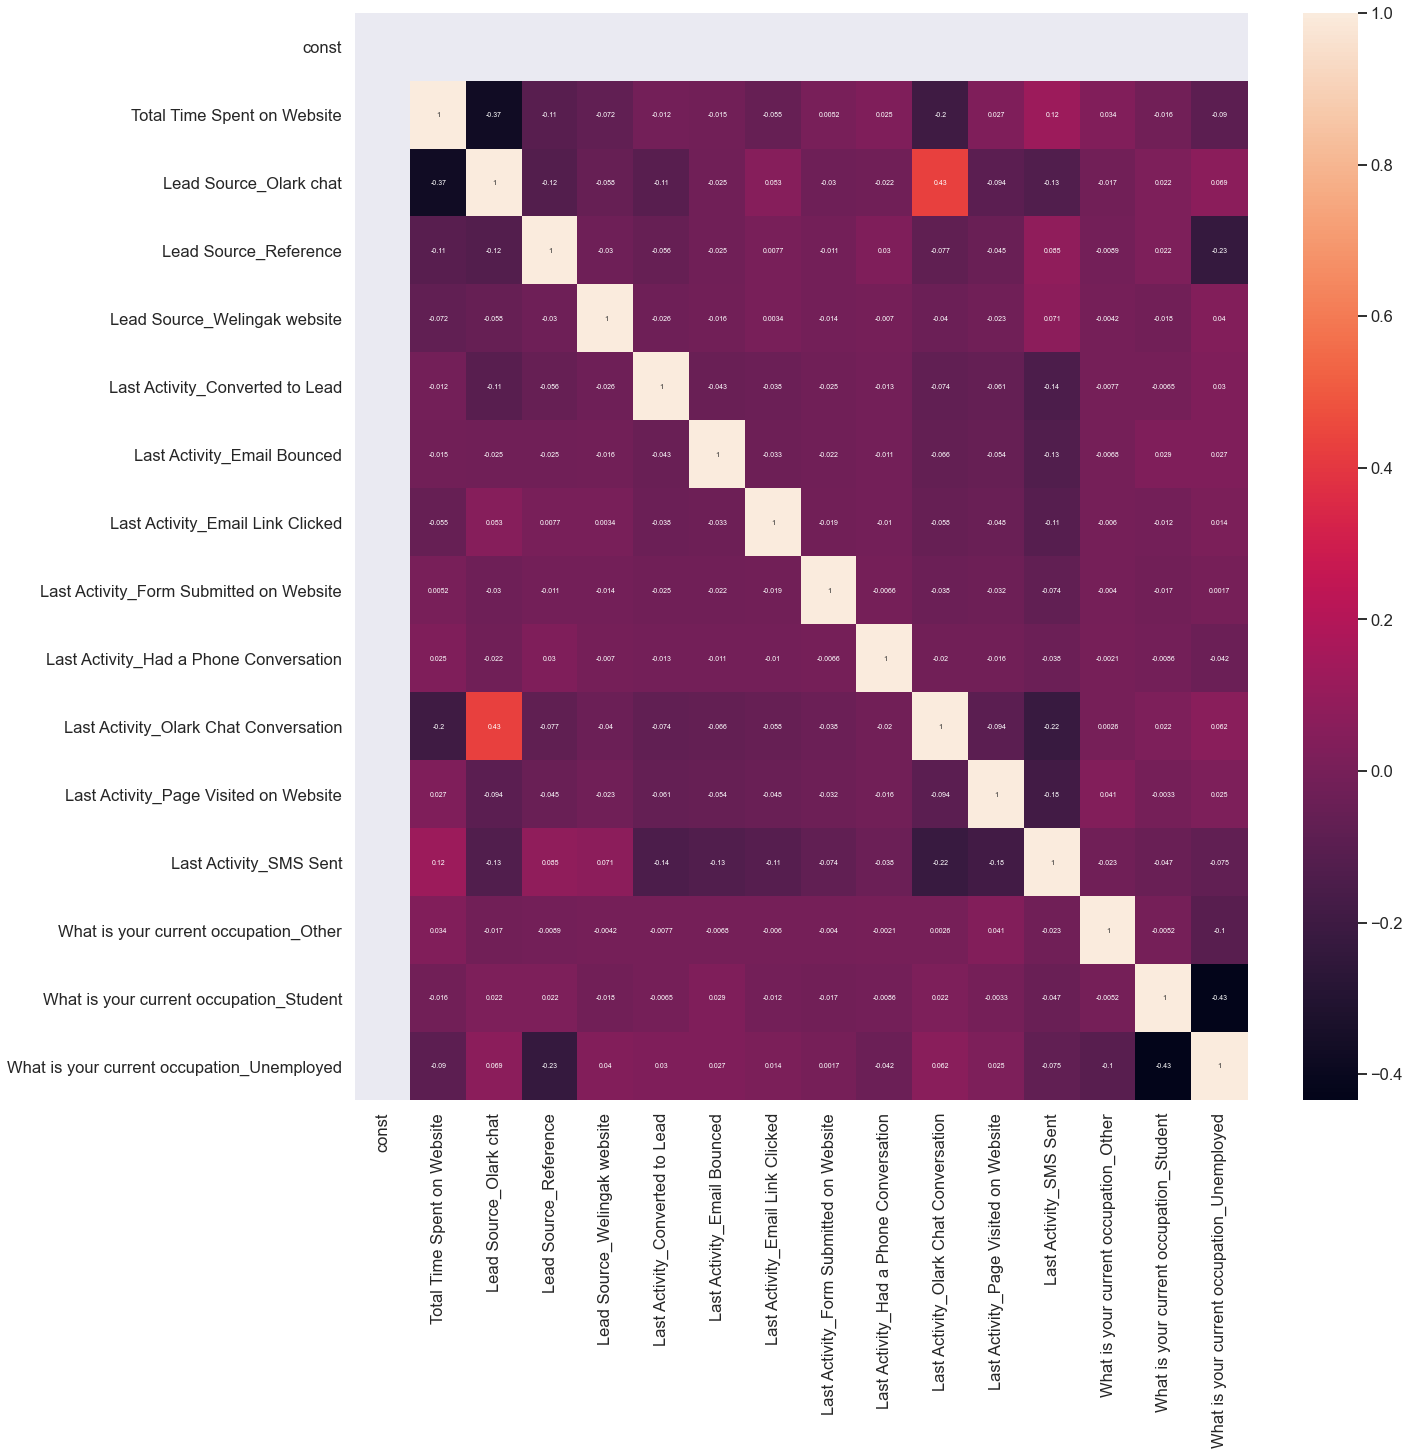

In [190]:
generateHeatmaps(X_train_sm, (20,20))

### Observation

As we can confirm with our heatmap, there is no multicollinearity in the model.

We will take model 7 as our final model for the condition where RFE has 15 variables. Which is less than the original RFE count of 20.

### Generating predicted values on the training set

In [191]:
y_train_pred = res.predict(X_train_sm)
y_train_pred.head()

1871    0.246230
6795    0.218088
3516    0.286750
8105    0.774819
3934    0.246230
dtype: float64

In [192]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.24623032, 0.21808785, 0.28674957, 0.77481906, 0.24623032,
       0.98980465, 0.11277935, 0.99893012, 0.12104251, 0.86837451])

##### Creating a dataframe with the actual 'Converted' flag and the predicted 'Lead_Score_Prob' probabilities

In [193]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Lead_Score_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

Converted  Lead_Score_Prob  CustID
0          0         0.246230    1871
1          0         0.218088    6795
2          0         0.286750    3516
3          0         0.774819    8105
4          0         0.246230    3934

#### Creating new column 'Predicted_Hot_Lead' 
(with value 1 if Lead_Score_Prob > 0.5 else 0)

- Please Note that we have selected an arbitrary cut off of of 0.5 as of now And we will be selecting the final cutoff later below

In [194]:
y_train_pred_final['Predicted_Hot_Lead'] = y_train_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head


y_train_pred_final.head()

Converted  Lead_Score_Prob  CustID  Predicted_Hot_Lead
0          0         0.246230    1871                   0
1          0         0.218088    6795                   0
2          0         0.286750    3516                   0
3          0         0.774819    8105                   1
4          0         0.246230    3934                   0

##### Creating new column 'Lead_Score'
Lead_Score would be equal to (Lead_Score_Prob * 100)

In [195]:
y_train_pred_final['Lead_Score'] = round((y_train_pred_final['Lead_Score_Prob'] * 100),0)

y_train_pred_final['Lead_Score'] = y_train_pred_final['Lead_Score'].astype(int)

# Let's see the head
y_train_pred_final.head()

Converted  Lead_Score_Prob  CustID  Predicted_Hot_Lead  Lead_Score
0          0         0.246230    1871                   0          25
1          0         0.218088    6795                   0          22
2          0         0.286750    3516                   0          29
3          0         0.774819    8105                   1          77
4          0         0.246230    3934                   0          25

In [196]:
# Confusion matrix 

from sklearn import metrics
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted_Hot_Lead )
print(confusion)


[[3589  413]
 [ 869 1597]]


In [197]:
# Let's check the overall accuracy.
print(round(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted_Hot_Lead),2))

0.8


In [198]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [199]:
# Let's see the sensitivity of our logistic regression model
round((TP / float(TP+FN)),2)

0.65

In [200]:
# Let us calculate specificity
round((TN / float(TN+FP)),2)

0.9

### Observation

Based on the above statistics for Accuracy(80%), Sensitivity(65%) and Specificity(90%) we can say that our trained model is currently highly specific but not very sensitive. Our objective is to create a highly sensitive model with 80% sensitivity. Let us find cut-off values using ROC curves to improve this.

### Plotting ROC Curve
An ROC curve demonstrates several things:

It shows the trade-off between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [201]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Lead_Score_Prob, drop_intermediate = False )

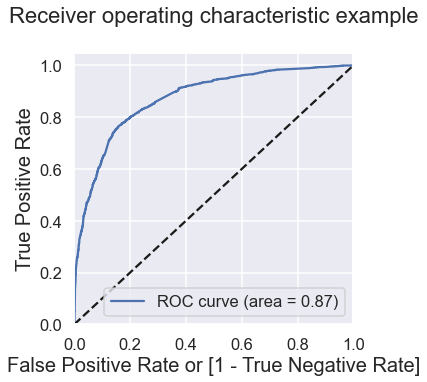

In [202]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Lead_Score_Prob)

### Observation

From the ROC curve we can say that the model will be able to provide us with a good result overall. 

#### Finding Optimal Cutoff Point

- Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [203]:
# Let's create columns with different probability cutoffs 

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Lead_Score_Prob  CustID  Predicted_Hot_Lead  Lead_Score  0.0  \
0          0         0.246230    1871                   0          25    1   
1          0         0.218088    6795                   0          22    1   
2          0         0.286750    3516                   0          29    1   
3          0         0.774819    8105                   1          77    1   
4          0         0.246230    3934                   0          25    1   

   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  
0    1    1    0    0    0    0    0    0    0  
1    1    1    0    0    0    0    0    0    0  
2    1    1    0    0    0    0    0    0    0  
3    1    1    1    1    1    1    1    0    0  
4    1    1    0    0    0    0    0    0    0

In [204]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['Probability','Accuracy','Sensitivity','Specificty'])


num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     Probability  Accuracy  Sensitivity  Specificty
0.0          0.0  0.381262     1.000000    0.000000
0.1          0.1  0.579004     0.972019    0.336832
0.2          0.2  0.720625     0.919708    0.597951
0.3          0.3  0.788343     0.822790    0.767116
0.4          0.4  0.812616     0.757502    0.846577
0.5          0.5  0.801793     0.647607    0.896802
0.6          0.6  0.788652     0.574209    0.920790
0.7          0.7  0.772109     0.492295    0.944528
0.8          0.8  0.743661     0.374290    0.971264
0.9          0.9  0.710884     0.258719    0.989505


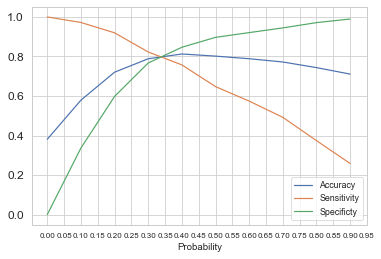

In [205]:
# Let's plot accuracy sensitivity and specificity for various probabilities

sns.set_style('whitegrid')
sns.set_context('paper')

cutoff_df.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificty'])
plt.xticks(np.arange(0,1,step=.05), size=8)
plt.yticks(size=12)
plt.show()

### Observation

From the above curve we can see that the optimal cutoff is at 0.33. This is the point where all the parameters are equally balanced

In [206]:
y_train_pred_final['Predicted_Hot_Lead'] = y_train_pred_final.Lead_Score_Prob.map( lambda x: 1 if x > 0.33 else 0)

y_train_pred_final.head()

Converted  Lead_Score_Prob  CustID  Predicted_Hot_Lead  Lead_Score  0.0  \
0          0         0.246230    1871                   0          25    1   
1          0         0.218088    6795                   0          22    1   
2          0         0.286750    3516                   0          29    1   
3          0         0.774819    8105                   1          77    1   
4          0         0.246230    3934                   0          25    1   

   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  
0    1    1    0    0    0    0    0    0    0  
1    1    1    0    0    0    0    0    0    0  
2    1    1    0    0    0    0    0    0    0  
3    1    1    1    1    1    1    1    0    0  
4    1    1    0    0    0    0    0    0    0

In [207]:
round(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted_Hot_Lead),2)

0.8

In [208]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted_Hot_Lead )
confusion2

array([[3191,  811],
       [ 490, 1976]], dtype=int64)

In [209]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [210]:
# Let's see the sensitivity of our logistic regression model
round(TP / float(TP+FN),2)

0.8

In [211]:
# Let us calculate specificity
round(TN / float(TN+FP),2)

0.8

### Observation

As we can see above, when we are selecting the optimal cutoff = 0.33, the various performance parameters Accuracy, Sensitivity & Specificity are all 80%

This meets our objective of getting a highly sensitive model with 80% sensitivity

### Precision and Recall Curve

In [212]:
### Calculating Precision
precision =round(TP/float(TP+FP),2)
precision

0.71

In [213]:
### Calculating Recall
recall = round(TP/float(TP+FN),2)
recall

0.8

### Observation

From the above scores we note that our model has a good overall relevancy, defined by Precision, at 71% & a great return of relevant results, defined by Recall, at 80%.


For the purposes of our model we will focus on the Recall result as we would like to miss out on any hot leads that are willing to be converted. 

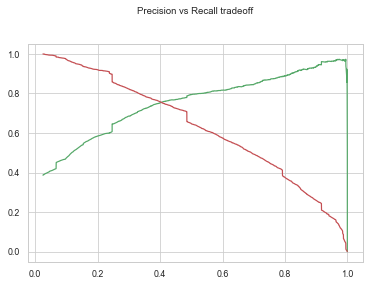

In [214]:
### Let us generate the Precision vs Recall tradeoff curve 
p ,r, thresholds=precision_recall_curve(y_train_pred_final.Converted,y_train_pred_final['Lead_Score_Prob'])
plt.title('Precision vs Recall tradeoff')
plt.plot(thresholds, p[:-1], "g-")    # Plotting precision
plt.plot(thresholds, r[:-1], "r-")    # Plotting Recall
plt.show()

### Observation 

The precision vs recall tradeoff value from the above graph is at 0.4

In [215]:
### The F statistic is given by 2 * (precision * recall) / (precision + recall)
## The F score is used to measure a test's accuracy, and it balances the use of precision and recall to do it.
### The F score can provide a more realistic measure of a test's performance by using both precision and recall
F1 =2 * (precision * recall) / (precision + recall)
round(F1,2)

0.75

### Observation

Based on the F1 score we can say that our model is fairly accurate. Let us test this accuracy on the test set.

### Making Predictions on test set

In [216]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

In [217]:
X_train_cols.shape

(6468, 15)

In [218]:
X_test = X_test[X_train_cols.columns]

X_test.shape

(2772, 15)

In [219]:
X_test.head()

Total Time Spent on Website  Lead Source_Olark chat  \
4269                     0.964503                       0   
2376                    -0.885369                       0   
7766                    -0.777780                       0   
9199                    -0.885369                       1   
4359                    -0.885369                       0   

      Lead Source_Reference  Lead Source_Welingak website  \
4269                      0                             0   
2376                      1                             0   
7766                      0                             0   
9199                      0                             0   
4359                      1                             0   

      Last Activity_Converted to Lead  Last Activity_Email Bounced  \
4269                                0                            0   
2376                                0                            0   
7766                                0                            0   
9199                                0                            0   
4359                                0                            0   

      Last Activity_Email Link Clicked  \
4269                                 0   
2376                                 0   
7766                                 0   
9199                                 0   
4359                                 0   

      Last Activity_Form Submitted on Website  \
4269                                        0   
2376                                        0   
7766                                        0   
9199                                        0   
4359                                        0   

      Last Activity_Had a Phone Conversation  \
4269                                       0   
2376                                       0   
7766                                       0   
9199                                       0   
4359                                       0   

      Last Activity_Olark Chat Conversation  \
4269                                      0   
2376                                      0   
7766                                      0   
9199                                      1   
4359                                      0   

      Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
4269                                      0                       1   
2376                                      0                       1   
7766                                      0                       0   
9199                                      0                       0   
4359                                      0                       0   

      What is your current occupation_Other  \
4269                                      0   
2376                                      0   
7766                                      0   
9199                                      0   
4359                                      0   

      What is your current occupation_Student  \
4269                                        0   
2376                                        0   
7766                                        0   
9199                                        0   
4359                                        0   

      What is your current occupation_Unemployed  
4269                                           1  
2376                                           1  
7766                                           0  
9199                                           1  
4359                                           1

In [220]:
X_test_sm = sm.add_constant(X_test)

In [221]:
y_test_pred = res.predict(X_test_sm)

In [222]:
y_test_pred[:10]

4269    0.691605
2376    0.916459
7766    0.666918
9199    0.066763
4359    0.791603
9186    0.506920
1631    0.437966
8963    0.153821
8007    0.051991
5324    0.298284
dtype: float64

In [223]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

0
4269  0.691605
2376  0.916459
7766  0.666918
9199  0.066763
4359  0.791603

In [224]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [225]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [226]:
# Removing index for both dataframes to append them side by side 

y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [227]:
# Appending y_test_df and y_pred_1

y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [228]:
y_pred_final.head()

Converted  CustID         0
0          1    4269  0.691605
1          1    2376  0.916459
2          1    7766  0.666918
3          0    9199  0.066763
4          1    4359  0.791603

In [229]:
# Renaming the column 

y_pred_final= y_pred_final.rename(columns={ 0 : 'Lead_Score_Prob'})

In [230]:
# Rearranging the columns

y_pred_final = y_pred_final.reindex(['CustID','Converted','Lead_Score_Prob'], axis=1)

In [231]:
# Adding Lead_Score column

y_pred_final['Lead_Score'] = round((y_pred_final['Lead_Score_Prob'] * 100),0)

y_pred_final['Lead_Score'] = y_pred_final['Lead_Score'].astype(int)

In [232]:
# Let's see the head of y_pred_final
y_pred_final.head()

CustID  Converted  Lead_Score_Prob  Lead_Score
0    4269          1         0.691605          69
1    2376          1         0.916459          92
2    7766          1         0.666918          67
3    9199          0         0.066763           7
4    4359          1         0.791603          79

In [233]:
y_pred_final['Final_Predicted_Hot_Lead'] = y_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > 0.33 else 0)

In [234]:
y_pred_final.head()

CustID  Converted  Lead_Score_Prob  Lead_Score  Final_Predicted_Hot_Lead
0    4269          1         0.691605          69                         1
1    2376          1         0.916459          92                         1
2    7766          1         0.666918          67                         1
3    9199          0         0.066763           7                         0
4    4359          1         0.791603          79                         1

In [235]:
# Let's check the overall accuracy.
round(metrics.accuracy_score(y_pred_final.Converted, y_pred_final.Final_Predicted_Hot_Lead),2)

0.8

In [236]:
confusion4 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.Final_Predicted_Hot_Lead )
confusion4

array([[1337,  340],
       [ 228,  867]], dtype=int64)

In [237]:
TP = confusion4[1,1] # true positive 
TN = confusion4[0,0] # true negatives
FP = confusion4[0,1] # false positives
FN = confusion4[1,0] # false negatives

In [238]:
# Let's see the sensitivity of our logistic regression model
round((TP / float(TP+FN)),2)

0.79

In [239]:
# Let us calculate specificity
round(TN / float(TN+FP),2)

0.8

## Observation And Conclusion (on Test Set)

- As we can see above when cut-off = 0.33, the various Model Performance parameters on test set are as per below
- Sensitivity = 79%
- Specificity = 80%
- Accuracy = 80%%
- All the 3 performance parameters on test set appear to be almost same with no much variation, so we are good with the modeling now.

## Final Model Reporting & Equation

log odds is given by: log(P/1-P) = c + B1X1 +B2X2 + B3X3 + .... + BnXn

- log odds = 1.5252 +(1.0683 * Total Time Spent on Website) + (1.1104 * Lead Source_Olark chat) + (3.5638 * Lead Source_Reference) + (5.4885 * Lead Source_Welingak website) + (-1.3461 * Last Activity_Converted to Lead) + (-1.9256 * Last Activity_Email Bounced) + (-0.5873 * Last Activity_Email Link Clicked) + (-0.7636 * Last Activity_Form Submitted on Website) + (2.0298 * Last Activity_Had a Phone Conversation) + (-1.5187 * Last Activity_Olark Chat Conversation) + (-0.6397 * Last Activity_Page Visited on Website) +(1.0606 * Last Activity_SMS Sent)+(-2.7448 * What is your current occupation_Other)+(-2.4126 * What is your current occupation_Student)+(-2.8085 * What is your current occupation_Unemployed)


## Key Insights

- Hot Leads are identified as 'Customers having lead score of 33 or above'
- Sales Team of the company should first focus on the 'Hot Leads'  
- Higher the Lead Score, higher the chances of conversion of 'Hot Leads' into 'Paying Customers'
- The 'Cold Leads'(Customer having lead score < 33) should be focused after the Sales Team is done with the 'Hot Leads'

# 4. Generating Leads Table

Our final objective is to generate a table with the probability of converting leads to students. 

We will do this by mapping the lead score to the respective lead numbers present in our original dataset. 

In [240]:
### Generating table
resultingTable = pd.merge(y_pred_final,leadScoreDataset,how='inner',left_on='CustID',right_index=True)
resultingTable[['Lead Number','Lead_Score']].head()

Lead Number  Lead_Score
0       619003          69
1       636884          92
2       590281          67
3       579892           7
4       617929          79

In [241]:
resultingTable.shape

(2772, 42)

### Observation

From the resultant shape we can confirm that the number of rows in the final dataset are the same as that in the test data set. Therefore we can use the values from the 'resultingTable' dataset to pursue the leads.based on the key insights identified above. 

# 5. Conclusion

We conducted this case study for X Education with the objective of providing them insights to successfully convert leads they received into students of the platform. Our goal was to generate a machine learning based model that identifies the highest probability of converting customers to students. 

We started this by assessing the data and identifying various columns, understanding what they mean by assessing the data dictionary. We initially saw that there were a large number of 'Select' values spread across the dataset. These values meant that the user had made no selection in those fields. We decided to replace these values with NaN values and treated them appropriately later. Then we conducted an analysis on the percentage of null columns in the dataset, tackling the ones with the highest percentage of null values first. We removed columns that had over 70% null values and for the remaining columns assessed them individually. 

While assessing our columns individually we found that various columns were actually summarized into one column already. Therefore, it did not make sense for us to keep these columns and we decided to drop them entirely. Examples of such columns are Search, Newspaper Article etc., they are already represented in the 'Lead Source' column. The  distribution represented in these individual columns was very well represented by the data in the Lead Source column. There were a few columns that had highly skewed data, i.e. data pointing in one direction only. The Country, What matters most to you in choosing a course, are a few examples. Most of the leads, 95% and above, mentioned that they were from India and were looking for better career prospects. We dropped these columns as well. 
The tendency of skewed data to sway the model heavily towards its direction makes the model incapable of predicting the results correctly. 

While analyzing the various columns we performed univariate and bivariate analysis on them. Bivariate analysis was carried out with the Converted column as a benchmark. This analysis yielded some very important insights that we have mentioned below. Key being that the longer the user stayed on the website, the higher the chances of them converting.

Of particular interest to us was the 'Total Time Spent on The Website' column. This column had highly varied data that we had to properly convert to correct metrics to make better sense of it. 

Certain columns had a large mix of values, some outliers and a small number of null values. We had to perform appropriate outlier & null value treatment for each of these. In certain cases such as that of the Specialization column, we could not have taken the Mode value to impute the null columns. This is because  we had to consider the fact that the mentioned options in the form might not have represented the applicants specialization correctly. We decided to club these values into one field and later assess them. 
In the case of numerical columns like TotalVisits we imputed the null values with the median value. This is because the difference between the median and mean was very less. We also capped any outliers present instead of dropping them so that all the rows of data are retained. Capping was done with by replacing the lowest values with the 1%ile & highest with the 95%ile value in the column. 

Having conducted our EDA and prepared our data free of any anomalies we proceeded to preparing our data for the Logistic Regression Model.

We created dummy variables from our final 12 variables and correctly dropped all the original columns, other category variables that we had created. Then we performed the train-test split using the 70-30 method for splitting. 
Using the StandardScaler we scaled our numerical columns so that all the variables follow similar units. Scaling helps us in standardizing our dataset and preventing any features that have higher units to skew the model in its favor. We assessed the split datasets and plotted a correlation heatmap to identify any variables with high collinearity. We found 2 such variables and dropped them from both the training and test sets. 

Finally, we proceeded to creating our logistic regression model.
Firstly, it is important that we define our model acceptance criteria:
- The model does not over-fit
- The model is simple enough to be understood
- The model is built using significant features.
- The VIF value is under 3 & the p value is under 0.05 for each feature
- The accuracy, sensitivity and specificity of our model after test are at least 80%(+- 1% between all 3 parameters)


We created a basic logistic regression model with all our features from the scaled training dataset.
The GLM summary report from this model provided us the base benchmarks for our model. Based on the above criteria we performed RFE with 20 variables and began creating and the models. We eliminated any variables that had high p values and VIF values. Eventually we generated a model with 15 variables that we performed training and testing on.

On both our training and testing models we predicted the probability score for converting the leads and correctly added them to a new table along with the customer id. Once we had our scores and probability of converting a lead, we checked for the accuracy, specificity, sensitivity, precision and recall. Our model performed very well on these statistics. WE generated the ROC curve and the probability cutoff curve to find our optimal cutoff, which is 0.33. 

Assessing our model at the optimal cutoff we saw that our model satisfied our condition of 80% sensitivity. 
We then compared then ran our model against our test set and achieved a similar result of 80% sensitivity.
Thus confirming our model is correct and completing the modeling. 

Finally, we generated the table which contains lead scores for the leads in the original dataset. These scores can now be used to convert leads to students of the platform. The bench mark being that the leads above a score of 33 have a higher chance of converting. The higher the score, the better the chances of conversion.

Through the course of this case study for X Education we have identified the following key aspects:

- Most applicants would like to join a course to have better career prospects
- X Education has the highest conversion rate of individuals who are referred to them
- Overall it is safe to say that the more time the user spends on the website, the better their chances of becoming a student.
- Hot Leads are identified as 'Customers having lead score of 33 or above'
- Sales Team of the company should first focus on the 'Hot Leads'  
- Higher the Lead Score, higher the chances of conversion of 'Hot Leads' into 'Paying Customers'
- The 'Cold Leads'(Customer having lead score < 33) should be focused after the Sales Team is done with the 'Hot Leads'

# End of File